In [2]:
import numpy as np
import pandas as pd
import optuna
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier
from typing import Union, Tuple

# Загрузим данные

- Данные упорядочены по времени
- Задача - предсказать `target`
- Фичи - `feature_i`
- Трейн, валидация и тест уже определены (см. колонку `sample_part`)

Скачайте датасет по [ссылке](https://data.tinkoff.ru/s/WreJPgb9pJS687D). Пароль в канале курса.

In [3]:
df = pd.read_parquet('df.parquet.gzip')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 22620 to 310653
Columns: 235 entries, date to sample_part
dtypes: category(2), datetime64[ms](1), datetime64[us](2), float64(220), int64(9), object(1)
memory usage: 893.6+ MB


In [4]:
df.head()

,date,month,quarter,feature_217,feature_66,feature_9,feature_193,feature_15,feature_199,feature_25,...,feature_20,feature_188,feature_71,feature_106,feature_14,feature_92,feature_179,feature_102,target,sample_part
22620,2021-01-01,2021-01-01,2021-01-01,1.180855,0.483118,13.976791,1.135021,43.271792,-46.888875,97.558366,...,23.745198,-32.001093,85.489903,1.454045,-195.725786,3.719083,1,-28.813537,0.0,train
478621,2021-01-01,2021-01-01,2021-01-01,3.427814,0.886778,27.158209,-0.378728,80.087863,-67.242703,105.803406,...,22.902111,-37.436243,71.735619,1.657242,-176.250404,3.277817,1,-45.987721,1.0,train
372254,2021-01-01,2021-01-01,2021-01-01,-38.555018,1.227175,19.893873,0.498787,98.464365,-67.402522,81.858076,...,21.848414,-51.872841,65.363236,1.626874,-178.116798,2.028950,0,-31.074122,1.0,train
2596,2021-01-01,2021-01-01,2021-01-01,-14.666558,0.753129,18.203010,-1.200014,117.331340,-25.557745,90.277266,...,26.134586,-49.703003,65.013659,1.170023,-192.232264,2.218177,1,-36.703897,0.0,train
216892,2021-01-01,2021-01-01,2021-01-01,6.734990,1.129100,11.245920,-0.108955,61.205722,-78.397406,82.637472,...,24.201039,-41.070219,69.986127,1.630795,-200.155528,3.055104,1,-44.672299,1.0,train


In [5]:
TARGET = 'target'
N_FEATURES = 230
features = [f'feature_{i}' for i in range(N_FEATURES)]

# Первичный отбор признаков... (1 балл)

**Задание:** Сначала отсеем совсем уж мусорные признаки.

Воспользовавшись вашим кодом для вычисления `IV` из прошлой домашки, для всех **числовых** фичей вычислите `IV` на 20 бакетах. Отсейте признаки с `IV < 0.005`.

**Hint:** паркет не всегда сохраняет `dtype` колонки. Чтобы проверить признаки на "реальный" тип данных, лучше на всякий случай посмотреть на `nunique` 

In [6]:
df[features].columns[df[features].nunique() < 30000]

Index(['feature_0', 'feature_10', 'feature_31', 'feature_37', 'feature_62',
       'feature_140', 'feature_144', 'feature_147', 'feature_157',
       'feature_161', 'feature_165', 'feature_168', 'feature_179',
       'feature_209', 'feature_222'],
      dtype='object')

In [6]:
df[['feature_0', 'feature_10', 'feature_31', 'feature_37', 'feature_62',
       'feature_140', 'feature_144', 'feature_147', 'feature_157',
       'feature_161', 'feature_165', 'feature_168', 'feature_179',
       'feature_209', 'feature_222']].nunique()

feature_0       4
feature_10      2
feature_31      3
feature_37     12
feature_62      2
feature_140    52
feature_144     2
feature_147     2
feature_157    13
feature_161     2
feature_165     2
feature_168     2
feature_179     2
feature_209     3
feature_222     2
dtype: int64

In [7]:
from scipy.special import logit

def woe_transform(badrate : float, offset : float) -> float:
    """Считаем WoE для бакета с данным badrate и выборки
    с данным offset."""
    epsilon = 0.001
    badrate = np.clip(badrate, epsilon, 1 - epsilon)
    woe = logit(badrate) - offset
    return woe

In [8]:
def calc_buckets(x : Union[np.ndarray, pd.Series], n_buckets : int) -> np.ndarray:
    """Разбивает массив значений признака x на 
    n_buckets бакетов"""

    x = pd.Series(x).reset_index(drop=True)
    buckets = x.rank(method="dense", pct=True) * n_buckets
    buckets = np.ceil(buckets) - 1   # np.floor дает другой результат для 5.0, 6.0 и т.д.
    buckets = np.array(buckets, dtype=np.int16)

    return buckets

In [9]:
def IV_score(target: np.ndarray,
                buckets: np.ndarray):
    _, indices = np.unique(buckets, return_inverse=True)
    bucket_n = np.bincount(indices)
    bucket_sum = np.bincount(indices, weights=target)
    B_i = bucket_sum
    B = target.sum()
    G_i = bucket_n - B_i
    G = len(target) - B
    badrate_i = bucket_sum / bucket_n
    offset = logit(target.sum() / len(target))
    woe = pd.Series(woe_transform(badrate_i, offset))
    IV = np.sum((B_i / B - G_i / G) * woe)
    return IV

In [10]:
target = df[TARGET]
good_numeric_feature = []
category_feature = []

In [8]:
for feature in features:
    if (df[feature].nunique() < 20):
        continue
    buckets = calc_buckets(df[feature], 20)
    iv = IV_score(target, buckets)

    if (iv >= 0.005):
        good_numeric_feature.append(feature)

/home/denis/.local/lib/python3.10/site-packages/pandas/core/series.py:1022: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


In [10]:
len(good_numeric_feature)

54

**Вопрос**: Почему некорректно сравнивать `IV` у категориальных и числовых фичей?

Вычислите IV для категориальных фичей на `n` бакетах, где `n = min(число категорий фичи, 20)`. Возможно, придётся перекодировать некоторые фичи (*только не OneHot-ом!*)

*Опционально*: примените также и к категориальным фичам предварительный отбор по `IV` с менее строгим порогом

**Ответ**:
- Разное кол-во бакетов
- Так как категориальные признаки имеют определенные значения, его IV более устойчив (в тестовую выборку могут попасть числовые значения, которые не находятся в диапазоне значений train выборки)

In [11]:
from sklearn.preprocessing import LabelEncoder

In [12]:
for feature in features:
    if (df[feature].nunique() >= 20):
        continue
    le = LabelEncoder()
    df_column_up = le.fit_transform(df[feature])
    buckets = calc_buckets(df_column_up, min(len(np.unique(df_column_up)), 20))
    iv = IV_score(target, buckets)

    if (iv >= 0.002):
        category_feature.append(feature)
    print(feature, iv)

feature_0 0.0008358691357387304
feature_10 0.011839696555363967
feature_31 0.012373891296708375
feature_37 0.00012575456432455502
feature_62 0.00706412337610622
feature_144 0.013360993295612683
feature_147 0.007958353560070207
feature_157 0.00014195011557541028
feature_161 0.0026729692259997626
feature_165 0.00913622428642341
feature_168 0.006440163058606558
feature_179 6.183068576974373e-07
feature_209 0.02519535296049066
feature_222 7.464729004320941e-07


In [10]:
len(category_feature)

9

In [13]:
le = [LabelEncoder() for _ in range(len(category_feature))]
for le_i in range(len(le)):
    df[category_feature[le_i]] = le[le_i].fit_transform(df[category_feature[le_i]])

# Бустинг

## Подбор гиперпараметров бустинга (2 балла)

Теперь подберем оптимальные гиперпараметры бустинга.

In [15]:
# В переменную features_optuna положите список признаков с предыдущего шага
features_optuna = good_numeric_feature + category_feature

**Задание:** Заполните пропуски в коде ниже и подберите оптимальные гиперпараметры.

Для успешного решения необходимо преодолеть порог ROC-AUC `0.725` на тестовой выборке.

In [19]:
def objective(trial):
    params = {
        # 'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss', 'rf']),
        'learning_rate': trial.suggest_float('learning_rate', 1e-2, 0.4, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 500),
        'subsample': trial.suggest_float('subsample', 0.0, 1.0),
        'n_estimators': trial.suggest_int('num_leaves', 1, 800),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.0, 1.0),
        'importance_type': trial.suggest_categorical('importance_type', ['split', 'gain']),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 3),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 3),
        'objective': 'binary',
        'n_jobs': 12,
        #####
        # your code here
        # Тут вы можете добавить любые гиперпараметры LGBMClassifier (например, что-то из того, что разбирали в лекции)
        #####
        'random_state': 42
    }

    clf = LGBMClassifier(**params)
    clf.fit(
        X=df.loc[df['sample_part'] == 'train', features_optuna],
        y=df.loc[df['sample_part'] == 'train', TARGET]
    )
    preds = clf.predict_proba(df.loc[df['sample_part'] == 'val', features_optuna])[:, 1]
    auc_valid = roc_auc_score(
        y_true=df.loc[df['sample_part'] == 'val', TARGET],
        y_score=preds
    )

    return auc_valid

In [18]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

[I 2024-04-01 12:48:30,488] A new study created in memory with name: no-name-64a6cc22-4f96-43a9-8314-8625bab58f2b


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:48:42,648] Trial 0 finished with value: 0.7445005235551239 and parameters: {'learning_rate': 0.18312444310486622, 'max_depth': 125, 'subsample': 0.948085524087867, 'num_leaves': 591, 'colsample_bytree': 0.7171365055018374, 'importance_type': 'gain', 'reg_alpha': 1.4559035057458853, 'reg_lambda': 2.595776426854668}. Best is trial 0 with value: 0.7445005235551239.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890


[I 2024-04-01 12:48:48,760] Trial 1 finished with value: 0.7344275444390481 and parameters: {'learning_rate': 0.14351858160048198, 'max_depth': 95, 'subsample': 0.8816436062239197, 'num_leaves': 207, 'colsample_bytree': 0.9335445633937115, 'importance_type': 'gain', 'reg_alpha': 1.353185996589419, 'reg_lambda': 2.479657049618295}. Best is trial 0 with value: 0.7445005235551239.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890


[I 2024-04-01 12:48:50,741] Trial 2 finished with value: 0.7083721384167071 and parameters: {'learning_rate': 0.08442755768582291, 'max_depth': 282, 'subsample': 0.4840867456236212, 'num_leaves': 65, 'colsample_bytree': 0.5522990235322709, 'importance_type': 'gain', 'reg_alpha': 2.4887722638695116, 'reg_lambda': 1.0902745333496076}. Best is trial 0 with value: 0.7445005235551239.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (n

[I 2024-04-01 12:48:59,040] Trial 3 finished with value: 0.7355925716367169 and parameters: {'learning_rate': 0.28654115022764237, 'max_depth': 265, 'subsample': 0.21125977294019438, 'num_leaves': 435, 'colsample_bytree': 0.9352485981368034, 'importance_type': 'split', 'reg_alpha': 0.39792439691096626, 'reg_lambda': 1.0343748360344427}. Best is trial 0 with value: 0.7445005235551239.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:49:21,756] Trial 4 finished with value: 0.722921084992715 and parameters: {'learning_rate': 0.014324818532816962, 'max_depth': 248, 'subsample': 0.024062993398165533, 'num_leaves': 618, 'colsample_bytree': 0.949567121050867, 'importance_type': 'split', 'reg_alpha': 0.2478532435818398, 'reg_lambda': 1.7272970603139202}. Best is trial 0 with value: 0.7445005235551239.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:49:35,008] Trial 5 finished with value: 0.7441808081593007 and parameters: {'learning_rate': 0.08090328220906594, 'max_depth': 365, 'subsample': 0.08298357378728516, 'num_leaves': 701, 'colsample_bytree': 0.9587875577893682, 'importance_type': 'gain', 'reg_alpha': 1.112086991592407, 'reg_lambda': 1.0872071268314045}. Best is trial 0 with value: 0.7445005235551239.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:49:52,696] Trial 6 finished with value: 0.726870410393395 and parameters: {'learning_rate': 0.014527792880417296, 'max_depth': 71, 'subsample': 0.6497441073532841, 'num_leaves': 771, 'colsample_bytree': 0.811779573751762, 'importance_type': 'split', 'reg_alpha': 2.5239367989235078, 'reg_lambda': 1.472749134155234}. Best is trial 0 with value: 0.7445005235551239.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890


[I 2024-04-01 12:49:56,137] Trial 7 finished with value: 0.6955743642544925 and parameters: {'learning_rate': 0.019889626868304592, 'max_depth': 361, 'subsample': 0.4089324302800006, 'num_leaves': 128, 'colsample_bytree': 0.6690250120159187, 'importance_type': 'split', 'reg_alpha': 2.056319576965077, 'reg_lambda': 1.4486447839354075}. Best is trial 0 with value: 0.7445005235551239.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (n

[I 2024-04-01 12:50:06,641] Trial 8 finished with value: 0.7357110650801361 and parameters: {'learning_rate': 0.27643287814470746, 'max_depth': 427, 'subsample': 0.94314979762852, 'num_leaves': 771, 'colsample_bytree': 0.7572125329448869, 'importance_type': 'gain', 'reg_alpha': 0.6388584589285589, 'reg_lambda': 0.8067917665778337}. Best is trial 0 with value: 0.7445005235551239.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:50:11,630] Trial 9 finished with value: 0.7107160568237009 and parameters: {'learning_rate': 0.02333023723403631, 'max_depth': 374, 'subsample': 0.8527305633673785, 'num_leaves': 445, 'colsample_bytree': 0.15749818134108573, 'importance_type': 'gain', 'reg_alpha': 1.9126442603379115, 'reg_lambda': 2.530341587121796}. Best is trial 0 with value: 0.7445005235551239.


[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890


[I 2024-04-01 12:50:14,467] Trial 10 finished with value: 0.6906492710053425 and parameters: {'learning_rate': 0.03579909578282767, 'max_depth': 3, 'subsample': 0.6792950738301919, 'num_leaves': 290, 'colsample_bytree': 0.3053807877369275, 'importance_type': 'gain', 'reg_alpha': 0.9186491479049685, 'reg_lambda': 0.02576236766078499}. Best is trial 0 with value: 0.7445005235551239.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:50:22,944] Trial 11 finished with value: 0.7431040529383196 and parameters: {'learning_rate': 0.09888293697267181, 'max_depth': 497, 'subsample': 0.010514197929749614, 'num_leaves': 583, 'colsample_bytree': 0.4744826222614977, 'importance_type': 'gain', 'reg_alpha': 1.200561285875346, 'reg_lambda': 2.9932165145355527}. Best is trial 0 with value: 0.7445005235551239.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:50:31,130] Trial 12 finished with value: 0.7443096522583779 and parameters: {'learning_rate': 0.16328197073392411, 'max_depth': 169, 'subsample': 0.2804742822428199, 'num_leaves': 616, 'colsample_bytree': 0.624681072964375, 'importance_type': 'gain', 'reg_alpha': 1.6870403309285078, 'reg_lambda': 0.42013234643723507}. Best is trial 0 with value: 0.7445005235551239.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:50:38,615] Trial 13 finished with value: 0.7422598285575522 and parameters: {'learning_rate': 0.15016462911170542, 'max_depth': 168, 'subsample': 0.30317620848621907, 'num_leaves': 514, 'colsample_bytree': 0.5046331211475712, 'importance_type': 'gain', 'reg_alpha': 1.7313431032096047, 'reg_lambda': 0.11128382766146222}. Best is trial 0 with value: 0.7445005235551239.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:50:47,231] Trial 14 finished with value: 0.7450317576493444 and parameters: {'learning_rate': 0.15459647217502157, 'max_depth': 171, 'subsample': 0.6281427669695776, 'num_leaves': 619, 'colsample_bytree': 0.6207560346826999, 'importance_type': 'gain', 'reg_alpha': 2.859909442544021, 'reg_lambda': 2.086084711887949}. Best is trial 14 with value: 0.7450317576493444.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:50:52,851] Trial 15 finished with value: 0.7278688931520155 and parameters: {'learning_rate': 0.043833678020413484, 'max_depth': 169, 'subsample': 0.7001822375552493, 'num_leaves': 327, 'colsample_bytree': 0.400456916633546, 'importance_type': 'gain', 'reg_alpha': 2.9622978098428074, 'reg_lambda': 2.10493645667609}. Best is trial 14 with value: 0.7450317576493444.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:51:00,904] Trial 16 finished with value: 0.7349232127246237 and parameters: {'learning_rate': 0.3645545625343483, 'max_depth': 81, 'subsample': 0.7902534440885841, 'num_leaves': 536, 'colsample_bytree': 0.7392648929877188, 'importance_type': 'gain', 'reg_alpha': 2.273098290671275, 'reg_lambda': 2.1420212346185865}. Best is trial 14 with value: 0.7450317576493444.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2024-04-01 12:51:05,509] Trial 17 finished with value: 0.6589393244293347 and parameters: {'learning_rate': 0.2132723199083838, 'max_depth': 217, 'subsample': 0.5237307445733574, 'num_leaves': 675, 'colsample_bytree': 0.002855878442499016, 'importance_type': 'gain', 'reg_alpha': 0.01043760209855793, 'reg_lambda': 2.96398518681915}. Best is trial 14 with value: 0.7450317576493444.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:51:12,028] Trial 18 finished with value: 0.7336005823215153 and parameters: {'learning_rate': 0.04751577763542795, 'max_depth': 11, 'subsample': 0.9868912048124665, 'num_leaves': 478, 'colsample_bytree': 0.3064155641941854, 'importance_type': 'split', 'reg_alpha': 2.9078915227328084, 'reg_lambda': 1.963264369254617}. Best is trial 14 with value: 0.7450317576493444.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:51:18,510] Trial 19 finished with value: 0.7399621952404081 and parameters: {'learning_rate': 0.1265050512459846, 'max_depth': 125, 'subsample': 0.5650385767238235, 'num_leaves': 358, 'colsample_bytree': 0.8245682349422574, 'importance_type': 'gain', 'reg_alpha': 1.4757019152494129, 'reg_lambda': 2.548731906200985}. Best is trial 14 with value: 0.7450317576493444.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:51:27,227] Trial 20 finished with value: 0.7429199339485186 and parameters: {'learning_rate': 0.21526397202368097, 'max_depth': 203, 'subsample': 0.7538664884117114, 'num_leaves': 686, 'colsample_bytree': 0.6444652684193486, 'importance_type': 'gain', 'reg_alpha': 0.8369622704670292, 'reg_lambda': 2.339083041302789}. Best is trial 14 with value: 0.7450317576493444.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:51:35,203] Trial 21 finished with value: 0.742176468188441 and parameters: {'learning_rate': 0.18546216612322797, 'max_depth': 139, 'subsample': 0.34934734209915275, 'num_leaves': 612, 'colsample_bytree': 0.6071705975243877, 'importance_type': 'gain', 'reg_alpha': 1.6685979994723243, 'reg_lambda': 0.5606956955092549}. Best is trial 14 with value: 0.7450317576493444.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:51:45,811] Trial 22 finished with value: 0.7395368348712967 and parameters: {'learning_rate': 0.06312831396944733, 'max_depth': 308, 'subsample': 0.23466616005016663, 'num_leaves': 556, 'colsample_bytree': 0.712736638084068, 'importance_type': 'gain', 'reg_alpha': 2.158891981631297, 'reg_lambda': 2.74369250446768}. Best is trial 14 with value: 0.7450317576493444.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:51:54,494] Trial 23 finished with value: 0.7443954827586208 and parameters: {'learning_rate': 0.11450276412183671, 'max_depth': 191, 'subsample': 0.15998943984649663, 'num_leaves': 651, 'colsample_bytree': 0.5651474553347363, 'importance_type': 'gain', 'reg_alpha': 2.686735807403534, 'reg_lambda': 0.3685456058745382}. Best is trial 14 with value: 0.7450317576493444.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:52:02,932] Trial 24 finished with value: 0.7459851733851384 and parameters: {'learning_rate': 0.10209757513913861, 'max_depth': 219, 'subsample': 0.14457987160083507, 'num_leaves': 716, 'colsample_bytree': 0.4121969555436103, 'importance_type': 'gain', 'reg_alpha': 2.460075757061116, 'reg_lambda': 1.8248180154426359}. Best is trial 24 with value: 0.7459851733851384.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:52:12,644] Trial 25 finished with value: 0.742231790675085 and parameters: {'learning_rate': 0.06383369816333963, 'max_depth': 115, 'subsample': 0.6290116590631643, 'num_leaves': 795, 'colsample_bytree': 0.4057887688511931, 'importance_type': 'gain', 'reg_alpha': 2.705046074691748, 'reg_lambda': 1.7631178390891018}. Best is trial 24 with value: 0.7459851733851384.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:52:19,513] Trial 26 finished with value: 0.7399893584264206 and parameters: {'learning_rate': 0.2726503053423, 'max_depth': 39, 'subsample': 0.4576750672743423, 'num_leaves': 729, 'colsample_bytree': 0.2651827294309943, 'importance_type': 'split', 'reg_alpha': 2.305611954301404, 'reg_lambda': 1.7370917840189648}. Best is trial 24 with value: 0.7459851733851384.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:52:25,422] Trial 27 finished with value: 0.7416018601262748 and parameters: {'learning_rate': 0.11456743496533306, 'max_depth': 240, 'subsample': 0.8157597760264419, 'num_leaves': 512, 'colsample_bytree': 0.4344461919858814, 'importance_type': 'gain', 'reg_alpha': 1.8992833746615174, 'reg_lambda': 2.2164651649829237}. Best is trial 24 with value: 0.7459851733851384.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:52:37,829] Trial 28 finished with value: 0.7442474856726566 and parameters: {'learning_rate': 0.07939126639140237, 'max_depth': 310, 'subsample': 0.5911723292189763, 'num_leaves': 740, 'colsample_bytree': 0.8089157241125188, 'importance_type': 'gain', 'reg_alpha': 2.747601044937203, 'reg_lambda': 1.933601296108982}. Best is trial 24 with value: 0.7459851733851384.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.171819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:52:47,751] Trial 29 finished with value: 0.7412007863040311 and parameters: {'learning_rate': 0.14579512900040945, 'max_depth': 99, 'subsample': 0.3920592007875555, 'num_leaves': 393, 'colsample_bytree': 0.8660338012981722, 'importance_type': 'gain', 'reg_alpha': 1.3721495670362973, 'reg_lambda': 2.7021439603250976}. Best is trial 24 with value: 0.7459851733851384.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:52:50,280] Trial 30 finished with value: 0.7339226376881982 and parameters: {'learning_rate': 0.20164035249342968, 'max_depth': 145, 'subsample': 0.7280381447117655, 'num_leaves': 239, 'colsample_bytree': 0.19357564123734006, 'importance_type': 'gain', 'reg_alpha': 2.4437163953809398, 'reg_lambda': 2.4280286485774547}. Best is trial 24 with value: 0.7459851733851384.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:53:02,538] Trial 31 finished with value: 0.7448276668285575 and parameters: {'learning_rate': 0.11207744449211068, 'max_depth': 195, 'subsample': 0.17740268620353983, 'num_leaves': 654, 'colsample_bytree': 0.5745455429193477, 'importance_type': 'gain', 'reg_alpha': 2.706341117940341, 'reg_lambda': 1.45194442412916}. Best is trial 24 with value: 0.7459851733851384.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:53:12,245] Trial 32 finished with value: 0.7442555934919863 and parameters: {'learning_rate': 0.0914225130957975, 'max_depth': 230, 'subsample': 0.14905872551975904, 'num_leaves': 654, 'colsample_bytree': 0.5521662674222704, 'importance_type': 'gain', 'reg_alpha': 2.8152903364128345, 'reg_lambda': 1.39756190534511}. Best is trial 24 with value: 0.7459851733851384.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:53:20,358] Trial 33 finished with value: 0.7317311243322001 and parameters: {'learning_rate': 0.39778405174079434, 'max_depth': 296, 'subsample': 0.10298639968411512, 'num_leaves': 583, 'colsample_bytree': 0.5262930326680849, 'importance_type': 'gain', 'reg_alpha': 2.5374271169274847, 'reg_lambda': 1.3329820250240971}. Best is trial 24 with value: 0.7459851733851384.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:53:33,996] Trial 34 finished with value: 0.7431994303059738 and parameters: {'learning_rate': 0.06565345403828902, 'max_depth': 269, 'subsample': 0.9013173249929997, 'num_leaves': 727, 'colsample_bytree': 0.7040774188278655, 'importance_type': 'gain', 'reg_alpha': 2.3380829407665855, 'reg_lambda': 1.6467031772435796}. Best is trial 24 with value: 0.7459851733851384.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890


[I 2024-04-01 12:53:35,020] Trial 35 finished with value: 0.6725508237008258 and parameters: {'learning_rate': 0.12044343268285118, 'max_depth': 188, 'subsample': 0.23485157262020823, 'num_leaves': 13, 'colsample_bytree': 0.4648444920858772, 'importance_type': 'split', 'reg_alpha': 2.6273903082711403, 'reg_lambda': 1.9255727158869713}. Best is trial 24 with value: 0.7459851733851384.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-04-01 12:53:47,195] Trial 36 finished with value: 0.7445347037396794 and parameters: {'learning_rate': 0.1697129493876644, 'max_depth': 57, 'subsample': 0.16507167306658965, 'num_leaves': 640, 'colsample_bytree': 0.5836765709903673, 'importance_type': 'gain', 'reg_alpha': 2.051546119574553, 'reg_lambda': 1.3054141966568618}. Best is trial 24 with value: 0.7459851733851384.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:53:56,809] Trial 37 finished with value: 0.741501770762506 and parameters: {'learning_rate': 0.2393764226744722, 'max_depth': 40, 'subsample': 0.06635470600981987, 'num_leaves': 647, 'colsample_bytree': 0.3673883721748402, 'importance_type': 'gain', 'reg_alpha': 2.1001606720216284, 'reg_lambda': 1.2759387677164171}. Best is trial 24 with value: 0.7459851733851384.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:54:10,073] Trial 38 finished with value: 0.7466070150558524 and parameters: {'learning_rate': 0.1694362716971237, 'max_depth': 62, 'subsample': 0.17772872852757055, 'num_leaves': 709, 'colsample_bytree': 0.5875893984025683, 'importance_type': 'split', 'reg_alpha': 2.965578927468924, 'reg_lambda': 0.8699301606120771}. Best is trial 38 with value: 0.7466070150558524.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:54:20,814] Trial 39 finished with value: 0.7461233477416221 and parameters: {'learning_rate': 0.10257751065549632, 'max_depth': 103, 'subsample': 0.3014194135949037, 'num_leaves': 711, 'colsample_bytree': 0.6692209600640445, 'importance_type': 'split', 'reg_alpha': 2.9774998962850177, 'reg_lambda': 0.7654227074174246}. Best is trial 38 with value: 0.7466070150558524.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:54:37,631] Trial 40 finished with value: 0.7443881505585236 and parameters: {'learning_rate': 0.07294838653008306, 'max_depth': 101, 'subsample': 0.3131084832628168, 'num_leaves': 791, 'colsample_bytree': 0.8661972237712356, 'importance_type': 'split', 'reg_alpha': 2.9897116367278347, 'reg_lambda': 0.8708018813680631}. Best is trial 38 with value: 0.7466070150558524.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:54:48,021] Trial 41 finished with value: 0.7459944662457503 and parameters: {'learning_rate': 0.100082078601528, 'max_depth': 143, 'subsample': 0.2017919983706656, 'num_leaves': 706, 'colsample_bytree': 0.6651883347204574, 'importance_type': 'split', 'reg_alpha': 2.827251063569198, 'reg_lambda': 1.13043625878231}. Best is trial 38 with value: 0.7466070150558524.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:55:04,154] Trial 42 finished with value: 0.7454896177756192 and parameters: {'learning_rate': 0.09422693023462406, 'max_depth': 150, 'subsample': 0.09861939015929033, 'num_leaves': 723, 'colsample_bytree': 0.6483946430597601, 'importance_type': 'split', 'reg_alpha': 2.837705650392069, 'reg_lambda': 0.9019981907884617}. Best is trial 38 with value: 0.7466070150558524.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:55:15,282] Trial 43 finished with value: 0.745310727051967 and parameters: {'learning_rate': 0.09764260494879565, 'max_depth': 145, 'subsample': 0.09817629894194088, 'num_leaves': 711, 'colsample_bytree': 0.6773315108543717, 'importance_type': 'split', 'reg_alpha': 2.998751394801294, 'reg_lambda': 0.9194975719842207}. Best is trial 38 with value: 0.7466070150558524.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:55:29,952] Trial 44 finished with value: 0.7407820529383196 and parameters: {'learning_rate': 0.05342885319935635, 'max_depth': 69, 'subsample': 0.04611381454135288, 'num_leaves': 751, 'colsample_bytree': 0.792636647510409, 'importance_type': 'split', 'reg_alpha': 2.511368329742392, 'reg_lambda': 0.6019655616597126}. Best is trial 38 with value: 0.7466070150558524.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:55:45,744] Trial 45 finished with value: 0.7449893637688199 and parameters: {'learning_rate': 0.09359056322950984, 'max_depth': 108, 'subsample': 0.2506925222237726, 'num_leaves': 705, 'colsample_bytree': 0.6534688834375253, 'importance_type': 'split', 'reg_alpha': 2.616261015625269, 'reg_lambda': 1.1224710067316854}. Best is trial 38 with value: 0.7466070150558524.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:55:59,377] Trial 46 finished with value: 0.7477234429334628 and parameters: {'learning_rate': 0.1336967177565762, 'max_depth': 35, 'subsample': 0.12236059687192063, 'num_leaves': 766, 'colsample_bytree': 0.7619377128290068, 'importance_type': 'split', 'reg_alpha': 2.8124701852668563, 'reg_lambda': 0.7599592763984113}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:56:22,149] Trial 47 finished with value: 0.7214568300145702 and parameters: {'learning_rate': 0.010939674529832799, 'max_depth': 35, 'subsample': 0.19639501955559013, 'num_leaves': 754, 'colsample_bytree': 0.7434185712478898, 'importance_type': 'split', 'reg_alpha': 2.407348494070003, 'reg_lambda': 0.7232040829749331}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:56:36,598] Trial 48 finished with value: 0.7472656498300145 and parameters: {'learning_rate': 0.13608511671190376, 'max_depth': 76, 'subsample': 0.013120832211913847, 'num_leaves': 771, 'colsample_bytree': 0.9125085349513476, 'importance_type': 'split', 'reg_alpha': 2.8299049031279693, 'reg_lambda': 1.183878199618391}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:56:53,941] Trial 49 finished with value: 0.736642159786304 and parameters: {'learning_rate': 0.327362413535194, 'max_depth': 19, 'subsample': 0.03144190923054668, 'num_leaves': 794, 'colsample_bytree': 0.9902147098272249, 'importance_type': 'split', 'reg_alpha': 2.791021607828778, 'reg_lambda': 1.1656153717793507}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:57:07,539] Trial 50 finished with value: 0.7459462486644003 and parameters: {'learning_rate': 0.1780439416267637, 'max_depth': 77, 'subsample': 0.001579238220083365, 'num_leaves': 678, 'colsample_bytree': 0.9067865554719677, 'importance_type': 'split', 'reg_alpha': 2.8711162328141144, 'reg_lambda': 1.0205145834461342}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:57:19,458] Trial 51 finished with value: 0.747192435648373 and parameters: {'learning_rate': 0.13113698125333184, 'max_depth': 61, 'subsample': 0.12912419967343516, 'num_leaves': 765, 'colsample_bytree': 0.7671530362676896, 'importance_type': 'split', 'reg_alpha': 2.5991229221353827, 'reg_lambda': 1.582403093562154}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:57:35,891] Trial 52 finished with value: 0.7467194225352113 and parameters: {'learning_rate': 0.1353099353902294, 'max_depth': 88, 'subsample': 0.28112115157073714, 'num_leaves': 752, 'colsample_bytree': 0.9073880243509916, 'importance_type': 'split', 'reg_alpha': 2.5745109786981093, 'reg_lambda': 1.569615980073411}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:57:48,731] Trial 53 finished with value: 0.7462228479844584 and parameters: {'learning_rate': 0.128233091730904, 'max_depth': 58, 'subsample': 0.27661362540904355, 'num_leaves': 760, 'colsample_bytree': 0.9018247940224015, 'importance_type': 'split', 'reg_alpha': 2.5886904320898103, 'reg_lambda': 0.7123666114180023}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:58:05,616] Trial 54 finished with value: 0.7473726906265177 and parameters: {'learning_rate': 0.13497127228590672, 'max_depth': 67, 'subsample': 0.1242511721249481, 'num_leaves': 756, 'colsample_bytree': 0.9103085497395417, 'importance_type': 'split', 'reg_alpha': 2.593890397871896, 'reg_lambda': 1.6387144369466826}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:58:20,768] Trial 55 finished with value: 0.7467525439533754 and parameters: {'learning_rate': 0.14341351035961547, 'max_depth': 27, 'subsample': 0.054066567797296544, 'num_leaves': 779, 'colsample_bytree': 0.9742899732624718, 'importance_type': 'split', 'reg_alpha': 2.2140777820061768, 'reg_lambda': 1.563725286530025}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:58:38,176] Trial 56 finished with value: 0.746357610976202 and parameters: {'learning_rate': 0.13198449112216668, 'max_depth': 29, 'subsample': 0.06064218223469238, 'num_leaves': 769, 'colsample_bytree': 0.9962054353764795, 'importance_type': 'split', 'reg_alpha': 2.2511660316939697, 'reg_lambda': 1.662845096443852}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:58:43,333] Trial 57 finished with value: 0.7346086187469646 and parameters: {'learning_rate': 0.23728247852324388, 'max_depth': 86, 'subsample': 0.13534249255939482, 'num_leaves': 150, 'colsample_bytree': 0.9398522834176393, 'importance_type': 'split', 'reg_alpha': 1.8803590926980625, 'reg_lambda': 1.5885932629099073}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890


[I 2024-04-01 12:58:51,105] Trial 58 finished with value: 0.7091295735794074 and parameters: {'learning_rate': 0.14841606907024582, 'max_depth': 2, 'subsample': 0.11339350813186798, 'num_leaves': 798, 'colsample_bytree': 0.8531817478330624, 'importance_type': 'split', 'reg_alpha': 2.3988889332906385, 'reg_lambda': 1.5639324092412712}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:59:09,826] Trial 59 finished with value: 0.7349485366682855 and parameters: {'learning_rate': 0.02920953361063616, 'max_depth': 45, 'subsample': 0.033596310067449425, 'num_leaves': 770, 'colsample_bytree': 0.9070326759502021, 'importance_type': 'split', 'reg_alpha': 2.1997349714853227, 'reg_lambda': 1.5285962928567685}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:59:23,109] Trial 60 finished with value: 0.7451025905779505 and parameters: {'learning_rate': 0.19604869141360504, 'max_depth': 23, 'subsample': 0.07253634306092349, 'num_leaves': 685, 'colsample_bytree': 0.7776071718787858, 'importance_type': 'split', 'reg_alpha': 2.603548199702168, 'reg_lambda': 1.2139833132117834}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:59:39,715] Trial 61 finished with value: 0.7462540417678485 and parameters: {'learning_rate': 0.16450796196524065, 'max_depth': 57, 'subsample': 0.12650208838727475, 'num_leaves': 799, 'colsample_bytree': 0.9720703150385822, 'importance_type': 'split', 'reg_alpha': 2.682689992581599, 'reg_lambda': 1.02550876697508}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 12:59:55,612] Trial 62 finished with value: 0.7468788465274405 and parameters: {'learning_rate': 0.13243217645013616, 'max_depth': 65, 'subsample': 0.1973450231306878, 'num_leaves': 783, 'colsample_bytree': 0.940836655288072, 'importance_type': 'split', 'reg_alpha': 2.513312588168045, 'reg_lambda': 1.8215307096980045}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:00:10,197] Trial 63 finished with value: 0.7472941393880524 and parameters: {'learning_rate': 0.13721673847032653, 'max_depth': 85, 'subsample': 0.21706323260807323, 'num_leaves': 748, 'colsample_bytree': 0.9451139170473181, 'importance_type': 'split', 'reg_alpha': 2.345954111838645, 'reg_lambda': 1.8555273609159972}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:00:26,832] Trial 64 finished with value: 0.7456163715395823 and parameters: {'learning_rate': 0.14496966661029895, 'max_depth': 123, 'subsample': 0.00912394443324939, 'num_leaves': 768, 'colsample_bytree': 0.9528858515019645, 'importance_type': 'split', 'reg_alpha': 2.021896261766165, 'reg_lambda': 1.8195338887524013}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:00:38,986] Trial 65 finished with value: 0.7446002166100049 and parameters: {'learning_rate': 0.08114516811197525, 'max_depth': 13, 'subsample': 0.07885769744576021, 'num_leaves': 736, 'colsample_bytree': 0.8309610951761908, 'importance_type': 'split', 'reg_alpha': 2.3000389093871565, 'reg_lambda': 2.0248121262604877}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:00:53,172] Trial 66 finished with value: 0.7429186537153958 and parameters: {'learning_rate': 0.24754483181160256, 'max_depth': 47, 'subsample': 0.21894180786652967, 'num_leaves': 776, 'colsample_bytree': 0.8761538106396098, 'importance_type': 'split', 'reg_alpha': 2.4598718684430216, 'reg_lambda': 1.883092791233003}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:01:07,188] Trial 67 finished with value: 0.7444980558523555 and parameters: {'learning_rate': 0.10908054747460824, 'max_depth': 447, 'subsample': 0.35442743752074674, 'num_leaves': 677, 'colsample_bytree': 0.9406260916360917, 'importance_type': 'split', 'reg_alpha': 2.373824151349869, 'reg_lambda': 1.3756007452022343}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:01:19,540] Trial 68 finished with value: 0.7414691976687713 and parameters: {'learning_rate': 0.2148507422557662, 'max_depth': 74, 'subsample': 0.12309132749110008, 'num_leaves': 619, 'colsample_bytree': 0.8388281232429013, 'importance_type': 'split', 'reg_alpha': 0.5665687454005917, 'reg_lambda': 2.2407575415158547}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:01:33,399] Trial 69 finished with value: 0.7440728606119476 and parameters: {'learning_rate': 0.12391878837971979, 'max_depth': 90, 'subsample': 0.050566722678158996, 'num_leaves': 740, 'colsample_bytree': 0.9697397206392658, 'importance_type': 'split', 'reg_alpha': 1.2061861800959526, 'reg_lambda': 0.2917440159282085}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:01:49,417] Trial 70 finished with value: 0.7457374273919377 and parameters: {'learning_rate': 0.15520469857051486, 'max_depth': 52, 'subsample': 0.19395372772071184, 'num_leaves': 772, 'colsample_bytree': 0.8883387970899688, 'importance_type': 'split', 'reg_alpha': 1.7733273171972577, 'reg_lambda': 1.739650830000712}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:02:04,757] Trial 71 finished with value: 0.746599824672171 and parameters: {'learning_rate': 0.13516717651410454, 'max_depth': 79, 'subsample': 0.2594424844761533, 'num_leaves': 744, 'colsample_bytree': 0.9212732180992753, 'importance_type': 'split', 'reg_alpha': 2.529318555488696, 'reg_lambda': 1.4726953111498744}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:02:19,057] Trial 72 finished with value: 0.7452935235551239 and parameters: {'learning_rate': 0.18430515834583722, 'max_depth': 124, 'subsample': 0.15037407780177736, 'num_leaves': 747, 'colsample_bytree': 0.9314205918616278, 'importance_type': 'split', 'reg_alpha': 2.7046081311950587, 'reg_lambda': 1.6342911421645343}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:02:32,378] Trial 73 finished with value: 0.7456702209810588 and parameters: {'learning_rate': 0.1414581959587952, 'max_depth': 32, 'subsample': 0.23223499480137572, 'num_leaves': 696, 'colsample_bytree': 0.765112279359228, 'importance_type': 'split', 'reg_alpha': 2.7667345026619383, 'reg_lambda': 2.0206198018695347}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:02:46,411] Trial 74 finished with value: 0.7458156779990286 and parameters: {'learning_rate': 0.11176770329857923, 'max_depth': 95, 'subsample': 0.4426788263305071, 'num_leaves': 800, 'colsample_bytree': 0.8022881100238047, 'importance_type': 'split', 'reg_alpha': 2.182508016172479, 'reg_lambda': 1.8596241142570629}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:02:59,790] Trial 75 finished with value: 0.7463327319086935 and parameters: {'learning_rate': 0.12407124115656945, 'max_depth': 68, 'subsample': 0.08294455748926183, 'num_leaves': 673, 'colsample_bytree': 0.9708608592623327, 'importance_type': 'split', 'reg_alpha': 2.5527393965763117, 'reg_lambda': 1.67097239286018}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:03:14,546] Trial 76 finished with value: 0.7450850830500243 and parameters: {'learning_rate': 0.08582300044236163, 'max_depth': 13, 'subsample': 0.16969836445747527, 'num_leaves': 776, 'colsample_bytree': 0.8790675664282617, 'importance_type': 'split', 'reg_alpha': 1.5864995850696542, 'reg_lambda': 1.4967906281949301}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:03:23,048] Trial 77 finished with value: 0.7436343108305002 and parameters: {'learning_rate': 0.15697642583572644, 'max_depth': 84, 'subsample': 0.3342439637385448, 'num_leaves': 448, 'colsample_bytree': 0.8381262677705397, 'importance_type': 'split', 'reg_alpha': 2.650975371435972, 'reg_lambda': 1.8029122698373263}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:03:39,280] Trial 78 finished with value: 0.7452963351141331 and parameters: {'learning_rate': 0.1920837467894107, 'max_depth': 114, 'subsample': 0.11540058297122804, 'num_leaves': 734, 'colsample_bytree': 0.9213957438558863, 'importance_type': 'split', 'reg_alpha': 2.903439663334405, 'reg_lambda': 1.6989100167174735}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890


[I 2024-04-01 13:03:46,198] Trial 79 finished with value: 0.7373919305488101 and parameters: {'learning_rate': 0.13715199199544553, 'max_depth': 27, 'subsample': 0.034403926230006876, 'num_leaves': 274, 'colsample_bytree': 0.9920148828042694, 'importance_type': 'split', 'reg_alpha': 2.475453294662745, 'reg_lambda': 1.2629157183964488}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (n

[I 2024-04-01 13:04:00,389] Trial 80 finished with value: 0.7435891850412821 and parameters: {'learning_rate': 0.07641621487535759, 'max_depth': 44, 'subsample': 0.2128793122580559, 'num_leaves': 665, 'colsample_bytree': 0.9539829692152333, 'importance_type': 'split', 'reg_alpha': 1.991155506199176, 'reg_lambda': 1.3752719374777627}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:04:14,646] Trial 81 finished with value: 0.7443628858669257 and parameters: {'learning_rate': 0.1739487356554578, 'max_depth': 339, 'subsample': 0.18165143937324235, 'num_leaves': 722, 'colsample_bytree': 0.7228432478099132, 'importance_type': 'split', 'reg_alpha': 2.762230194948497, 'reg_lambda': 0.5902429837733034}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:04:28,291] Trial 82 finished with value: 0.7460545036425449 and parameters: {'learning_rate': 0.15650240706590626, 'max_depth': 68, 'subsample': 0.14412003316396055, 'num_leaves': 695, 'colsample_bytree': 0.8946087332920762, 'importance_type': 'split', 'reg_alpha': 2.893593546274576, 'reg_lambda': 0.9793863556179063}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.352998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:04:43,102] Trial 83 finished with value: 0.7474123496843128 and parameters: {'learning_rate': 0.1083607669934416, 'max_depth': 68, 'subsample': 0.2870493396195578, 'num_leaves': 778, 'colsample_bytree': 0.8652127918309914, 'importance_type': 'split', 'reg_alpha': 2.651996096999839, 'reg_lambda': 0.5005856682319367}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:04:58,934] Trial 84 finished with value: 0.7467950004856726 and parameters: {'learning_rate': 0.11432452587137613, 'max_depth': 132, 'subsample': 0.38135268463080696, 'num_leaves': 759, 'colsample_bytree': 0.7886207161414646, 'importance_type': 'split', 'reg_alpha': 2.5709076274128364, 'reg_lambda': 0.3569722905948348}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:05:12,752] Trial 85 finished with value: 0.7471602549781446 and parameters: {'learning_rate': 0.10710951389598354, 'max_depth': 158, 'subsample': 0.3900632339619506, 'num_leaves': 782, 'colsample_bytree': 0.7870196604892893, 'importance_type': 'split', 'reg_alpha': 2.32506745486508, 'reg_lambda': 0.15599443556879145}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:05:25,074] Trial 86 finished with value: 0.7427704108790675 and parameters: {'learning_rate': 0.07135061417615647, 'max_depth': 159, 'subsample': 0.5136228732827953, 'num_leaves': 761, 'colsample_bytree': 0.7864544341546179, 'importance_type': 'split', 'reg_alpha': 2.3793542059566737, 'reg_lambda': 0.11937511636948078}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:05:38,575] Trial 87 finished with value: 0.7455172059252064 and parameters: {'learning_rate': 0.10932327309090273, 'max_depth': 134, 'subsample': 0.3770200361304445, 'num_leaves': 723, 'colsample_bytree': 0.8166146737727803, 'importance_type': 'split', 'reg_alpha': 2.7232902389251303, 'reg_lambda': 0.4729907264056228}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:05:53,507] Trial 88 finished with value: 0.7414477911607578 and parameters: {'learning_rate': 0.05682677382143648, 'max_depth': 179, 'subsample': 0.43307814851029547, 'num_leaves': 756, 'colsample_bytree': 0.8541204684717929, 'importance_type': 'split', 'reg_alpha': 2.1092774805452197, 'reg_lambda': 0.23948772163268445}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.254308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:06:10,397] Trial 89 finished with value: 0.7447884249635746 and parameters: {'learning_rate': 0.08485060899854634, 'max_depth': 104, 'subsample': 0.47507132982779704, 'num_leaves': 782, 'colsample_bytree': 0.7552949010598177, 'importance_type': 'split', 'reg_alpha': 2.4907570769463714, 'reg_lambda': 0.14013656284577547}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:06:20,233] Trial 90 finished with value: 0.7441636075764935 and parameters: {'learning_rate': 0.1066758694097312, 'max_depth': 117, 'subsample': 0.3258066237810339, 'num_leaves': 588, 'colsample_bytree': 0.7216120248675506, 'importance_type': 'split', 'reg_alpha': 2.321539486776683, 'reg_lambda': 0.396235013503922}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2024-04-01 13:06:26,398] Trial 91 finished with value: 0.6602615794074793 and parameters: {'learning_rate': 0.11862905985561291, 'max_depth': 57, 'subsample': 0.5548762132969696, 'num_leaves': 784, 'colsample_bytree': 0.005705982255682085, 'importance_type': 'split', 'reg_alpha': 2.2329601050345573, 'reg_lambda': 0.050243825525945196}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:06:40,309] Trial 92 finished with value: 0.7473100670228268 and parameters: {'learning_rate': 0.12545354458642077, 'max_depth': 42, 'subsample': 0.29325671025467404, 'num_leaves': 726, 'colsample_bytree': 0.8561186488365925, 'importance_type': 'split', 'reg_alpha': 2.642816301831759, 'reg_lambda': 0.515630108699811}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:06:51,779] Trial 93 finished with value: 0.745725915007285 and parameters: {'learning_rate': 0.08911131039967446, 'max_depth': 78, 'subsample': 0.3951746406619856, 'num_leaves': 735, 'colsample_bytree': 0.6992045230626828, 'importance_type': 'split', 'reg_alpha': 2.650722528768538, 'reg_lambda': 0.4614955424846471}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:07:07,417] Trial 94 finished with value: 0.7456428508984945 and parameters: {'learning_rate': 0.12001257566971009, 'max_depth': 94, 'subsample': 0.2954850052025299, 'num_leaves': 711, 'colsample_bytree': 0.8551880049960537, 'importance_type': 'split', 'reg_alpha': 2.8112248789265886, 'reg_lambda': 0.30396929141099494}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:07:23,437] Trial 95 finished with value: 0.7472622316658573 and parameters: {'learning_rate': 0.10110584346340679, 'max_depth': 135, 'subsample': 0.255969654531537, 'num_leaves': 759, 'colsample_bytree': 0.822306483116916, 'importance_type': 'split', 'reg_alpha': 2.5727795588862636, 'reg_lambda': 0.2687518313108217}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:07:36,259] Trial 96 finished with value: 0.7437701748421565 and parameters: {'learning_rate': 0.09733479687093682, 'max_depth': 62, 'subsample': 0.2545133259659607, 'num_leaves': 634, 'colsample_bytree': 0.8166412135215573, 'importance_type': 'split', 'reg_alpha': 2.4356839008265303, 'reg_lambda': 0.2070127984772429}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:07:50,850] Trial 97 finished with value: 0.7461989922292374 and parameters: {'learning_rate': 0.10315429853674139, 'max_depth': 42, 'subsample': 0.279141295068069, 'num_leaves': 785, 'colsample_bytree': 0.8805192070223377, 'importance_type': 'split', 'reg_alpha': 2.646391976468001, 'reg_lambda': 0.523334020127781}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:08:04,062] Trial 98 finished with value: 0.7460467571636716 and parameters: {'learning_rate': 0.1306945618410161, 'max_depth': 160, 'subsample': 0.22356322827510997, 'num_leaves': 694, 'colsample_bytree': 0.8388529702345977, 'importance_type': 'split', 'reg_alpha': 2.8559308527482368, 'reg_lambda': 0.640782645646853}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:08:19,178] Trial 99 finished with value: 0.7456788834385624 and parameters: {'learning_rate': 0.16700042036872112, 'max_depth': 107, 'subsample': 0.3528607911653341, 'num_leaves': 730, 'colsample_bytree': 0.9289284505740667, 'importance_type': 'split', 'reg_alpha': 2.722226779532193, 'reg_lambda': 0.17077948438643542}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:08:32,073] Trial 100 finished with value: 0.7449948023312287 and parameters: {'learning_rate': 0.09248156125686284, 'max_depth': 68, 'subsample': 0.2534486517323637, 'num_leaves': 752, 'colsample_bytree': 0.7672867719332389, 'importance_type': 'split', 'reg_alpha': 2.9195388177108095, 'reg_lambda': 0.059947357865241746}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:08:46,137] Trial 101 finished with value: 0.7460857081107334 and parameters: {'learning_rate': 0.11347536952270004, 'max_depth': 47, 'subsample': 0.307826510201424, 'num_leaves': 758, 'colsample_bytree': 0.8023161821442645, 'importance_type': 'split', 'reg_alpha': 2.5701260002332194, 'reg_lambda': 0.33563523769227566}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:09:00,183] Trial 102 finished with value: 0.7469279864011655 and parameters: {'learning_rate': 0.1237204268432363, 'max_depth': 135, 'subsample': 0.4134057062807901, 'num_leaves': 800, 'colsample_bytree': 0.7426095221311992, 'importance_type': 'split', 'reg_alpha': 2.519916753579224, 'reg_lambda': 0.6712233704517365}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:09:14,085] Trial 103 finished with value: 0.7463069815444391 and parameters: {'learning_rate': 0.14504838304754267, 'max_depth': 208, 'subsample': 0.42092957396926595, 'num_leaves': 799, 'colsample_bytree': 0.7448982296232165, 'importance_type': 'split', 'reg_alpha': 2.504539896231626, 'reg_lambda': 0.8148853907027167}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:09:30,038] Trial 104 finished with value: 0.7471922486644001 and parameters: {'learning_rate': 0.1273373137222128, 'max_depth': 17, 'subsample': 0.19107267473423814, 'num_leaves': 782, 'colsample_bytree': 0.8683714246300258, 'importance_type': 'split', 'reg_alpha': 2.3390051005858057, 'reg_lambda': 0.6475750243920142}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890


[I 2024-04-01 13:09:39,116] Trial 105 finished with value: 0.7301608654686742 and parameters: {'learning_rate': 0.12271192079150371, 'max_depth': 3, 'subsample': 0.3302492581047101, 'num_leaves': 772, 'colsample_bytree': 0.8630579738360851, 'importance_type': 'split', 'reg_alpha': 2.3802755430674956, 'reg_lambda': 0.6732311844300924}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:09:51,979] Trial 106 finished with value: 0.7451630874210782 and parameters: {'learning_rate': 0.10527951262666187, 'max_depth': 34, 'subsample': 0.16078931832366528, 'num_leaves': 740, 'colsample_bytree': 0.6968645420379905, 'importance_type': 'split', 'reg_alpha': 2.2956952698138706, 'reg_lambda': 0.523170739590552}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:10:09,130] Trial 107 finished with value: 0.7284770616804274 and parameters: {'learning_rate': 0.01833651491850282, 'max_depth': 20, 'subsample': 0.10201585262719085, 'num_leaves': 715, 'colsample_bytree': 0.8303834519256813, 'importance_type': 'split', 'reg_alpha': 2.756421143798164, 'reg_lambda': 0.41561713806306455}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:10:22,276] Trial 108 finished with value: 0.7429041408450704 and parameters: {'learning_rate': 0.15871146243970274, 'max_depth': 177, 'subsample': 0.2626413377457888, 'num_leaves': 784, 'colsample_bytree': 0.7762976999188629, 'importance_type': 'split', 'reg_alpha': 0.05263382016027007, 'reg_lambda': 0.723565813486476}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:10:37,029] Trial 109 finished with value: 0.7473119980573093 and parameters: {'learning_rate': 0.12753070741128822, 'max_depth': 157, 'subsample': 0.23342649693879042, 'num_leaves': 800, 'colsample_bytree': 0.8996221059752747, 'importance_type': 'split', 'reg_alpha': 2.620895974684458, 'reg_lambda': 0.7986428247769897}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.395701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890


[I 2024-04-01 13:10:42,913] Trial 110 finished with value: 0.7299633215152987 and parameters: {'learning_rate': 0.10017527696222088, 'max_depth': 52, 'subsample': 0.23668172166803997, 'num_leaves': 171, 'colsample_bytree': 0.9054203861820078, 'importance_type': 'split', 'reg_alpha': 2.614317737424812, 'reg_lambda': 0.5525323865115351}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-04-01 13:10:57,308] Trial 111 finished with value: 0.7471468542982029 and parameters: {'learning_rate': 0.12637275934267117, 'max_depth': 253, 'subsample': 0.18449511912303057, 'num_leaves': 768, 'colsample_bytree': 0.886324097131228, 'importance_type': 'split', 'reg_alpha': 2.6750640558705294, 'reg_lambda': 0.796132975486534}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:11:11,492] Trial 112 finished with value: 0.7467637158814959 and parameters: {'learning_rate': 0.13613201756174434, 'max_depth': 249, 'subsample': 0.1836722398206947, 'num_leaves': 761, 'colsample_bytree': 0.8816631708854756, 'importance_type': 'split', 'reg_alpha': 2.680711795918534, 'reg_lambda': 0.9428444690994489}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:11:24,829] Trial 113 finished with value: 0.7443858499271492 and parameters: {'learning_rate': 0.1487933177252141, 'max_depth': 236, 'subsample': 0.21278653847493856, 'num_leaves': 727, 'colsample_bytree': 0.8588185955236542, 'importance_type': 'split', 'reg_alpha': 0.8923106872036286, 'reg_lambda': 0.7802998924468609}. Best is trial 46 with value: 0.7477234429334628.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:11:39,481] Trial 114 finished with value: 0.7479804317629917 and parameters: {'learning_rate': 0.12826686804164245, 'max_depth': 266, 'subsample': 0.13261900435764695, 'num_leaves': 744, 'colsample_bytree': 0.8954232540253109, 'importance_type': 'split', 'reg_alpha': 2.8011518057281064, 'reg_lambda': 0.8477017685897223}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:11:55,823] Trial 115 finished with value: 0.7467791146187469 and parameters: {'learning_rate': 0.17890194013777455, 'max_depth': 278, 'subsample': 0.14546149184425358, 'num_leaves': 747, 'colsample_bytree': 0.9233030510845096, 'importance_type': 'split', 'reg_alpha': 2.8028322283225715, 'reg_lambda': 1.0512764167236606}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:12:08,988] Trial 116 finished with value: 0.7442826022340943 and parameters: {'learning_rate': 0.20591269474120236, 'max_depth': 291, 'subsample': 0.12756373068196256, 'num_leaves': 701, 'colsample_bytree': 0.8120830503787543, 'importance_type': 'split', 'reg_alpha': 2.917516226519618, 'reg_lambda': 0.4943907161706372}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:12:24,783] Trial 117 finished with value: 0.738087664885867 and parameters: {'learning_rate': 0.03971707925263697, 'max_depth': 225, 'subsample': 0.29028482678871453, 'num_leaves': 743, 'colsample_bytree': 0.9028728161471146, 'importance_type': 'split', 'reg_alpha': 2.7863310195692517, 'reg_lambda': 0.8353101440737661}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:12:41,437] Trial 118 finished with value: 0.7462305944633317 and parameters: {'learning_rate': 0.11596107714594102, 'max_depth': 12, 'subsample': 0.08715344227852027, 'num_leaves': 782, 'colsample_bytree': 0.9491950371438183, 'importance_type': 'split', 'reg_alpha': 2.6107503871152025, 'reg_lambda': 0.6474098477125134}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:12:49,112] Trial 119 finished with value: 0.7418168275862069 and parameters: {'learning_rate': 0.14194298894747392, 'max_depth': 258, 'subsample': 0.1656628340319403, 'num_leaves': 359, 'colsample_bytree': 0.8553397914541928, 'importance_type': 'split', 'reg_alpha': 2.4358950873270504, 'reg_lambda': 0.2630567924695478}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:13:02,509] Trial 120 finished with value: 0.7454326187469645 and parameters: {'learning_rate': 0.16353561791593058, 'max_depth': 32, 'subsample': 0.2432204271181199, 'num_leaves': 719, 'colsample_bytree': 0.8331170720425187, 'importance_type': 'split', 'reg_alpha': 2.857092761664153, 'reg_lambda': 0.7290243524721607}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:13:17,501] Trial 121 finished with value: 0.7458327955318115 and parameters: {'learning_rate': 0.13084263629932116, 'max_depth': 200, 'subsample': 0.1949176942988205, 'num_leaves': 764, 'colsample_bytree': 0.8763558840859939, 'importance_type': 'split', 'reg_alpha': 2.6849763273291134, 'reg_lambda': 0.8911267789668775}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:13:33,417] Trial 122 finished with value: 0.7472826702282662 and parameters: {'learning_rate': 0.1310869988034054, 'max_depth': 264, 'subsample': 0.27183649781842534, 'num_leaves': 772, 'colsample_bytree': 0.8896538986796088, 'importance_type': 'split', 'reg_alpha': 2.5745433689918826, 'reg_lambda': 0.8285142880569736}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:13:48,014] Trial 123 finished with value: 0.7464331015055852 and parameters: {'learning_rate': 0.15278180588348386, 'max_depth': 316, 'subsample': 0.2691941888064908, 'num_leaves': 775, 'colsample_bytree': 0.9166813119345233, 'importance_type': 'split', 'reg_alpha': 2.3504584779917614, 'reg_lambda': 0.615846930755718}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:14:04,280] Trial 124 finished with value: 0.7471337950461389 and parameters: {'learning_rate': 0.11683618502005964, 'max_depth': 266, 'subsample': 0.21613984611377204, 'num_leaves': 745, 'colsample_bytree': 0.9683576531842709, 'importance_type': 'split', 'reg_alpha': 2.744592186079622, 'reg_lambda': 0.9582577807529411}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:14:21,580] Trial 125 finished with value: 0.7472857372510928 and parameters: {'learning_rate': 0.10649752961265925, 'max_depth': 282, 'subsample': 0.3086169475771704, 'num_leaves': 789, 'colsample_bytree': 0.8931692745287025, 'importance_type': 'split', 'reg_alpha': 2.4518428600968383, 'reg_lambda': 0.8720645287032035}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890


[I 2024-04-01 13:14:24,006] Trial 126 finished with value: 0.7158818003885381 and parameters: {'learning_rate': 0.09454060738048996, 'max_depth': 280, 'subsample': 0.23528332489825948, 'num_leaves': 75, 'colsample_bytree': 0.8915023111086818, 'importance_type': 'split', 'reg_alpha': 2.564898753772361, 'reg_lambda': 0.778218452424442}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (n

[I 2024-04-01 13:14:41,254] Trial 127 finished with value: 0.747344306945119 and parameters: {'learning_rate': 0.14010989279947947, 'max_depth': 296, 'subsample': 0.30953271839198543, 'num_leaves': 800, 'colsample_bytree': 0.9416105701202901, 'importance_type': 'split', 'reg_alpha': 2.439016469902144, 'reg_lambda': 1.1690832775885556}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:14:56,636] Trial 128 finished with value: 0.7465331379310345 and parameters: {'learning_rate': 0.13854817407054526, 'max_depth': 326, 'subsample': 0.3264525912748031, 'num_leaves': 799, 'colsample_bytree': 0.9428413160487341, 'importance_type': 'split', 'reg_alpha': 2.469296423750165, 'reg_lambda': 1.09039660893116}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:15:09,868] Trial 129 finished with value: 0.7459532598348714 and parameters: {'learning_rate': 0.17551286188404683, 'max_depth': 246, 'subsample': 0.31282993634915346, 'num_leaves': 687, 'colsample_bytree': 0.9870653296627176, 'importance_type': 'split', 'reg_alpha': 2.6410427458487593, 'reg_lambda': 1.4209114179332725}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:15:21,594] Trial 130 finished with value: 0.7423316765420107 and parameters: {'learning_rate': 0.10220939188996998, 'max_depth': 306, 'subsample': 0.36490095675465656, 'num_leaves': 504, 'colsample_bytree': 0.9193876426901693, 'importance_type': 'split', 'reg_alpha': 2.929711605586873, 'reg_lambda': 0.9947653752303816}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:15:35,890] Trial 131 finished with value: 0.7476470437105391 and parameters: {'learning_rate': 0.1278527586588863, 'max_depth': 296, 'subsample': 0.27954834775975357, 'num_leaves': 762, 'colsample_bytree': 0.8690223955723501, 'importance_type': 'split', 'reg_alpha': 2.4459973324182736, 'reg_lambda': 0.8545859710789672}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:15:49,829] Trial 132 finished with value: 0.7461457717338514 and parameters: {'learning_rate': 0.14987847854077502, 'max_depth': 287, 'subsample': 0.2887251263032297, 'num_leaves': 762, 'colsample_bytree': 0.8447724650119538, 'importance_type': 'split', 'reg_alpha': 2.438450163614214, 'reg_lambda': 0.8612728382506929}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:16:04,287] Trial 133 finished with value: 0.7466888470131132 and parameters: {'learning_rate': 0.13611292527781768, 'max_depth': 300, 'subsample': 0.27264557942314227, 'num_leaves': 739, 'colsample_bytree': 0.9100581415595678, 'importance_type': 'split', 'reg_alpha': 2.5507373830112248, 'reg_lambda': 1.2065380411266409}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:16:20,348] Trial 134 finished with value: 0.744834486644002 and parameters: {'learning_rate': 0.11036630675942877, 'max_depth': 269, 'subsample': 0.3068813204496492, 'num_leaves': 727, 'colsample_bytree': 0.9587377157844004, 'importance_type': 'split', 'reg_alpha': 2.5907181132592063, 'reg_lambda': 0.8940061077731056}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:16:35,354] Trial 135 finished with value: 0.7457915726080622 and parameters: {'learning_rate': 0.12293674859050725, 'max_depth': 331, 'subsample': 0.33527710030331664, 'num_leaves': 754, 'colsample_bytree': 0.9366727282325716, 'importance_type': 'split', 'reg_alpha': 2.7352313539825994, 'reg_lambda': 1.1465377864596595}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:16:52,062] Trial 136 finished with value: 0.7479768266148615 and parameters: {'learning_rate': 0.16237460322844088, 'max_depth': 350, 'subsample': 0.260442045528515, 'num_leaves': 799, 'colsample_bytree': 0.8938699230318983, 'importance_type': 'split', 'reg_alpha': 2.827726539850961, 'reg_lambda': 0.735619428344533}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:17:06,868] Trial 137 finished with value: 0.7453202792617776 and parameters: {'learning_rate': 0.18964426913853427, 'max_depth': 351, 'subsample': 0.2496465772513261, 'num_leaves': 790, 'colsample_bytree': 0.8980706688828822, 'importance_type': 'split', 'reg_alpha': 2.9621482589916197, 'reg_lambda': 0.734818164313829}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:17:21,959] Trial 138 finished with value: 0.7467249179213211 and parameters: {'learning_rate': 0.16349244685919467, 'max_depth': 416, 'subsample': 0.26849685862607, 'num_leaves': 799, 'colsample_bytree': 0.86834541457071, 'importance_type': 'split', 'reg_alpha': 2.503431606091343, 'reg_lambda': 1.0523219352313884}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:17:32,341] Trial 139 finished with value: 0.7440419485186984 and parameters: {'learning_rate': 0.14427417950366875, 'max_depth': 275, 'subsample': 0.2950157051959795, 'num_leaves': 561, 'colsample_bytree': 0.8972337022657342, 'importance_type': 'split', 'reg_alpha': 2.831211331673474, 'reg_lambda': 0.843564810920719}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:17:48,468] Trial 140 finished with value: 0.7447263661971831 and parameters: {'learning_rate': 0.22320545634516842, 'max_depth': 405, 'subsample': 0.34243690289276996, 'num_leaves': 772, 'colsample_bytree': 0.9554948343160106, 'importance_type': 'split', 'reg_alpha': 2.8066137133740003, 'reg_lambda': 0.9363129289209045}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:18:02,582] Trial 141 finished with value: 0.7469090641087907 and parameters: {'learning_rate': 0.1173425379721308, 'max_depth': 260, 'subsample': 0.22372035846553084, 'num_leaves': 761, 'colsample_bytree': 0.8205158625605979, 'importance_type': 'split', 'reg_alpha': 2.685790121711588, 'reg_lambda': 0.568319567305978}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:18:17,330] Trial 142 finished with value: 0.7463220383681399 and parameters: {'learning_rate': 0.13118275916858657, 'max_depth': 318, 'subsample': 0.31474010283046877, 'num_leaves': 787, 'colsample_bytree': 0.9318836819915454, 'importance_type': 'split', 'reg_alpha': 2.610332139152742, 'reg_lambda': 0.6937108949428464}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:18:31,474] Trial 143 finished with value: 0.7476117008256435 and parameters: {'learning_rate': 0.1549163518246418, 'max_depth': 355, 'subsample': 0.019911023218358623, 'num_leaves': 748, 'colsample_bytree': 0.8719204785629502, 'importance_type': 'split', 'reg_alpha': 2.750012039003223, 'reg_lambda': 1.6202139918344822}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:18:47,510] Trial 144 finished with value: 0.7474103584264207 and parameters: {'learning_rate': 0.1496716134321632, 'max_depth': 347, 'subsample': 0.056627471155990164, 'num_leaves': 744, 'colsample_bytree': 0.8825186608515679, 'importance_type': 'split', 'reg_alpha': 2.7351992271098755, 'reg_lambda': 0.778501792778459}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:19:02,134] Trial 145 finished with value: 0.7445660451675571 and parameters: {'learning_rate': 0.15575367234211662, 'max_depth': 370, 'subsample': 0.04152412486612684, 'num_leaves': 710, 'colsample_bytree': 0.9997482418333956, 'importance_type': 'split', 'reg_alpha': 2.8568885540677833, 'reg_lambda': 0.7616062429604139}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:19:16,156] Trial 146 finished with value: 0.7449814006799417 and parameters: {'learning_rate': 0.1807804015376605, 'max_depth': 382, 'subsample': 0.01496032539515178, 'num_leaves': 736, 'colsample_bytree': 0.8818976432450242, 'importance_type': 'split', 'reg_alpha': 2.8036930564715883, 'reg_lambda': 0.8396336111158975}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:19:31,012] Trial 147 finished with value: 0.7458930043710539 and parameters: {'learning_rate': 0.16809871820763497, 'max_depth': 377, 'subsample': 0.0038583135520179994, 'num_leaves': 774, 'colsample_bytree': 0.9256706311778203, 'importance_type': 'split', 'reg_alpha': 2.7444703256597998, 'reg_lambda': 1.7694100480739592}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.363988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:19:44,999] Trial 148 finished with value: 0.7469539650315689 and parameters: {'learning_rate': 0.1411270071904739, 'max_depth': 357, 'subsample': 0.05854954200213832, 'num_leaves': 744, 'colsample_bytree': 0.8482481828485111, 'importance_type': 'split', 'reg_alpha': 2.8793323425843647, 'reg_lambda': 1.0068851723913288}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:20:01,997] Trial 149 finished with value: 0.7473671670713938 and parameters: {'learning_rate': 0.1498786498038034, 'max_depth': 344, 'subsample': 0.0607992690356168, 'num_leaves': 800, 'colsample_bytree': 0.9766325670933165, 'importance_type': 'split', 'reg_alpha': 2.7086372398856686, 'reg_lambda': 0.9074690196064104}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:20:18,307] Trial 150 finished with value: 0.7464668309859155 and parameters: {'learning_rate': 0.15228954149732488, 'max_depth': 339, 'subsample': 0.0821273495405204, 'num_leaves': 790, 'colsample_bytree': 0.9517396897722211, 'importance_type': 'gain', 'reg_alpha': 2.665252850494236, 'reg_lambda': 0.9158351557972315}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:20:32,841] Trial 151 finished with value: 0.7456703637688198 and parameters: {'learning_rate': 0.19686564073978893, 'max_depth': 349, 'subsample': 0.022821677543104546, 'num_leaves': 775, 'colsample_bytree': 0.9098098730494121, 'importance_type': 'split', 'reg_alpha': 2.7410835155858093, 'reg_lambda': 0.7555126309818887}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:20:49,367] Trial 152 finished with value: 0.74723386838271 and parameters: {'learning_rate': 0.12670172452948453, 'max_depth': 290, 'subsample': 0.06059111396010211, 'num_leaves': 749, 'colsample_bytree': 0.9765131984259987, 'importance_type': 'split', 'reg_alpha': 2.7202841186689293, 'reg_lambda': 0.8151234498416691}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:21:02,754] Trial 153 finished with value: 0.7445901510441963 and parameters: {'learning_rate': 0.1411531254074767, 'max_depth': 393, 'subsample': 0.0750952606410101, 'num_leaves': 724, 'colsample_bytree': 0.8727172635607552, 'importance_type': 'split', 'reg_alpha': 2.4140333765196877, 'reg_lambda': 1.0993828836686392}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:21:17,540] Trial 154 finished with value: 0.7463669878581836 and parameters: {'learning_rate': 0.16143832498576777, 'max_depth': 342, 'subsample': 0.10625427010832379, 'num_leaves': 800, 'colsample_bytree': 0.8942686856759454, 'importance_type': 'split', 'reg_alpha': 2.985025834533344, 'reg_lambda': 0.8955879682477361}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:21:32,084] Trial 155 finished with value: 0.7455449922292375 and parameters: {'learning_rate': 0.14769338985217573, 'max_depth': 326, 'subsample': 0.03234212974332054, 'num_leaves': 770, 'colsample_bytree': 0.93596523524669, 'importance_type': 'split', 'reg_alpha': 2.645395466191038, 'reg_lambda': 0.6012548586357078}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:21:48,972] Trial 156 finished with value: 0.746534474016513 and parameters: {'learning_rate': 0.11885613695862747, 'max_depth': 355, 'subsample': 0.0011489765189790259, 'num_leaves': 753, 'colsample_bytree': 0.9750535048823288, 'importance_type': 'split', 'reg_alpha': 2.5285647658680137, 'reg_lambda': 0.9694887507748685}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:22:04,022] Trial 157 finished with value: 0.747334733851384 and parameters: {'learning_rate': 0.1340098740594165, 'max_depth': 301, 'subsample': 0.045977144688355676, 'num_leaves': 787, 'colsample_bytree': 0.9159553097954338, 'importance_type': 'split', 'reg_alpha': 2.7842334411066907, 'reg_lambda': 1.6252505566887523}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:22:15,919] Trial 158 finished with value: 0.7457896750849926 and parameters: {'learning_rate': 0.13266020575143878, 'max_depth': 303, 'subsample': 0.11744838869501684, 'num_leaves': 787, 'colsample_bytree': 0.3527704015823302, 'importance_type': 'split', 'reg_alpha': 2.8093213199485945, 'reg_lambda': 1.5265665715748902}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:22:27,887] Trial 159 finished with value: 0.7458327260806217 and parameters: {'learning_rate': 0.16754029615983662, 'max_depth': 314, 'subsample': 0.09661082036414995, 'num_leaves': 731, 'colsample_bytree': 0.8632710686934485, 'importance_type': 'split', 'reg_alpha': 2.4740156797263526, 'reg_lambda': 1.6066995454835475}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:22:45,636] Trial 160 finished with value: 0.7469747591063622 and parameters: {'learning_rate': 0.11111344559466213, 'max_depth': 296, 'subsample': 0.04596241731210405, 'num_leaves': 799, 'colsample_bytree': 0.9148867021072303, 'importance_type': 'split', 'reg_alpha': 2.6279697951230228, 'reg_lambda': 1.680481260251128}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:23:00,243] Trial 161 finished with value: 0.7473022559494902 and parameters: {'learning_rate': 0.1354521061825418, 'max_depth': 334, 'subsample': 0.06694814045560098, 'num_leaves': 778, 'colsample_bytree': 0.8929330221775813, 'importance_type': 'split', 'reg_alpha': 2.906432852097639, 'reg_lambda': 1.972842820603596}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:23:15,149] Trial 162 finished with value: 0.7469773482272948 and parameters: {'learning_rate': 0.1245275405546651, 'max_depth': 361, 'subsample': 0.06837001595952166, 'num_leaves': 781, 'colsample_bytree': 0.8475441272374363, 'importance_type': 'split', 'reg_alpha': 2.9012387995146325, 'reg_lambda': 1.9419734520587322}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:23:29,205] Trial 163 finished with value: 0.7475107799902865 and parameters: {'learning_rate': 0.1521634562563075, 'max_depth': 342, 'subsample': 0.09019664215783164, 'num_leaves': 763, 'colsample_bytree': 0.8938573776889058, 'importance_type': 'split', 'reg_alpha': 2.77543045321963, 'reg_lambda': 2.1499368188911}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:23:45,299] Trial 164 finished with value: 0.7474482850898494 and parameters: {'learning_rate': 0.14536338693466752, 'max_depth': 333, 'subsample': 0.09158606365224625, 'num_leaves': 760, 'colsample_bytree': 0.9389382704023143, 'importance_type': 'split', 'reg_alpha': 2.7701454551005122, 'reg_lambda': 2.1716494383566984}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:23:59,634] Trial 165 finished with value: 0.7464144239922292 and parameters: {'learning_rate': 0.1516989945087296, 'max_depth': 332, 'subsample': 0.09603438021093502, 'num_leaves': 751, 'colsample_bytree': 0.9585256982038687, 'importance_type': 'split', 'reg_alpha': 2.7724624568280514, 'reg_lambda': 2.290900082924715}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:24:15,889] Trial 166 finished with value: 0.7468410291403593 and parameters: {'learning_rate': 0.180201122955132, 'max_depth': 338, 'subsample': 0.13659664634814378, 'num_leaves': 711, 'colsample_bytree': 0.9315865256469017, 'importance_type': 'split', 'reg_alpha': 2.8638941306697268, 'reg_lambda': 2.1511626438764986}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:24:30,748] Trial 167 finished with value: 0.7453684963574552 and parameters: {'learning_rate': 0.15796482530122993, 'max_depth': 368, 'subsample': 0.05086456420157446, 'num_leaves': 761, 'colsample_bytree': 0.9413590401697348, 'importance_type': 'split', 'reg_alpha': 2.9186147795971795, 'reg_lambda': 2.0623590646101673}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:24:43,404] Trial 168 finished with value: 0.7471333020883925 and parameters: {'learning_rate': 0.14515909253759351, 'max_depth': 322, 'subsample': 0.07670772214815921, 'num_leaves': 735, 'colsample_bytree': 0.9169723822351638, 'importance_type': 'split', 'reg_alpha': 2.704337269615895, 'reg_lambda': 2.0127064416748643}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:24:57,123] Trial 169 finished with value: 0.7460856964545897 and parameters: {'learning_rate': 0.1712418855326553, 'max_depth': 387, 'subsample': 0.1152238631243349, 'num_leaves': 699, 'colsample_bytree': 0.8695695035956936, 'importance_type': 'split', 'reg_alpha': 2.7571924078235317, 'reg_lambda': 2.1406514095426283}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:25:12,600] Trial 170 finished with value: 0.7467198169014084 and parameters: {'learning_rate': 0.13905481378004164, 'max_depth': 347, 'subsample': 0.02871654339056225, 'num_leaves': 761, 'colsample_bytree': 0.9698852591748313, 'importance_type': 'split', 'reg_alpha': 2.8128858291962415, 'reg_lambda': 2.4340699455627925}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:25:29,522] Trial 171 finished with value: 0.7468935031568722 and parameters: {'learning_rate': 0.12304691418794866, 'max_depth': 310, 'subsample': 0.09337315998425375, 'num_leaves': 785, 'colsample_bytree': 0.8881258408092433, 'importance_type': 'split', 'reg_alpha': 2.694247661570884, 'reg_lambda': 1.8719542132540974}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:25:44,433] Trial 172 finished with value: 0.7467959723166586 and parameters: {'learning_rate': 0.13545728463533402, 'max_depth': 363, 'subsample': 0.06850333469994993, 'num_leaves': 782, 'colsample_bytree': 0.8993821882028091, 'importance_type': 'split', 'reg_alpha': 2.9954086872804258, 'reg_lambda': 2.1817121281788365}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:25:58,620] Trial 173 finished with value: 0.7464051136474016 and parameters: {'learning_rate': 0.15206658395950262, 'max_depth': 336, 'subsample': 0.1564790547790415, 'num_leaves': 748, 'colsample_bytree': 0.9099561183916282, 'importance_type': 'split', 'reg_alpha': 1.3962817634953746, 'reg_lambda': 2.2167563831298382}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:26:15,542] Trial 174 finished with value: 0.7477181665857213 and parameters: {'learning_rate': 0.11641840797062658, 'max_depth': 347, 'subsample': 0.1357515192305067, 'num_leaves': 800, 'colsample_bytree': 0.9485383203640101, 'importance_type': 'split', 'reg_alpha': 2.8696271597101735, 'reg_lambda': 2.356575360631339}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:26:31,638] Trial 175 finished with value: 0.7477433375424964 and parameters: {'learning_rate': 0.14010164653271856, 'max_depth': 344, 'subsample': 0.1462223400086849, 'num_leaves': 762, 'colsample_bytree': 0.9559463367258864, 'importance_type': 'split', 'reg_alpha': 2.8863634199266084, 'reg_lambda': 2.68779788993513}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:26:45,598] Trial 176 finished with value: 0.7473459358912093 and parameters: {'learning_rate': 0.11744792621367978, 'max_depth': 325, 'subsample': 0.11628997064718372, 'num_leaves': 798, 'colsample_bytree': 0.9900079748226553, 'importance_type': 'split', 'reg_alpha': 2.8662206944420023, 'reg_lambda': 2.0974588746419363}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:27:01,590] Trial 177 finished with value: 0.7445704749878582 and parameters: {'learning_rate': 0.11417871685432283, 'max_depth': 347, 'subsample': 0.131624789504115, 'num_leaves': 767, 'colsample_bytree': 0.9913508706928451, 'importance_type': 'split', 'reg_alpha': 1.029856966025452, 'reg_lambda': 2.6306391615724602}. Best is trial 114 with value: 0.7479804317629917.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:27:19,565] Trial 178 finished with value: 0.7483657455075279 and parameters: {'learning_rate': 0.11903348377736542, 'max_depth': 323, 'subsample': 0.10992452825503304, 'num_leaves': 798, 'colsample_bytree': 0.9828576409353381, 'importance_type': 'gain', 'reg_alpha': 2.852218476148978, 'reg_lambda': 2.5563522897780744}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:27:35,557] Trial 179 finished with value: 0.7479170257406509 and parameters: {'learning_rate': 0.11751270331679206, 'max_depth': 325, 'subsample': 0.11166278468657745, 'num_leaves': 800, 'colsample_bytree': 0.9798132237973305, 'importance_type': 'gain', 'reg_alpha': 2.856027634634014, 'reg_lambda': 2.820684806851934}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:27:53,546] Trial 180 finished with value: 0.7477227566779989 and parameters: {'learning_rate': 0.11673726231017437, 'max_depth': 322, 'subsample': 0.11356921126815812, 'num_leaves': 798, 'colsample_bytree': 0.986447416613211, 'importance_type': 'gain', 'reg_alpha': 2.851723377846738, 'reg_lambda': 2.8636584813994226}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:28:09,797] Trial 181 finished with value: 0.747556851384167 and parameters: {'learning_rate': 0.11729353349838106, 'max_depth': 321, 'subsample': 0.1093183120358927, 'num_leaves': 798, 'colsample_bytree': 0.9810458501063344, 'importance_type': 'gain', 'reg_alpha': 2.8645668357521052, 'reg_lambda': 2.9074648561907934}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:28:26,407] Trial 182 finished with value: 0.7476245774647887 and parameters: {'learning_rate': 0.11142490073897486, 'max_depth': 325, 'subsample': 0.11899646075299336, 'num_leaves': 797, 'colsample_bytree': 0.9924328295632595, 'importance_type': 'gain', 'reg_alpha': 2.8640613708383156, 'reg_lambda': 2.8867763695959416}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:28:44,351] Trial 183 finished with value: 0.7464387056823701 and parameters: {'learning_rate': 0.10597261093814624, 'max_depth': 322, 'subsample': 0.11311063595327912, 'num_leaves': 771, 'colsample_bytree': 0.9992691425026318, 'importance_type': 'gain', 'reg_alpha': 2.858537581916611, 'reg_lambda': 2.8652512859083306}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:29:02,400] Trial 184 finished with value: 0.7467945080135989 and parameters: {'learning_rate': 0.09610558997342022, 'max_depth': 329, 'subsample': 0.13260921345818555, 'num_leaves': 798, 'colsample_bytree': 0.9813634092218293, 'importance_type': 'gain', 'reg_alpha': 2.9220416909861995, 'reg_lambda': 2.8945313275538416}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:29:19,433] Trial 185 finished with value: 0.7462962039825157 and parameters: {'learning_rate': 0.11566876661037362, 'max_depth': 315, 'subsample': 0.164081546172583, 'num_leaves': 772, 'colsample_bytree': 0.9678004721557814, 'importance_type': 'gain', 'reg_alpha': 2.943222455670803, 'reg_lambda': 2.7627987495199497}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:29:35,677] Trial 186 finished with value: 0.7463692316658572 and parameters: {'learning_rate': 0.08789468977897527, 'max_depth': 345, 'subsample': 0.1483131979295936, 'num_leaves': 800, 'colsample_bytree': 0.9816190989896161, 'importance_type': 'gain', 'reg_alpha': 2.848899020824477, 'reg_lambda': 2.9585071109803964}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:29:52,737] Trial 187 finished with value: 0.7474804628460417 and parameters: {'learning_rate': 0.11103860439852038, 'max_depth': 357, 'subsample': 0.112698255765211, 'num_leaves': 758, 'colsample_bytree': 0.957848392682601, 'importance_type': 'gain', 'reg_alpha': 2.877926309362269, 'reg_lambda': 2.7744377521068295}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:30:07,554] Trial 188 finished with value: 0.7458186245750364 and parameters: {'learning_rate': 0.10749954411152973, 'max_depth': 359, 'subsample': 0.09524583515846588, 'num_leaves': 756, 'colsample_bytree': 0.9637047128235696, 'importance_type': 'gain', 'reg_alpha': 2.963699860558264, 'reg_lambda': 2.7883920140675444}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:30:24,698] Trial 189 finished with value: 0.7472776551724138 and parameters: {'learning_rate': 0.1199423464813966, 'max_depth': 374, 'subsample': 0.13544820156141082, 'num_leaves': 778, 'colsample_bytree': 0.955066917815971, 'importance_type': 'gain', 'reg_alpha': 2.797451285095663, 'reg_lambda': 2.6346088319751306}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:30:39,676] Trial 190 finished with value: 0.745885219038368 and parameters: {'learning_rate': 0.0948607363144821, 'max_depth': 352, 'subsample': 0.10158998467820272, 'num_leaves': 760, 'colsample_bytree': 0.9984978670973664, 'importance_type': 'gain', 'reg_alpha': 2.8836493633463225, 'reg_lambda': 2.533031076917277}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:30:57,265] Trial 191 finished with value: 0.7471515648372997 and parameters: {'learning_rate': 0.11225980264546895, 'max_depth': 326, 'subsample': 0.11366566742321663, 'num_leaves': 785, 'colsample_bytree': 0.9753743955142212, 'importance_type': 'gain', 'reg_alpha': 2.8346043213386194, 'reg_lambda': 2.8141809287881943}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:31:15,234] Trial 192 finished with value: 0.7480151559009227 and parameters: {'learning_rate': 0.12434573111858423, 'max_depth': 340, 'subsample': 0.1482955117782183, 'num_leaves': 800, 'colsample_bytree': 0.9972155819534907, 'importance_type': 'gain', 'reg_alpha': 2.8791593055704516, 'reg_lambda': 2.671477561515884}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:31:30,166] Trial 193 finished with value: 0.7482627251092763 and parameters: {'learning_rate': 0.1248222140588219, 'max_depth': 342, 'subsample': 0.15637472106722222, 'num_leaves': 770, 'colsample_bytree': 0.9584382634502805, 'importance_type': 'gain', 'reg_alpha': 2.996678048164567, 'reg_lambda': 2.908990942379789}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:31:46,626] Trial 194 finished with value: 0.7475910660514813 and parameters: {'learning_rate': 0.12276890884633312, 'max_depth': 336, 'subsample': 0.15175322647928324, 'num_leaves': 748, 'colsample_bytree': 0.9542553379011025, 'importance_type': 'gain', 'reg_alpha': 2.9948878524796143, 'reg_lambda': 2.6897013147899984}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:31:55,796] Trial 195 finished with value: 0.7420150393394851 and parameters: {'learning_rate': 0.10618282953088688, 'max_depth': 336, 'subsample': 0.17748216396713717, 'num_leaves': 427, 'colsample_bytree': 0.949678712172475, 'importance_type': 'gain', 'reg_alpha': 2.9706283552168276, 'reg_lambda': 2.716038964064353}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:32:12,715] Trial 196 finished with value: 0.7459011724137931 and parameters: {'learning_rate': 0.1008943991962781, 'max_depth': 361, 'subsample': 0.15478735193966925, 'num_leaves': 741, 'colsample_bytree': 0.957252574836746, 'importance_type': 'gain', 'reg_alpha': 2.9961777738799347, 'reg_lambda': 2.9881686342626987}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:32:27,391] Trial 197 finished with value: 0.7470771024769305 and parameters: {'learning_rate': 0.12492375394775197, 'max_depth': 314, 'subsample': 0.1349236067511683, 'num_leaves': 768, 'colsample_bytree': 0.9977043848213479, 'importance_type': 'gain', 'reg_alpha': 2.928108038880446, 'reg_lambda': 2.6801056838259774}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:32:42,682] Trial 198 finished with value: 0.7472056192326373 and parameters: {'learning_rate': 0.11973106962052728, 'max_depth': 344, 'subsample': 0.16472743302172765, 'num_leaves': 749, 'colsample_bytree': 0.9633769023832657, 'importance_type': 'gain', 'reg_alpha': 2.898247708441471, 'reg_lambda': 2.8602808252384624}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:32:59,986] Trial 199 finished with value: 0.7467810383681399 and parameters: {'learning_rate': 0.10898935725258799, 'max_depth': 355, 'subsample': 0.08598727996452671, 'num_leaves': 780, 'colsample_bytree': 0.9374104039514687, 'importance_type': 'gain', 'reg_alpha': 2.857590109665026, 'reg_lambda': 2.899324520032917}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:33:15,740] Trial 200 finished with value: 0.7478236542010684 and parameters: {'learning_rate': 0.12736197209265618, 'max_depth': 368, 'subsample': 0.14143087220755354, 'num_leaves': 764, 'colsample_bytree': 0.9780446779523382, 'importance_type': 'gain', 'reg_alpha': 2.9442631744334715, 'reg_lambda': 2.5836068658849967}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:33:32,943] Trial 201 finished with value: 0.7481406517727052 and parameters: {'learning_rate': 0.12820297528021016, 'max_depth': 370, 'subsample': 0.1433184804494344, 'num_leaves': 763, 'colsample_bytree': 0.978936962700136, 'importance_type': 'gain', 'reg_alpha': 2.9905364674437944, 'reg_lambda': 2.470966445811978}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:33:48,546] Trial 202 finished with value: 0.7464820728508985 and parameters: {'learning_rate': 0.12642406422567834, 'max_depth': 371, 'subsample': 0.14795630194690618, 'num_leaves': 764, 'colsample_bytree': 0.980054937965346, 'importance_type': 'gain', 'reg_alpha': 2.993400337237689, 'reg_lambda': 2.4713968716610966}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:34:06,459] Trial 203 finished with value: 0.7471352360369112 and parameters: {'learning_rate': 0.11550038364261338, 'max_depth': 394, 'subsample': 0.1266996209581946, 'num_leaves': 777, 'colsample_bytree': 0.9972268162600808, 'importance_type': 'gain', 'reg_alpha': 2.938447057628768, 'reg_lambda': 2.5888904223517866}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:34:24,383] Trial 204 finished with value: 0.7472596828557552 and parameters: {'learning_rate': 0.12995876084542174, 'max_depth': 366, 'subsample': 0.17680377644562853, 'num_leaves': 785, 'colsample_bytree': 0.9658616652457698, 'importance_type': 'gain', 'reg_alpha': 2.9162969077239307, 'reg_lambda': 2.3552779408667033}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:34:41,560] Trial 205 finished with value: 0.7475283176299174 and parameters: {'learning_rate': 0.11936747412556281, 'max_depth': 332, 'subsample': 0.14240891930603256, 'num_leaves': 764, 'colsample_bytree': 0.9513543618019363, 'importance_type': 'gain', 'reg_alpha': 2.837487371962582, 'reg_lambda': 2.81977752045737}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:34:55,420] Trial 206 finished with value: 0.7469423491986401 and parameters: {'learning_rate': 0.12138011429954942, 'max_depth': 334, 'subsample': 0.14754357798200107, 'num_leaves': 722, 'colsample_bytree': 0.9451039073614143, 'importance_type': 'gain', 'reg_alpha': 2.996581949703689, 'reg_lambda': 2.6888022536984333}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:35:12,634] Trial 207 finished with value: 0.7472994973288003 and parameters: {'learning_rate': 0.12863408121708517, 'max_depth': 321, 'subsample': 0.11306127370000163, 'num_leaves': 762, 'colsample_bytree': 0.9793132461054896, 'importance_type': 'gain', 'reg_alpha': 2.83058585310726, 'reg_lambda': 2.816583125738445}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:35:27,571] Trial 208 finished with value: 0.7458093593977659 and parameters: {'learning_rate': 0.09953236538972866, 'max_depth': 307, 'subsample': 0.1665352284727152, 'num_leaves': 734, 'colsample_bytree': 0.9586414505966213, 'importance_type': 'gain', 'reg_alpha': 2.889917494332537, 'reg_lambda': 2.562338829918732}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:35:42,667] Trial 209 finished with value: 0.7467696274890723 and parameters: {'learning_rate': 0.11355726794486248, 'max_depth': 353, 'subsample': 0.13810819401417623, 'num_leaves': 754, 'colsample_bytree': 0.9358616288296392, 'importance_type': 'gain', 'reg_alpha': 2.7946927500446894, 'reg_lambda': 2.930635251742569}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:36:05,320] Trial 210 finished with value: 0.7365490038853812 and parameters: {'learning_rate': 0.03185947308155339, 'max_depth': 330, 'subsample': 0.1936528492989107, 'num_leaves': 784, 'colsample_bytree': 0.9981162289015988, 'importance_type': 'gain', 'reg_alpha': 2.9502158006825736, 'reg_lambda': 2.7406000746901853}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:36:20,762] Trial 211 finished with value: 0.7465617022826615 and parameters: {'learning_rate': 0.10760485956995576, 'max_depth': 344, 'subsample': 0.10580528442179173, 'num_leaves': 766, 'colsample_bytree': 0.9722227991940507, 'importance_type': 'gain', 'reg_alpha': 2.8486353466273524, 'reg_lambda': 2.362535174489305}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:36:38,025] Trial 212 finished with value: 0.7471860913064594 and parameters: {'learning_rate': 0.11902570430345616, 'max_depth': 339, 'subsample': 0.12827694752130006, 'num_leaves': 785, 'colsample_bytree': 0.9511718274385945, 'importance_type': 'gain', 'reg_alpha': 2.9015362540383807, 'reg_lambda': 2.833341069163399}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:36:52,852] Trial 213 finished with value: 0.7468117435648374 and parameters: {'learning_rate': 0.1407558974425695, 'max_depth': 360, 'subsample': 0.15357461684569146, 'num_leaves': 771, 'colsample_bytree': 0.9290464570916552, 'importance_type': 'gain', 'reg_alpha': 2.789148251476901, 'reg_lambda': 2.6795148271191493}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:37:10,748] Trial 214 finished with value: 0.7470899800874211 and parameters: {'learning_rate': 0.12704006655018088, 'max_depth': 318, 'subsample': 0.09254531007314577, 'num_leaves': 799, 'colsample_bytree': 0.9791076438833404, 'importance_type': 'gain', 'reg_alpha': 2.8408767507925337, 'reg_lambda': 2.4893940349556694}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:37:25,553] Trial 215 finished with value: 0.7465533890237979 and parameters: {'learning_rate': 0.11221209884713461, 'max_depth': 373, 'subsample': 0.12203548447520618, 'num_leaves': 744, 'colsample_bytree': 0.9559080294907428, 'importance_type': 'gain', 'reg_alpha': 2.999558332377965, 'reg_lambda': 2.6167931987684576}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:37:42,546] Trial 216 finished with value: 0.7474639796017484 and parameters: {'learning_rate': 0.13399244361542212, 'max_depth': 331, 'subsample': 0.17354012346824155, 'num_leaves': 771, 'colsample_bytree': 0.999043530848376, 'importance_type': 'gain', 'reg_alpha': 2.763456941139753, 'reg_lambda': 2.7616300616853215}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:37:57,482] Trial 217 finished with value: 0.7472693205439533 and parameters: {'learning_rate': 0.1399239000553306, 'max_depth': 330, 'subsample': 0.17108340235294747, 'num_leaves': 761, 'colsample_bytree': 0.973609787722174, 'importance_type': 'gain', 'reg_alpha': 2.9330877627004193, 'reg_lambda': 2.7686110137677318}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:38:07,458] Trial 218 finished with value: 0.696757616804274 and parameters: {'learning_rate': 0.0105318434958353, 'max_depth': 337, 'subsample': 0.1615867049101371, 'num_leaves': 265, 'colsample_bytree': 0.9886693958730071, 'importance_type': 'gain', 'reg_alpha': 2.7732866838661234, 'reg_lambda': 2.9217787891271043}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:38:24,558] Trial 219 finished with value: 0.7472140165128702 and parameters: {'learning_rate': 0.13180228672583522, 'max_depth': 383, 'subsample': 0.14227813554194205, 'num_leaves': 800, 'colsample_bytree': 0.9512204525585575, 'importance_type': 'gain', 'reg_alpha': 2.874134720384278, 'reg_lambda': 2.7459265549891767}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:38:39,059] Trial 220 finished with value: 0.7467683370568237 and parameters: {'learning_rate': 0.1455778549339016, 'max_depth': 352, 'subsample': 0.11063471217746007, 'num_leaves': 739, 'colsample_bytree': 0.9339472246775229, 'importance_type': 'gain', 'reg_alpha': 2.80554232475221, 'reg_lambda': 2.85463404542068}. Best is trial 178 with value: 0.7483657455075279.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:38:54,049] Trial 221 finished with value: 0.7484043895094706 and parameters: {'learning_rate': 0.12072533507128125, 'max_depth': 322, 'subsample': 0.20103680279366487, 'num_leaves': 777, 'colsample_bytree': 0.9800370749299788, 'importance_type': 'gain', 'reg_alpha': 2.7687778812016988, 'reg_lambda': 2.660860028179539}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:39:10,810] Trial 222 finished with value: 0.747208192326372 and parameters: {'learning_rate': 0.12353747538059336, 'max_depth': 308, 'subsample': 0.20882848974282908, 'num_leaves': 783, 'colsample_bytree': 0.9799037919804205, 'importance_type': 'gain', 'reg_alpha': 2.8832321491207384, 'reg_lambda': 2.5420114533286373}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:39:27,610] Trial 223 finished with value: 0.7466954375910636 and parameters: {'learning_rate': 0.13385327217225373, 'max_depth': 322, 'subsample': 0.17926744782580964, 'num_leaves': 768, 'colsample_bytree': 0.999296139325032, 'importance_type': 'gain', 'reg_alpha': 2.7525141296004643, 'reg_lambda': 2.670857740659128}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:39:42,315] Trial 224 finished with value: 0.7469668635259835 and parameters: {'learning_rate': 0.11987153969790802, 'max_depth': 337, 'subsample': 0.14349920285923873, 'num_leaves': 753, 'colsample_bytree': 0.9634697167866554, 'importance_type': 'gain', 'reg_alpha': 2.932109194560097, 'reg_lambda': 2.8068681529475006}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:40:00,089] Trial 225 finished with value: 0.7466451534725594 and parameters: {'learning_rate': 0.15708071631467907, 'max_depth': 328, 'subsample': 0.19702097925940104, 'num_leaves': 785, 'colsample_bytree': 0.97927442844412, 'importance_type': 'gain', 'reg_alpha': 2.825765947922087, 'reg_lambda': 2.6023399839124446}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:40:15,277] Trial 226 finished with value: 0.7469843559980573 and parameters: {'learning_rate': 0.13139634166875414, 'max_depth': 315, 'subsample': 0.12606431042710414, 'num_leaves': 772, 'colsample_bytree': 0.9516057130367659, 'importance_type': 'gain', 'reg_alpha': 2.7633126401905455, 'reg_lambda': 2.4126798457826792}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:40:23,257] Trial 227 finished with value: 0.7437237872753764 and parameters: {'learning_rate': 0.11735813058683903, 'max_depth': 348, 'subsample': 0.0887400628073888, 'num_leaves': 786, 'colsample_bytree': 0.16853670462999548, 'importance_type': 'gain', 'reg_alpha': 2.9312471532714155, 'reg_lambda': 2.729616537626498}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:40:35,437] Trial 228 finished with value: 0.7467224288489558 and parameters: {'learning_rate': 0.1434740609213074, 'max_depth': 464, 'subsample': 0.15405665470288063, 'num_leaves': 753, 'colsample_bytree': 0.6182726352493887, 'importance_type': 'gain', 'reg_alpha': 2.863878510768666, 'reg_lambda': 2.889778521240893}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:40:47,649] Trial 229 finished with value: 0.7451682661486159 and parameters: {'learning_rate': 0.10397828247633438, 'max_depth': 365, 'subsample': 0.6536686581542698, 'num_leaves': 726, 'colsample_bytree': 0.49843824329180764, 'importance_type': 'gain', 'reg_alpha': 0.6286180440187602, 'reg_lambda': 2.4886911468446353}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:41:02,691] Trial 230 finished with value: 0.747417117532783 and parameters: {'learning_rate': 0.12553241993282083, 'max_depth': 341, 'subsample': 0.11713109272341106, 'num_leaves': 774, 'colsample_bytree': 0.9987551950263116, 'importance_type': 'gain', 'reg_alpha': 2.795179977541793, 'reg_lambda': 2.6550615847478474}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:41:18,749] Trial 231 finished with value: 0.7467060150558524 and parameters: {'learning_rate': 0.1257842335565141, 'max_depth': 341, 'subsample': 0.10887638210347847, 'num_leaves': 771, 'colsample_bytree': 0.9837661393397364, 'importance_type': 'gain', 'reg_alpha': 2.822942539645643, 'reg_lambda': 2.6388450392304863}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:41:36,648] Trial 232 finished with value: 0.7470178139873725 and parameters: {'learning_rate': 0.11778228253525141, 'max_depth': 355, 'subsample': 0.12691171301316545, 'num_leaves': 788, 'colsample_bytree': 0.9998223058990338, 'importance_type': 'gain', 'reg_alpha': 2.725462190100732, 'reg_lambda': 2.7794134534458426}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:41:51,887] Trial 233 finished with value: 0.7390712248664401 and parameters: {'learning_rate': 0.30106913285895603, 'max_depth': 322, 'subsample': 0.1429607165464171, 'num_leaves': 800, 'colsample_bytree': 0.9641366675963352, 'importance_type': 'gain', 'reg_alpha': 2.8880933383952048, 'reg_lambda': 2.6803948745772748}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:42:08,495] Trial 234 finished with value: 0.7467747945604664 and parameters: {'learning_rate': 0.1363706407933931, 'max_depth': 336, 'subsample': 0.09156138426278007, 'num_leaves': 759, 'colsample_bytree': 0.9984687265403954, 'importance_type': 'gain', 'reg_alpha': 2.78011807413701, 'reg_lambda': 2.555039380595428}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:42:24,354] Trial 235 finished with value: 0.7476358067022826 and parameters: {'learning_rate': 0.112850867864136, 'max_depth': 328, 'subsample': 0.11570671494227586, 'num_leaves': 775, 'colsample_bytree': 0.9321674962714805, 'importance_type': 'gain', 'reg_alpha': 2.94861036565205, 'reg_lambda': 2.94213818770647}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:42:40,644] Trial 236 finished with value: 0.7470341699854297 and parameters: {'learning_rate': 0.1114401101227144, 'max_depth': 310, 'subsample': 0.16916532094662481, 'num_leaves': 743, 'colsample_bytree': 0.9265070065421007, 'importance_type': 'gain', 'reg_alpha': 2.9499471719260573, 'reg_lambda': 2.986365935763036}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:42:57,893] Trial 237 finished with value: 0.7471796435162701 and parameters: {'learning_rate': 0.10388157922696792, 'max_depth': 329, 'subsample': 0.18510328036860968, 'num_leaves': 784, 'colsample_bytree': 0.9405512684136202, 'importance_type': 'gain', 'reg_alpha': 2.9408543108716825, 'reg_lambda': 2.9189377600506314}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:43:13,557] Trial 238 finished with value: 0.7475252933462846 and parameters: {'learning_rate': 0.1128612498289706, 'max_depth': 349, 'subsample': 0.1376612043413293, 'num_leaves': 763, 'colsample_bytree': 0.962170762240658, 'importance_type': 'gain', 'reg_alpha': 2.9911153303347353, 'reg_lambda': 2.8324086783630182}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:43:28,235] Trial 239 finished with value: 0.747310630888781 and parameters: {'learning_rate': 0.11251586772683825, 'max_depth': 353, 'subsample': 0.1487868665951053, 'num_leaves': 772, 'colsample_bytree': 0.9599662746777404, 'importance_type': 'gain', 'reg_alpha': 2.9473284020892687, 'reg_lambda': 2.824387563042549}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_l

[I 2024-04-01 13:43:35,442] Trial 240 finished with value: 0.7158562841185041 and parameters: {'learning_rate': 0.09873657529754636, 'max_depth': 347, 'subsample': 0.1368243058661653, 'num_leaves': 800, 'colsample_bytree': 0.04628013054954783, 'importance_type': 'gain', 'reg_alpha': 2.9863541943582277, 'reg_lambda': 2.8761517021498215}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:43:51,707] Trial 241 finished with value: 0.7458600796503156 and parameters: {'learning_rate': 0.12353453879231051, 'max_depth': 330, 'subsample': 0.10379766666541553, 'num_leaves': 763, 'colsample_bytree': 0.929397852464795, 'importance_type': 'gain', 'reg_alpha': 2.8536433663731344, 'reg_lambda': 2.2967353988077384}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:44:06,214] Trial 242 finished with value: 0.7469560432248664 and parameters: {'learning_rate': 0.11378259258767162, 'max_depth': 320, 'subsample': 0.1266041101217295, 'num_leaves': 752, 'colsample_bytree': 0.9778700180838451, 'importance_type': 'gain', 'reg_alpha': 2.88786064473874, 'reg_lambda': 2.998951247113223}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:44:21,090] Trial 243 finished with value: 0.7472466862554639 and parameters: {'learning_rate': 0.13147062181952282, 'max_depth': 363, 'subsample': 0.16217813820321011, 'num_leaves': 784, 'colsample_bytree': 0.9473785469220715, 'importance_type': 'gain', 'reg_alpha': 2.8923156644836476, 'reg_lambda': 2.731653346376087}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:44:30,684] Trial 244 finished with value: 0.7395581850412821 and parameters: {'learning_rate': 0.1439605559972379, 'max_depth': 303, 'subsample': 0.08436676039091244, 'num_leaves': 314, 'colsample_bytree': 0.9666468254247521, 'importance_type': 'gain', 'reg_alpha': 2.998672096416792, 'reg_lambda': 2.8046362495909944}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:44:45,837] Trial 245 finished with value: 0.747415615347256 and parameters: {'learning_rate': 0.12042743060270716, 'max_depth': 343, 'subsample': 0.10667227260864229, 'num_leaves': 734, 'colsample_bytree': 0.968957508079401, 'importance_type': 'gain', 'reg_alpha': 2.8204578153678765, 'reg_lambda': 2.930197082477987}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890


[I 2024-04-01 13:44:52,164] Trial 246 finished with value: 0.7321333768819815 and parameters: {'learning_rate': 0.10810771983901692, 'max_depth': 329, 'subsample': 0.13301216591772613, 'num_leaves': 206, 'colsample_bytree': 0.9213438401550343, 'importance_type': 'gain', 'reg_alpha': 2.926181012664538, 'reg_lambda': 2.865024897988049}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-04-01 13:44:58,588] Trial 247 finished with value: 0.7438837323943662 and parameters: {'learning_rate': 0.16092574210925556, 'max_depth': 376, 'subsample': 0.15429770626290812, 'num_leaves': 761, 'colsample_bytree': 0.24516573108803275, 'importance_type': 'gain', 'reg_alpha': 2.8550757949871737, 'reg_lambda': 2.7595343681424866}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:45:15,003] Trial 248 finished with value: 0.746050978630403 and parameters: {'learning_rate': 0.1273948948478225, 'max_depth': 315, 'subsample': 0.11967327969991245, 'num_leaves': 774, 'colsample_bytree': 0.949697742905268, 'importance_type': 'gain', 'reg_alpha': 0.37934679001547256, 'reg_lambda': 2.583864481959129}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:45:32,286] Trial 249 finished with value: 0.7474330791646431 and parameters: {'learning_rate': 0.1382188508619756, 'max_depth': 356, 'subsample': 0.07705609254118556, 'num_leaves': 751, 'colsample_bytree': 0.9762246067776837, 'importance_type': 'gain', 'reg_alpha': 2.7542557389115148, 'reg_lambda': 2.819509010764977}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:45:49,077] Trial 250 finished with value: 0.7476622253521127 and parameters: {'learning_rate': 0.11786221085612679, 'max_depth': 338, 'subsample': 0.17806116994366747, 'num_leaves': 788, 'colsample_bytree': 0.9396120960541812, 'importance_type': 'gain', 'reg_alpha': 2.997371073731782, 'reg_lambda': 2.406902826826034}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:46:03,955] Trial 251 finished with value: 0.7476837610490529 and parameters: {'learning_rate': 0.11542698039711184, 'max_depth': 347, 'subsample': 0.19855937221261216, 'num_leaves': 787, 'colsample_bytree': 0.9550075121014837, 'importance_type': 'gain', 'reg_alpha': 2.97257480443202, 'reg_lambda': 2.3995132704617843}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:46:21,459] Trial 252 finished with value: 0.7466897824186498 and parameters: {'learning_rate': 0.1030725266259394, 'max_depth': 364, 'subsample': 0.18863717628655768, 'num_leaves': 800, 'colsample_bytree': 0.9184021519074631, 'importance_type': 'gain', 'reg_alpha': 2.9876404007658746, 'reg_lambda': 2.4164150937236646}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:46:36,276] Trial 253 finished with value: 0.7473267289946576 and parameters: {'learning_rate': 0.11255493180455768, 'max_depth': 347, 'subsample': 0.19436653800575332, 'num_leaves': 787, 'colsample_bytree': 0.9519399882831296, 'importance_type': 'gain', 'reg_alpha': 2.995498448574121, 'reg_lambda': 2.450369470040842}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.370016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:46:53,038] Trial 254 finished with value: 0.7476176211753278 and parameters: {'learning_rate': 0.11392073442765488, 'max_depth': 351, 'subsample': 0.21148521944419346, 'num_leaves': 781, 'colsample_bytree': 0.9309622017417126, 'importance_type': 'gain', 'reg_alpha': 2.9271158582601178, 'reg_lambda': 2.505544091027199}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:47:08,451] Trial 255 finished with value: 0.7472039028654687 and parameters: {'learning_rate': 0.0914290508954322, 'max_depth': 341, 'subsample': 0.21285013125455304, 'num_leaves': 788, 'colsample_bytree': 0.9186728301664434, 'importance_type': 'gain', 'reg_alpha': 2.946490638194977, 'reg_lambda': 2.366789173313136}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:47:25,434] Trial 256 finished with value: 0.7464134681884409 and parameters: {'learning_rate': 0.1172479819770561, 'max_depth': 349, 'subsample': 0.2053681375371881, 'num_leaves': 799, 'colsample_bytree': 0.9357592486599366, 'importance_type': 'gain', 'reg_alpha': 2.929916899183073, 'reg_lambda': 2.5060658586190825}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:47:40,904] Trial 257 finished with value: 0.7476918989800874 and parameters: {'learning_rate': 0.12081588456510985, 'max_depth': 324, 'subsample': 0.18092786553149298, 'num_leaves': 784, 'colsample_bytree': 0.9362775950768392, 'importance_type': 'gain', 'reg_alpha': 2.9104284064210515, 'reg_lambda': 2.5211742056573208}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:47:56,523] Trial 258 finished with value: 0.7474522778047595 and parameters: {'learning_rate': 0.1187302058125311, 'max_depth': 322, 'subsample': 0.17844916196075578, 'num_leaves': 784, 'colsample_bytree': 0.9439663927881582, 'importance_type': 'gain', 'reg_alpha': 2.99474716585757, 'reg_lambda': 2.51908637860818}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:48:14,745] Trial 259 finished with value: 0.7471477532782904 and parameters: {'learning_rate': 0.09943536886383472, 'max_depth': 295, 'subsample': 0.19691625183663683, 'num_leaves': 782, 'colsample_bytree': 0.9697291801765253, 'importance_type': 'gain', 'reg_alpha': 2.9106842258545846, 'reg_lambda': 2.444032425995876}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890


[I 2024-04-01 13:48:15,738] Trial 260 finished with value: 0.6521540930063138 and parameters: {'learning_rate': 0.10722095087291653, 'max_depth': 309, 'subsample': 0.22875338838719228, 'num_leaves': 6, 'colsample_bytree': 0.9268405390657827, 'importance_type': 'gain', 'reg_alpha': 2.924450704029483, 'reg_lambda': 2.576702983098139}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-04-01 13:48:32,756] Trial 261 finished with value: 0.7469901092763478 and parameters: {'learning_rate': 0.12206253408572097, 'max_depth': 320, 'subsample': 0.15959670196520484, 'num_leaves': 785, 'colsample_bytree': 0.9706059253581235, 'importance_type': 'gain', 'reg_alpha': 2.999064110621197, 'reg_lambda': 2.393572784930664}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:48:47,774] Trial 262 finished with value: 0.7470541835842642 and parameters: {'learning_rate': 0.1254698597634851, 'max_depth': 337, 'subsample': 0.17026317285818027, 'num_leaves': 800, 'colsample_bytree': 0.9124187136517896, 'importance_type': 'gain', 'reg_alpha': 2.869661430451785, 'reg_lambda': 2.9443999539527415}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:49:04,689] Trial 263 finished with value: 0.7466507139388052 and parameters: {'learning_rate': 0.10893008628903171, 'max_depth': 368, 'subsample': 0.14348135766822165, 'num_leaves': 773, 'colsample_bytree': 0.9485689790836657, 'importance_type': 'gain', 'reg_alpha': 2.9353249817810454, 'reg_lambda': 2.3198939641985445}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:49:20,179] Trial 264 finished with value: 0.7480360432248665 and parameters: {'learning_rate': 0.11654339128655652, 'max_depth': 326, 'subsample': 0.20856608803610988, 'num_leaves': 800, 'colsample_bytree': 0.9791314370785217, 'importance_type': 'gain', 'reg_alpha': 2.853103722739602, 'reg_lambda': 2.505222004749816}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:49:36,857] Trial 265 finished with value: 0.7483801758135017 and parameters: {'learning_rate': 0.1294070622732975, 'max_depth': 326, 'subsample': 0.20564551752006388, 'num_leaves': 799, 'colsample_bytree': 0.9827015615177384, 'importance_type': 'gain', 'reg_alpha': 2.845824239553044, 'reg_lambda': 2.5259912076037545}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:49:54,328] Trial 266 finished with value: 0.7472139373482274 and parameters: {'learning_rate': 0.12813802784920214, 'max_depth': 311, 'subsample': 0.22446148033778904, 'num_leaves': 788, 'colsample_bytree': 0.9828409061614441, 'importance_type': 'gain', 'reg_alpha': 2.885487550480468, 'reg_lambda': 2.5056719113816626}. Best is trial 221 with value: 0.7484043895094706.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:50:11,522] Trial 267 finished with value: 0.7484858164157359 and parameters: {'learning_rate': 0.13360363547386694, 'max_depth': 322, 'subsample': 0.21094851527736244, 'num_leaves': 796, 'colsample_bytree': 0.9758389256032252, 'importance_type': 'gain', 'reg_alpha': 2.8306809455658577, 'reg_lambda': 2.4797492082749333}. Best is trial 267 with value: 0.7484858164157359.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:50:26,732] Trial 268 finished with value: 0.7470563899951432 and parameters: {'learning_rate': 0.13478421532807217, 'max_depth': 302, 'subsample': 0.21200331971317446, 'num_leaves': 800, 'colsample_bytree': 0.983599444684533, 'importance_type': 'gain', 'reg_alpha': 2.8546064317717734, 'reg_lambda': 2.4484566527859895}. Best is trial 267 with value: 0.7484858164157359.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.540719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:50:44,201] Trial 269 finished with value: 0.748052055366683 and parameters: {'learning_rate': 0.1282028827615046, 'max_depth': 286, 'subsample': 0.23240348580287662, 'num_leaves': 785, 'colsample_bytree': 0.9344633482460045, 'importance_type': 'gain', 'reg_alpha': 2.9191644583571406, 'reg_lambda': 2.558728611891577}. Best is trial 267 with value: 0.7484858164157359.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:51:00,911] Trial 270 finished with value: 0.7409800213695968 and parameters: {'learning_rate': 0.05176673664254568, 'max_depth': 284, 'subsample': 0.2102260868816141, 'num_leaves': 784, 'colsample_bytree': 0.9110411969031348, 'importance_type': 'gain', 'reg_alpha': 2.827842564918557, 'reg_lambda': 2.5569058223582184}. Best is trial 267 with value: 0.7484858164157359.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:51:13,570] Trial 271 finished with value: 0.7469373739679456 and parameters: {'learning_rate': 0.13557954008393674, 'max_depth': 275, 'subsample': 0.24460650147120766, 'num_leaves': 800, 'colsample_bytree': 0.4508117784305087, 'importance_type': 'gain', 'reg_alpha': 2.9096972408735846, 'reg_lambda': 2.497652205777681}. Best is trial 267 with value: 0.7484858164157359.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:51:30,237] Trial 272 finished with value: 0.7469860645944633 and parameters: {'learning_rate': 0.1306249651304466, 'max_depth': 293, 'subsample': 0.23763581982173715, 'num_leaves': 785, 'colsample_bytree': 0.9373072955081695, 'importance_type': 'gain', 'reg_alpha': 2.825959846234232, 'reg_lambda': 2.5787071349434907}. Best is trial 267 with value: 0.7484858164157359.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:51:45,788] Trial 273 finished with value: 0.7476306794560466 and parameters: {'learning_rate': 0.14034979641009876, 'max_depth': 326, 'subsample': 0.1991275990885299, 'num_leaves': 776, 'colsample_bytree': 0.9801961623846518, 'importance_type': 'gain', 'reg_alpha': 2.910843034040536, 'reg_lambda': 2.443572715093536}. Best is trial 267 with value: 0.7484858164157359.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.243809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:52:07,795] Trial 274 finished with value: 0.7314740645944634 and parameters: {'learning_rate': 0.021001061443915288, 'max_depth': 312, 'subsample': 0.20239665625288766, 'num_leaves': 775, 'colsample_bytree': 0.9802953507428105, 'importance_type': 'gain', 'reg_alpha': 2.9224969714803497, 'reg_lambda': 2.453673966205427}. Best is trial 267 with value: 0.7484858164157359.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:52:23,431] Trial 275 finished with value: 0.7481599188926664 and parameters: {'learning_rate': 0.1406756934942385, 'max_depth': 323, 'subsample': 0.21922319123287431, 'num_leaves': 800, 'colsample_bytree': 0.9672150092404976, 'importance_type': 'gain', 'reg_alpha': 2.9003106546311197, 'reg_lambda': 2.391542231166573}. Best is trial 267 with value: 0.7484858164157359.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:52:40,397] Trial 276 finished with value: 0.7481396629431762 and parameters: {'learning_rate': 0.1366784903570943, 'max_depth': 323, 'subsample': 0.2324274756069315, 'num_leaves': 798, 'colsample_bytree': 0.999233130860423, 'importance_type': 'gain', 'reg_alpha': 2.8749619036624607, 'reg_lambda': 2.3862100402879425}. Best is trial 267 with value: 0.7484858164157359.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:52:57,177] Trial 277 finished with value: 0.7475683477416222 and parameters: {'learning_rate': 0.1457684351910427, 'max_depth': 306, 'subsample': 0.2513021968533762, 'num_leaves': 800, 'colsample_bytree': 0.9675632263135904, 'importance_type': 'gain', 'reg_alpha': 2.8293102695572165, 'reg_lambda': 2.2546756383636}. Best is trial 267 with value: 0.7484858164157359.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:53:12,728] Trial 278 finished with value: 0.747142998542982 and parameters: {'learning_rate': 0.1391109050602475, 'max_depth': 289, 'subsample': 0.23026181281542643, 'num_leaves': 777, 'colsample_bytree': 0.9835658622781617, 'importance_type': 'gain', 'reg_alpha': 2.8822512907038154, 'reg_lambda': 2.4033544712099966}. Best is trial 267 with value: 0.7484858164157359.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890


[I 2024-04-01 13:53:17,178] Trial 279 finished with value: 0.7255540543953375 and parameters: {'learning_rate': 0.1455019042078482, 'max_depth': 319, 'subsample': 0.22503311815252475, 'num_leaves': 94, 'colsample_bytree': 0.9654389058012517, 'importance_type': 'gain', 'reg_alpha': 2.9312988989686177, 'reg_lambda': 2.362056445146498}. Best is trial 267 with value: 0.7484858164157359.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (n

[I 2024-04-01 13:53:32,936] Trial 280 finished with value: 0.7471667761049052 and parameters: {'learning_rate': 0.1300434144489202, 'max_depth': 326, 'subsample': 0.18639317197823452, 'num_leaves': 800, 'colsample_bytree': 0.9948089800828291, 'importance_type': 'gain', 'reg_alpha': 1.9469583790799618, 'reg_lambda': 2.298448575521903}. Best is trial 267 with value: 0.7484858164157359.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:53:49,687] Trial 281 finished with value: 0.7472909320058281 and parameters: {'learning_rate': 0.1362223549059537, 'max_depth': 301, 'subsample': 0.253849418292144, 'num_leaves': 776, 'colsample_bytree': 0.9617100629323094, 'importance_type': 'gain', 'reg_alpha': 2.8222021176900496, 'reg_lambda': 2.397773367276167}. Best is trial 267 with value: 0.7484858164157359.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:54:05,996] Trial 282 finished with value: 0.7473390063137445 and parameters: {'learning_rate': 0.12640867495483385, 'max_depth': 315, 'subsample': 0.19453705310557276, 'num_leaves': 788, 'colsample_bytree': 0.9806644535899026, 'importance_type': 'gain', 'reg_alpha': 2.8846674813361792, 'reg_lambda': 2.614828361634425}. Best is trial 267 with value: 0.7484858164157359.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:54:16,310] Trial 283 finished with value: 0.744473241864983 and parameters: {'learning_rate': 0.14998911466078968, 'max_depth': 326, 'subsample': 0.2364419797976626, 'num_leaves': 538, 'colsample_bytree': 0.9415170841766898, 'importance_type': 'gain', 'reg_alpha': 1.67449078217961, 'reg_lambda': 2.4621011950402933}. Best is trial 267 with value: 0.7484858164157359.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:54:33,764] Trial 284 finished with value: 0.7472403933948519 and parameters: {'learning_rate': 0.13980682035322856, 'max_depth': 334, 'subsample': 0.20688337155268385, 'num_leaves': 773, 'colsample_bytree': 0.9612287641711994, 'importance_type': 'gain', 'reg_alpha': 2.94663269860261, 'reg_lambda': 2.531053384593393}. Best is trial 267 with value: 0.7484858164157359.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:54:49,258] Trial 285 finished with value: 0.7448809558037882 and parameters: {'learning_rate': 0.1645170371627735, 'max_depth': 298, 'subsample': 0.8485679287275731, 'num_leaves': 800, 'colsample_bytree': 0.9955492104517352, 'importance_type': 'gain', 'reg_alpha': 1.854936706937169, 'reg_lambda': 2.3772404736454997}. Best is trial 267 with value: 0.7484858164157359.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.293007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:55:05,797] Trial 286 finished with value: 0.7486957940747936 and parameters: {'learning_rate': 0.12457135642732306, 'max_depth': 314, 'subsample': 0.18331318829770638, 'num_leaves': 785, 'colsample_bytree': 0.9413679345498897, 'importance_type': 'gain', 'reg_alpha': 2.7815667819632477, 'reg_lambda': 2.6078548972943905}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:55:20,881] Trial 287 finished with value: 0.7460213778533268 and parameters: {'learning_rate': 0.12243089143378547, 'max_depth': 308, 'subsample': 0.18499482989567212, 'num_leaves': 788, 'colsample_bytree': 0.9311049239740601, 'importance_type': 'gain', 'reg_alpha': 2.7208310924038024, 'reg_lambda': 2.5824850707533695}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:55:35,459] Trial 288 finished with value: 0.747372500728509 and parameters: {'learning_rate': 0.1280237018616733, 'max_depth': 315, 'subsample': 0.2207777325680123, 'num_leaves': 770, 'colsample_bytree': 0.9116681837984695, 'importance_type': 'gain', 'reg_alpha': 2.7744378225234745, 'reg_lambda': 2.6042005309964735}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:55:50,482] Trial 289 finished with value: 0.747375821758135 and parameters: {'learning_rate': 0.12007383986857363, 'max_depth': 282, 'subsample': 0.17802102471297562, 'num_leaves': 800, 'colsample_bytree': 0.5326895501206903, 'importance_type': 'gain', 'reg_alpha': 2.7940600003479616, 'reg_lambda': 2.640576756625657}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:56:06,309] Trial 290 finished with value: 0.7467654468188442 and parameters: {'learning_rate': 0.13138078939239292, 'max_depth': 296, 'subsample': 0.7523842841318675, 'num_leaves': 784, 'colsample_bytree': 0.9404422198286784, 'importance_type': 'gain', 'reg_alpha': 2.698794653981378, 'reg_lambda': 2.5264190716026804}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:56:23,112] Trial 291 finished with value: 0.7456327003399708 and parameters: {'learning_rate': 0.11997000595050891, 'max_depth': 268, 'subsample': 0.26297754577717525, 'num_leaves': 764, 'colsample_bytree': 0.9602644881135901, 'importance_type': 'gain', 'reg_alpha': 1.5294624642457326, 'reg_lambda': 2.3481491780660084}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:56:39,456] Trial 292 finished with value: 0.7468923326857697 and parameters: {'learning_rate': 0.10394531310024484, 'max_depth': 316, 'subsample': 0.17083397474135664, 'num_leaves': 782, 'colsample_bytree': 0.9986252050006065, 'importance_type': 'gain', 'reg_alpha': 2.8085430891425687, 'reg_lambda': 2.493448854953408}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.559638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:56:56,872] Trial 293 finished with value: 0.7473390801359883 and parameters: {'learning_rate': 0.12944394668736886, 'max_depth': 335, 'subsample': 0.2306585769255608, 'num_leaves': 768, 'colsample_bytree': 0.9468673419737167, 'importance_type': 'gain', 'reg_alpha': 2.863828334444831, 'reg_lambda': 2.645523184659302}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:57:12,019] Trial 294 finished with value: 0.7445477105390966 and parameters: {'learning_rate': 0.15172187843336038, 'max_depth': 325, 'subsample': 0.5743327250668311, 'num_leaves': 788, 'colsample_bytree': 0.9235718738175469, 'importance_type': 'gain', 'reg_alpha': 1.2172009810053126, 'reg_lambda': 2.5553415267028883}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:57:22,372] Trial 295 finished with value: 0.7402617853326858 and parameters: {'learning_rate': 0.11443616618687459, 'max_depth': 305, 'subsample': 0.1869274685801794, 'num_leaves': 379, 'colsample_bytree': 0.9677218555776519, 'importance_type': 'gain', 'reg_alpha': 2.9529759144139316, 'reg_lambda': 2.431249279883773}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:57:36,785] Trial 296 finished with value: 0.7468926687712483 and parameters: {'learning_rate': 0.13537060024642392, 'max_depth': 341, 'subsample': 0.21600802428338298, 'num_leaves': 753, 'colsample_bytree': 0.907750828091822, 'importance_type': 'gain', 'reg_alpha': 2.8377501937373, 'reg_lambda': 2.519594033313812}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:57:53,437] Trial 297 finished with value: 0.747017326857698 and parameters: {'learning_rate': 0.12292919267354857, 'max_depth': 387, 'subsample': 0.1657128800157941, 'num_leaves': 800, 'colsample_bytree': 0.9497440275596198, 'importance_type': 'gain', 'reg_alpha': 2.8776807930731256, 'reg_lambda': 2.6222266180765956}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:58:09,564] Trial 298 finished with value: 0.7434710772219524 and parameters: {'learning_rate': 0.06726890602550543, 'max_depth': 320, 'subsample': 0.24557630219782928, 'num_leaves': 771, 'colsample_bytree': 0.9773655029776689, 'importance_type': 'gain', 'reg_alpha': 2.7364084257912475, 'reg_lambda': 2.6758758632903694}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:58:26,223] Trial 299 finished with value: 0.7478048110733365 and parameters: {'learning_rate': 0.14439988171478252, 'max_depth': 334, 'subsample': 0.19415976856677114, 'num_leaves': 787, 'colsample_bytree': 0.9997431364983252, 'importance_type': 'gain', 'reg_alpha': 2.951610539223958, 'reg_lambda': 2.4647431814987595}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:58:40,976] Trial 300 finished with value: 0.7456954915007286 and parameters: {'learning_rate': 0.15969522129185781, 'max_depth': 338, 'subsample': 0.2059089300876819, 'num_leaves': 788, 'colsample_bytree': 0.9825464159234654, 'importance_type': 'gain', 'reg_alpha': 2.825802534974691, 'reg_lambda': 2.3372750625419783}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:58:52,861] Trial 301 finished with value: 0.7456243428848955 and parameters: {'learning_rate': 0.14172220236102692, 'max_depth': 256, 'subsample': 0.19698848839859315, 'num_leaves': 472, 'colsample_bytree': 0.9938822934963747, 'importance_type': 'gain', 'reg_alpha': 2.8894192394312443, 'reg_lambda': 2.4593032411033873}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:59:09,891] Trial 302 finished with value: 0.748194970373968 and parameters: {'learning_rate': 0.1499091928166167, 'max_depth': 311, 'subsample': 0.17669734431774314, 'num_leaves': 786, 'colsample_bytree': 0.9713552271247328, 'importance_type': 'gain', 'reg_alpha': 2.999922003596833, 'reg_lambda': 2.5597346957341047}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:59:24,845] Trial 303 finished with value: 0.74596122486644 and parameters: {'learning_rate': 0.16840682776160434, 'max_depth': 332, 'subsample': 0.9774906179493285, 'num_leaves': 788, 'colsample_bytree': 0.998970181337708, 'importance_type': 'gain', 'reg_alpha': 2.9570649862875653, 'reg_lambda': 2.5572517933080436}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.145097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:59:41,995] Trial 304 finished with value: 0.7475494779018941 and parameters: {'learning_rate': 0.14498434706006347, 'max_depth': 343, 'subsample': 0.1777227512984018, 'num_leaves': 800, 'colsample_bytree': 0.9614198556121657, 'importance_type': 'gain', 'reg_alpha': 2.99815400716101, 'reg_lambda': 2.268043802973062}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 13:59:57,788] Trial 305 finished with value: 0.7469807731908693 and parameters: {'learning_rate': 0.1580462159305577, 'max_depth': 312, 'subsample': 0.1569710951115848, 'num_leaves': 781, 'colsample_bytree': 0.9698545405462108, 'importance_type': 'gain', 'reg_alpha': 2.9992863378247603, 'reg_lambda': 2.408572988823803}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.349975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:00:15,506] Trial 306 finished with value: 0.7459383491986402 and parameters: {'learning_rate': 0.17487502604717917, 'max_depth': 357, 'subsample': 0.1828768204521367, 'num_leaves': 800, 'colsample_bytree': 0.9786527149395785, 'importance_type': 'gain', 'reg_alpha': 2.9094404155526346, 'reg_lambda': 2.5028894547500617}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:00:30,075] Trial 307 finished with value: 0.7471194769305488 and parameters: {'learning_rate': 0.15104694094085522, 'max_depth': 321, 'subsample': 0.2192725332481524, 'num_leaves': 765, 'colsample_bytree': 0.9564205893268695, 'importance_type': 'gain', 'reg_alpha': 2.7807202079961346, 'reg_lambda': 2.5731764498318555}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:00:46,468] Trial 308 finished with value: 0.7470590990772219 and parameters: {'learning_rate': 0.1368797096091572, 'max_depth': 373, 'subsample': 0.16487229823982555, 'num_leaves': 786, 'colsample_bytree': 0.9999208240490981, 'importance_type': 'gain', 'reg_alpha': 2.9453566896651826, 'reg_lambda': 2.7021490119360525}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:01:03,503] Trial 309 finished with value: 0.7475607688198155 and parameters: {'learning_rate': 0.15249520221559534, 'max_depth': 331, 'subsample': 0.18632021471623028, 'num_leaves': 751, 'colsample_bytree': 0.999924597336027, 'importance_type': 'gain', 'reg_alpha': 2.881429124605709, 'reg_lambda': 2.4616054860372634}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:01:18,982] Trial 310 finished with value: 0.7474252768334142 and parameters: {'learning_rate': 0.12986189260958397, 'max_depth': 344, 'subsample': 0.2015916802363249, 'num_leaves': 771, 'colsample_bytree': 0.9725239795682759, 'importance_type': 'gain', 'reg_alpha': 2.8184346773907833, 'reg_lambda': 2.6163514093648694}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:01:35,634] Trial 311 finished with value: 0.7470754507042254 and parameters: {'learning_rate': 0.14537820301946455, 'max_depth': 313, 'subsample': 0.15762136175844307, 'num_leaves': 785, 'colsample_bytree': 0.9475961414072105, 'importance_type': 'gain', 'reg_alpha': 2.9989831938619966, 'reg_lambda': 2.5409310368507776}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:01:49,657] Trial 312 finished with value: 0.7466642948033027 and parameters: {'learning_rate': 0.12213636458127246, 'max_depth': 331, 'subsample': 0.22630904624624723, 'num_leaves': 759, 'colsample_bytree': 0.5890606167274502, 'importance_type': 'gain', 'reg_alpha': 2.9019055849120514, 'reg_lambda': 2.400835136752414}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:02:06,437] Trial 313 finished with value: 0.7468541685284118 and parameters: {'learning_rate': 0.13640949842420055, 'max_depth': 241, 'subsample': 0.17184318061145468, 'num_leaves': 786, 'colsample_bytree': 0.9785956565874039, 'importance_type': 'gain', 'reg_alpha': 2.8491829245115983, 'reg_lambda': 2.498390019742654}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:02:30,784] Trial 314 finished with value: 0.724672 and parameters: {'learning_rate': 0.012183649522378751, 'max_depth': 364, 'subsample': 0.20208842958788806, 'num_leaves': 800, 'colsample_bytree': 0.9553191338808174, 'importance_type': 'gain', 'reg_alpha': 2.74007661176072, 'reg_lambda': 2.3114357066471114}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:02:48,327] Trial 315 finished with value: 0.7479243725109276 and parameters: {'learning_rate': 0.12736052573477147, 'max_depth': 349, 'subsample': 0.15015129899052607, 'num_leaves': 772, 'colsample_bytree': 0.9999026440978768, 'importance_type': 'gain', 'reg_alpha': 2.941877239168649, 'reg_lambda': 2.6227433383158276}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:03:04,171] Trial 316 finished with value: 0.7452874278776105 and parameters: {'learning_rate': 0.16157041904329514, 'max_depth': 350, 'subsample': 0.14819091537169532, 'num_leaves': 744, 'colsample_bytree': 0.9989848664510359, 'importance_type': 'gain', 'reg_alpha': 2.8103733015921573, 'reg_lambda': 2.6895245881080374}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890


[I 2024-04-01 14:03:05,888] Trial 317 finished with value: 0.7059200349684311 and parameters: {'learning_rate': 0.13095616424945872, 'max_depth': 381, 'subsample': 0.13760719272380698, 'num_leaves': 37, 'colsample_bytree': 0.9795895098206177, 'importance_type': 'gain', 'reg_alpha': 2.9295249960399903, 'reg_lambda': 2.607987131998875}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-04-01 14:03:22,386] Trial 318 finished with value: 0.746658857212239 and parameters: {'learning_rate': 0.14540994067695484, 'max_depth': 322, 'subsample': 0.15459391865260041, 'num_leaves': 771, 'colsample_bytree': 0.9697153287761849, 'importance_type': 'gain', 'reg_alpha': 2.7016278279268695, 'reg_lambda': 2.6556578866730027}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:03:33,326] Trial 319 finished with value: 0.7468385245264691 and parameters: {'learning_rate': 0.12433229598937381, 'max_depth': 303, 'subsample': 0.24464315150120972, 'num_leaves': 759, 'colsample_bytree': 0.6822056807121956, 'importance_type': 'gain', 'reg_alpha': 2.8750778327878566, 'reg_lambda': 2.594667559674562}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:03:49,614] Trial 320 finished with value: 0.7468995988343856 and parameters: {'learning_rate': 0.13892367041545098, 'max_depth': 401, 'subsample': 0.2160942734337146, 'num_leaves': 774, 'colsample_bytree': 0.999235582131849, 'importance_type': 'gain', 'reg_alpha': 2.7942666013096282, 'reg_lambda': 2.720830539040355}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:04:03,889] Trial 321 finished with value: 0.7457707659057795 and parameters: {'learning_rate': 0.10774323008809872, 'max_depth': 361, 'subsample': 0.1333777296342461, 'num_leaves': 733, 'colsample_bytree': 0.9810539318515649, 'importance_type': 'gain', 'reg_alpha': 2.923879769652106, 'reg_lambda': 2.559422004070427}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:04:12,933] Trial 322 finished with value: 0.7454982209810588 and parameters: {'learning_rate': 0.129567624446829, 'max_depth': 351, 'subsample': 0.18906741301298102, 'num_leaves': 775, 'colsample_bytree': 0.3851241614757602, 'importance_type': 'gain', 'reg_alpha': 2.856706371316799, 'reg_lambda': 2.4889001047425583}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:04:27,756] Trial 323 finished with value: 0.7470849732880038 and parameters: {'learning_rate': 0.1535217833757132, 'max_depth': 341, 'subsample': 0.1508815791250741, 'num_leaves': 748, 'colsample_bytree': 0.9616042920914848, 'importance_type': 'gain', 'reg_alpha': 2.941037706886273, 'reg_lambda': 2.5518621326179014}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:04:45,466] Trial 324 finished with value: 0.7479109689169499 and parameters: {'learning_rate': 0.11578313634703967, 'max_depth': 322, 'subsample': 0.17117613816309835, 'num_leaves': 786, 'colsample_bytree': 0.9794872243220917, 'importance_type': 'gain', 'reg_alpha': 2.761162733000013, 'reg_lambda': 2.6437387861946133}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:05:00,932] Trial 325 finished with value: 0.7471909737736766 and parameters: {'learning_rate': 0.19376844915421126, 'max_depth': 316, 'subsample': 0.16878114631127547, 'num_leaves': 763, 'colsample_bytree': 0.9825193880956548, 'importance_type': 'gain', 'reg_alpha': 2.6781268564891136, 'reg_lambda': 2.6460114140277473}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:05:15,739] Trial 326 finished with value: 0.7340124575036425 and parameters: {'learning_rate': 0.3834698072202284, 'max_depth': 288, 'subsample': 0.1315077220926153, 'num_leaves': 786, 'colsample_bytree': 0.9788056704902698, 'importance_type': 'gain', 'reg_alpha': 2.7584766325494074, 'reg_lambda': 2.7217743112088506}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:05:33,849] Trial 327 finished with value: 0.748125 and parameters: {'learning_rate': 0.1379486140980734, 'max_depth': 329, 'subsample': 0.16097686321736504, 'num_leaves': 799, 'colsample_bytree': 0.9604601530371082, 'importance_type': 'gain', 'reg_alpha': 2.7795754793600453, 'reg_lambda': 2.628021352010511}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:05:48,476] Trial 328 finished with value: 0.7460833831957261 and parameters: {'learning_rate': 0.17783489793559237, 'max_depth': 307, 'subsample': 0.1575766923381665, 'num_leaves': 770, 'colsample_bytree': 0.9988746416941011, 'importance_type': 'gain', 'reg_alpha': 2.7090167752438536, 'reg_lambda': 2.653760088020525}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:06:04,151] Trial 329 finished with value: 0.7470183341427877 and parameters: {'learning_rate': 0.14770882721873363, 'max_depth': 273, 'subsample': 0.12635420507917272, 'num_leaves': 798, 'colsample_bytree': 0.96388620451648, 'importance_type': 'gain', 'reg_alpha': 2.795451488006604, 'reg_lambda': 2.7036239346416036}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:06:23,083] Trial 330 finished with value: 0.7394454205925206 and parameters: {'learning_rate': 0.04213329017357537, 'max_depth': 333, 'subsample': 0.16387319644489348, 'num_leaves': 756, 'colsample_bytree': 0.9804585534658613, 'importance_type': 'gain', 'reg_alpha': 2.7567769181683173, 'reg_lambda': 2.621179513674695}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:06:40,334] Trial 331 finished with value: 0.7475319315201554 and parameters: {'learning_rate': 0.1373422700746105, 'max_depth': 322, 'subsample': 0.13930127817220322, 'num_leaves': 800, 'colsample_bytree': 0.9615557617920927, 'importance_type': 'gain', 'reg_alpha': 2.8391864304829952, 'reg_lambda': 2.6262846787478313}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:06:55,279] Trial 332 finished with value: 0.7471271806702282 and parameters: {'learning_rate': 0.13142321997219264, 'max_depth': 314, 'subsample': 0.10523455530923789, 'num_leaves': 800, 'colsample_bytree': 0.9829492191712234, 'importance_type': 'gain', 'reg_alpha': 2.669361649060204, 'reg_lambda': 2.6964868509273723}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:07:05,822] Trial 333 finished with value: 0.7473554273919378 and parameters: {'learning_rate': 0.1649374565423914, 'max_depth': 329, 'subsample': 0.17286499576117473, 'num_leaves': 773, 'colsample_bytree': 0.6367002194098583, 'importance_type': 'gain', 'reg_alpha': 2.780515786823713, 'reg_lambda': 2.5812388107906017}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:07:19,947] Trial 334 finished with value: 0.7456365803788246 and parameters: {'learning_rate': 0.1437842629438866, 'max_depth': 338, 'subsample': 0.2314395155871158, 'num_leaves': 738, 'colsample_bytree': 0.9496841188302789, 'importance_type': 'gain', 'reg_alpha': 2.827937389640412, 'reg_lambda': 0.7017689103177939}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:07:37,254] Trial 335 finished with value: 0.746766939290918 and parameters: {'learning_rate': 0.09642344343324935, 'max_depth': 305, 'subsample': 0.1449846428826809, 'num_leaves': 800, 'colsample_bytree': 0.9993889771781658, 'importance_type': 'gain', 'reg_alpha': 2.863551107897982, 'reg_lambda': 2.7608922186520184}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:07:52,621] Trial 336 finished with value: 0.7466792763477417 and parameters: {'learning_rate': 0.154610326475734, 'max_depth': 326, 'subsample': 0.20480941470500466, 'num_leaves': 779, 'colsample_bytree': 0.9674754177861233, 'importance_type': 'gain', 'reg_alpha': 2.7502496214198877, 'reg_lambda': 2.5756665157280505}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:08:07,897] Trial 337 finished with value: 0.7471159635745508 and parameters: {'learning_rate': 0.12547945584216844, 'max_depth': 297, 'subsample': 0.12141071354632241, 'num_leaves': 759, 'colsample_bytree': 0.9346935755530243, 'importance_type': 'gain', 'reg_alpha': 2.7204190697429094, 'reg_lambda': 2.475864564935894}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:08:13,351] Trial 338 finished with value: 0.7345184725594949 and parameters: {'learning_rate': 0.14064986461135148, 'max_depth': 369, 'subsample': 0.18865212766257866, 'num_leaves': 784, 'colsample_bytree': 0.10107683628364317, 'importance_type': 'gain', 'reg_alpha': 2.8766015554340694, 'reg_lambda': 2.6590209674629532}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:08:31,430] Trial 339 finished with value: 0.7475707561923264 and parameters: {'learning_rate': 0.11612543882981338, 'max_depth': 358, 'subsample': 0.15515064115457233, 'num_leaves': 800, 'colsample_bytree': 0.9793547902559726, 'importance_type': 'gain', 'reg_alpha': 2.7938503821429372, 'reg_lambda': 2.5343511036731963}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:08:47,061] Trial 340 finished with value: 0.7430831214181641 and parameters: {'learning_rate': 0.06005506477577831, 'max_depth': 317, 'subsample': 0.25732064854654896, 'num_leaves': 775, 'colsample_bytree': 0.9497723219572667, 'importance_type': 'gain', 'reg_alpha': 2.8338576497438934, 'reg_lambda': 2.746615200933277}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:09:04,432] Trial 341 finished with value: 0.7471030767362798 and parameters: {'learning_rate': 0.13204342866128901, 'max_depth': 341, 'subsample': 0.12913060349832942, 'num_leaves': 750, 'colsample_bytree': 0.9997517642645751, 'importance_type': 'gain', 'reg_alpha': 2.889964091460354, 'reg_lambda': 2.611125472140199}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:09:19,824] Trial 342 finished with value: 0.7470583360854783 and parameters: {'learning_rate': 0.10708973694539113, 'max_depth': 333, 'subsample': 0.22155510297527573, 'num_leaves': 785, 'colsample_bytree': 0.9663055776563596, 'importance_type': 'gain', 'reg_alpha': 2.801085358114804, 'reg_lambda': 2.4827546600703805}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:09:36,381] Trial 343 finished with value: 0.745686728508985 and parameters: {'learning_rate': 0.07782108194037117, 'max_depth': 210, 'subsample': 0.505119793588135, 'num_leaves': 768, 'colsample_bytree': 0.9300333554438598, 'importance_type': 'gain', 'reg_alpha': 2.9521477453981655, 'reg_lambda': 2.564172926000417}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:09:51,506] Trial 344 finished with value: 0.7485534730451675 and parameters: {'learning_rate': 0.12297729931656286, 'max_depth': 312, 'subsample': 0.17218680147120993, 'num_leaves': 786, 'colsample_bytree': 0.980665720492085, 'importance_type': 'gain', 'reg_alpha': 2.6852002971398115, 'reg_lambda': 2.6869279062582074}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:10:06,267] Trial 345 finished with value: 0.7460804560466245 and parameters: {'learning_rate': 0.12521529180617785, 'max_depth': 307, 'subsample': 0.1814121108746342, 'num_leaves': 743, 'colsample_bytree': 0.9840519463977444, 'importance_type': 'gain', 'reg_alpha': 0.7644932334918564, 'reg_lambda': 2.725995491806141}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:10:23,653] Trial 346 finished with value: 0.7476394006799417 and parameters: {'learning_rate': 0.13829876613238407, 'max_depth': 291, 'subsample': 0.20054947500725223, 'num_leaves': 763, 'colsample_bytree': 0.9810425588779482, 'importance_type': 'gain', 'reg_alpha': 2.6750434812951625, 'reg_lambda': 2.6597346968699576}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:10:39,225] Trial 347 finished with value: 0.74613064351627 and parameters: {'learning_rate': 0.15873925478342413, 'max_depth': 313, 'subsample': 0.1688934611906221, 'num_leaves': 785, 'colsample_bytree': 0.9660730531100632, 'importance_type': 'gain', 'reg_alpha': 2.729803516867844, 'reg_lambda': 2.7670581296821277}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:10:54,416] Trial 348 finished with value: 0.7469374249635745 and parameters: {'learning_rate': 0.14539167199807262, 'max_depth': 323, 'subsample': 0.2443269973853302, 'num_leaves': 729, 'colsample_bytree': 0.9804325773822387, 'importance_type': 'gain', 'reg_alpha': 2.7598102667983264, 'reg_lambda': 2.6931443787127773}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:11:17,600] Trial 349 finished with value: 0.7326551039339485 and parameters: {'learning_rate': 0.025477112155603842, 'max_depth': 301, 'subsample': 0.21438692938651518, 'num_leaves': 771, 'colsample_bytree': 0.9997177471969599, 'importance_type': 'gain', 'reg_alpha': 0.1851327828440883, 'reg_lambda': 2.6136892665964155}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:11:33,135] Trial 350 finished with value: 0.7473786372025254 and parameters: {'learning_rate': 0.12919288438983875, 'max_depth': 317, 'subsample': 0.1880106411588489, 'num_leaves': 784, 'colsample_bytree': 0.9525047382027643, 'importance_type': 'gain', 'reg_alpha': 2.6668070251262566, 'reg_lambda': 2.543084862006258}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:11:49,862] Trial 351 finished with value: 0.7410836639145215 and parameters: {'learning_rate': 0.26028863086690834, 'max_depth': 328, 'subsample': 0.15618488699612196, 'num_leaves': 754, 'colsample_bytree': 0.9738743382569196, 'importance_type': 'gain', 'reg_alpha': 2.828181616027292, 'reg_lambda': 2.653226726023538}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:12:05,031] Trial 352 finished with value: 0.7470331219038369 and parameters: {'learning_rate': 0.12053879430539927, 'max_depth': 259, 'subsample': 0.45905371214470436, 'num_leaves': 800, 'colsample_bytree': 0.9401724021118263, 'importance_type': 'gain', 'reg_alpha': 2.8920974436550537, 'reg_lambda': 2.7981607990430333}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:12:21,415] Trial 353 finished with value: 0.7463396857697912 and parameters: {'learning_rate': 0.1739541841987536, 'max_depth': 306, 'subsample': 0.6062752705369319, 'num_leaves': 774, 'colsample_bytree': 0.9998450995422183, 'importance_type': 'gain', 'reg_alpha': 2.9507025835294907, 'reg_lambda': 2.591785180740432}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:12:36,359] Trial 354 finished with value: 0.748172596891695 and parameters: {'learning_rate': 0.13600603484470278, 'max_depth': 280, 'subsample': 0.17166960098187178, 'num_leaves': 785, 'colsample_bytree': 0.9634596363906497, 'importance_type': 'gain', 'reg_alpha': 2.785975888681208, 'reg_lambda': 2.71377138018983}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:12:49,488] Trial 355 finished with value: 0.7458043715395823 and parameters: {'learning_rate': 0.14874301307175938, 'max_depth': 282, 'subsample': 0.9058433355947629, 'num_leaves': 633, 'colsample_bytree': 0.9199466353950234, 'importance_type': 'gain', 'reg_alpha': 2.7144340062141703, 'reg_lambda': 2.7059289341326203}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:13:06,135] Trial 356 finished with value: 0.7463141728994658 and parameters: {'learning_rate': 0.13546989534693232, 'max_depth': 270, 'subsample': 0.194299446864408, 'num_leaves': 757, 'colsample_bytree': 0.9591982177706466, 'importance_type': 'gain', 'reg_alpha': 2.7521714500973697, 'reg_lambda': 2.6668291475947914}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:13:20,636] Trial 357 finished with value: 0.7462447285089849 and parameters: {'learning_rate': 0.16303836767267327, 'max_depth': 285, 'subsample': 0.17284723600166524, 'num_leaves': 718, 'colsample_bytree': 0.9464876265840867, 'importance_type': 'gain', 'reg_alpha': 2.799768426581912, 'reg_lambda': 0.6446719171336573}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:13:35,232] Trial 358 finished with value: 0.7475469252064109 and parameters: {'learning_rate': 0.13737806228739904, 'max_depth': 264, 'subsample': 0.21645778272151464, 'num_leaves': 737, 'colsample_bytree': 0.9211104010601727, 'importance_type': 'gain', 'reg_alpha': 2.6223847654097074, 'reg_lambda': 2.5291035790555125}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:13:50,699] Trial 359 finished with value: 0.7480065463817387 and parameters: {'learning_rate': 0.152307134037967, 'max_depth': 290, 'subsample': 0.17031645030873943, 'num_leaves': 769, 'colsample_bytree': 0.9651385729743823, 'importance_type': 'gain', 'reg_alpha': 2.9045950959149693, 'reg_lambda': 2.6112056234299335}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:14:08,166] Trial 360 finished with value: 0.7464294424477902 and parameters: {'learning_rate': 0.18927084293657065, 'max_depth': 290, 'subsample': 0.17946426041472877, 'num_leaves': 783, 'colsample_bytree': 0.9637593789670386, 'importance_type': 'gain', 'reg_alpha': 2.9357448263345067, 'reg_lambda': 2.6085567285450155}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:14:22,874] Trial 361 finished with value: 0.7466106784847013 and parameters: {'learning_rate': 0.15573706504783455, 'max_depth': 280, 'subsample': 0.20528477143482804, 'num_leaves': 765, 'colsample_bytree': 0.9671568966295425, 'importance_type': 'gain', 'reg_alpha': 2.8981210004413653, 'reg_lambda': 2.7232593353527683}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:14:37,644] Trial 362 finished with value: 0.7479462603205439 and parameters: {'learning_rate': 0.1532152671149321, 'max_depth': 301, 'subsample': 0.23662036068148667, 'num_leaves': 785, 'colsample_bytree': 0.9426254948785519, 'importance_type': 'gain', 'reg_alpha': 2.994496096175813, 'reg_lambda': 2.463155451273664}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:14:54,671] Trial 363 finished with value: 0.7479798120446819 and parameters: {'learning_rate': 0.169021895813957, 'max_depth': 295, 'subsample': 0.2597309729748211, 'num_leaves': 785, 'colsample_bytree': 0.9380401311041899, 'importance_type': 'gain', 'reg_alpha': 2.9884717071490727, 'reg_lambda': 2.4509405864369445}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:15:09,728] Trial 364 finished with value: 0.7463892180670229 and parameters: {'learning_rate': 0.1763763162113578, 'max_depth': 294, 'subsample': 0.2552707664510129, 'num_leaves': 784, 'colsample_bytree': 0.9260196118222416, 'importance_type': 'gain', 'reg_alpha': 2.986799825276676, 'reg_lambda': 2.4507407119365316}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:15:24,880] Trial 365 finished with value: 0.7473404987858183 and parameters: {'learning_rate': 0.17019229392505236, 'max_depth': 278, 'subsample': 0.2397524584980875, 'num_leaves': 800, 'colsample_bytree': 0.9369116327097909, 'importance_type': 'gain', 'reg_alpha': 2.989059540722117, 'reg_lambda': 2.5202311318050374}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:15:39,661] Trial 366 finished with value: 0.745671215152987 and parameters: {'learning_rate': 0.1617648965007976, 'max_depth': 294, 'subsample': 0.2656383990935858, 'num_leaves': 779, 'colsample_bytree': 0.9086463113918962, 'importance_type': 'gain', 'reg_alpha': 2.998844132760254, 'reg_lambda': 2.580664388114076}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:15:54,082] Trial 367 finished with value: 0.7466389169499759 and parameters: {'learning_rate': 0.17109260762973835, 'max_depth': 275, 'subsample': 0.2917891615150878, 'num_leaves': 770, 'colsample_bytree': 0.8978116441332391, 'importance_type': 'gain', 'reg_alpha': 2.9218278133993527, 'reg_lambda': 2.4678644495077413}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:16:08,136] Trial 368 finished with value: 0.7460530276833415 and parameters: {'learning_rate': 0.15299918196462112, 'max_depth': 298, 'subsample': 0.25302915723195896, 'num_leaves': 750, 'colsample_bytree': 0.9434598817324962, 'importance_type': 'gain', 'reg_alpha': 1.2710657062232658, 'reg_lambda': 2.5375995854511206}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:16:23,010] Trial 369 finished with value: 0.7468654973288004 and parameters: {'learning_rate': 0.15228048385938067, 'max_depth': 286, 'subsample': 0.2811669949344106, 'num_leaves': 786, 'colsample_bytree': 0.9220245777217538, 'importance_type': 'gain', 'reg_alpha': 2.85603810376795, 'reg_lambda': 2.635393103022936}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:16:38,257] Trial 370 finished with value: 0.7450963035454105 and parameters: {'learning_rate': 0.1849591814879822, 'max_depth': 303, 'subsample': 0.23014649786266, 'num_leaves': 770, 'colsample_bytree': 0.9555283380693533, 'importance_type': 'gain', 'reg_alpha': 2.9366826025049737, 'reg_lambda': 2.4092315183373025}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:17:02,808] Trial 371 finished with value: 0.7287970471102477 and parameters: {'learning_rate': 0.01676580364394362, 'max_depth': 288, 'subsample': 0.2672071008544602, 'num_leaves': 784, 'colsample_bytree': 0.937909535670621, 'importance_type': 'gain', 'reg_alpha': 2.8126483621424216, 'reg_lambda': 1.3331154843266024}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:17:18,077] Trial 372 finished with value: 0.744084537639631 and parameters: {'learning_rate': 0.21056552302640605, 'max_depth': 301, 'subsample': 0.22775923841167006, 'num_leaves': 758, 'colsample_bytree': 0.9754566298256897, 'importance_type': 'gain', 'reg_alpha': 2.087505179539771, 'reg_lambda': 2.5861661587292337}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:17:36,140] Trial 373 finished with value: 0.747582164157358 and parameters: {'learning_rate': 0.12601839404698179, 'max_depth': 267, 'subsample': 0.23968574986197855, 'num_leaves': 800, 'colsample_bytree': 0.9615724632685587, 'importance_type': 'gain', 'reg_alpha': 2.887655310131144, 'reg_lambda': 2.485179797305724}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:17:51,205] Trial 374 finished with value: 0.7464817571636717 and parameters: {'learning_rate': 0.1323565414850798, 'max_depth': 309, 'subsample': 0.21058757790574398, 'num_leaves': 773, 'colsample_bytree': 0.979144023266174, 'importance_type': 'gain', 'reg_alpha': 2.939817755610407, 'reg_lambda': 2.655991907647996}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:18:03,215] Trial 375 finished with value: 0.7453648567265663 and parameters: {'learning_rate': 0.16321238193881601, 'max_depth': 278, 'subsample': 0.16776232010868825, 'num_leaves': 568, 'colsample_bytree': 0.9436499137054227, 'importance_type': 'gain', 'reg_alpha': 2.770634122467511, 'reg_lambda': 2.522910357423437}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:18:19,616] Trial 376 finished with value: 0.7477884643030597 and parameters: {'learning_rate': 0.14835887618314925, 'max_depth': 296, 'subsample': 0.2754927391073929, 'num_leaves': 786, 'colsample_bytree': 0.9252739273610792, 'importance_type': 'gain', 'reg_alpha': 2.858467417242701, 'reg_lambda': 2.7335283138585353}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:18:28,480] Trial 377 finished with value: 0.7456117829043225 and parameters: {'learning_rate': 0.10892495968114696, 'max_depth': 308, 'subsample': 0.22158784391721295, 'num_leaves': 744, 'colsample_bytree': 0.2739877400375358, 'importance_type': 'gain', 'reg_alpha': 2.991723186768232, 'reg_lambda': 2.598830968174578}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:18:45,384] Trial 378 finished with value: 0.7474014303059737 and parameters: {'learning_rate': 0.12257773526031866, 'max_depth': 287, 'subsample': 0.19420852914049752, 'num_leaves': 770, 'colsample_bytree': 0.9033557884049374, 'importance_type': 'gain', 'reg_alpha': 2.689370495282733, 'reg_lambda': 2.4343452788842375}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:19:00,945] Trial 379 finished with value: 0.7480488678970375 and parameters: {'learning_rate': 0.14084375974780192, 'max_depth': 311, 'subsample': 0.1562567059633521, 'num_leaves': 786, 'colsample_bytree': 0.9806388594176474, 'importance_type': 'gain', 'reg_alpha': 2.999200043678234, 'reg_lambda': 2.546108842763408}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.340111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:19:18,199] Trial 380 finished with value: 0.7462846041767848 and parameters: {'learning_rate': 0.17976613135932565, 'max_depth': 491, 'subsample': 0.17045726667341446, 'num_leaves': 786, 'colsample_bytree': 0.9601439215201202, 'importance_type': 'gain', 'reg_alpha': 2.901934441045205, 'reg_lambda': 2.334168090916984}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:19:32,947] Trial 381 finished with value: 0.747033983001457 and parameters: {'learning_rate': 0.1446007106175998, 'max_depth': 313, 'subsample': 0.23267439270419765, 'num_leaves': 789, 'colsample_bytree': 0.9803247505047956, 'importance_type': 'gain', 'reg_alpha': 2.8313626208101508, 'reg_lambda': 2.504832424839268}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:19:42,934] Trial 382 finished with value: 0.746421077707625 and parameters: {'learning_rate': 0.15486153420972987, 'max_depth': 297, 'subsample': 0.20732016389155375, 'num_leaves': 799, 'colsample_bytree': 0.34637828300003104, 'importance_type': 'gain', 'reg_alpha': 2.948080259347527, 'reg_lambda': 2.7937306677193323}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:19:54,018] Trial 383 finished with value: 0.7435989018941234 and parameters: {'learning_rate': 0.13659090175617056, 'max_depth': 315, 'subsample': 0.1573975714046221, 'num_leaves': 421, 'colsample_bytree': 0.9450505661770283, 'importance_type': 'gain', 'reg_alpha': 2.998685095665677, 'reg_lambda': 2.6629573845409635}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:20:07,616] Trial 384 finished with value: 0.7454421486158329 and parameters: {'learning_rate': 0.16449237043019344, 'max_depth': 305, 'subsample': 0.18666881101945934, 'num_leaves': 611, 'colsample_bytree': 0.9818029920735876, 'importance_type': 'gain', 'reg_alpha': 2.7762312912080245, 'reg_lambda': 2.4340737208499132}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:20:22,101] Trial 385 finished with value: 0.745753694511899 and parameters: {'learning_rate': 0.1988741223727497, 'max_depth': 320, 'subsample': 0.18688791884541228, 'num_leaves': 775, 'colsample_bytree': 0.9559188624180218, 'importance_type': 'gain', 'reg_alpha': 2.8870550375310184, 'reg_lambda': 2.55873801461419}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.244499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:20:39,276] Trial 386 finished with value: 0.7463016070908207 and parameters: {'learning_rate': 0.14305784018935663, 'max_depth': 292, 'subsample': 0.2426662039320599, 'num_leaves': 799, 'colsample_bytree': 0.9994178081239619, 'importance_type': 'gain', 'reg_alpha': 1.095268992805871, 'reg_lambda': 2.4725558190646346}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:20:53,881] Trial 387 finished with value: 0.7466274720738222 and parameters: {'learning_rate': 0.11664048928265015, 'max_depth': 310, 'subsample': 0.15465785683267894, 'num_leaves': 757, 'colsample_bytree': 0.9238563835777355, 'importance_type': 'gain', 'reg_alpha': 2.7227829923321414, 'reg_lambda': 2.373025885732305}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:21:09,700] Trial 388 finished with value: 0.7466655405536669 and parameters: {'learning_rate': 0.10163763834596311, 'max_depth': 301, 'subsample': 0.21305566760476918, 'num_leaves': 783, 'colsample_bytree': 0.9655693220047663, 'importance_type': 'gain', 'reg_alpha': 2.838336063422932, 'reg_lambda': 2.6277247435793694}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:21:25,869] Trial 389 finished with value: 0.7481238664400194 and parameters: {'learning_rate': 0.13152840304652658, 'max_depth': 273, 'subsample': 0.1718668989592918, 'num_leaves': 800, 'colsample_bytree': 0.9822935052297752, 'importance_type': 'gain', 'reg_alpha': 2.996295358040405, 'reg_lambda': 2.53512917706794}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:21:42,761] Trial 390 finished with value: 0.7466203428848955 and parameters: {'learning_rate': 0.13524749464863842, 'max_depth': 249, 'subsample': 0.1452618196093786, 'num_leaves': 771, 'colsample_bytree': 0.9419119174156456, 'importance_type': 'gain', 'reg_alpha': 2.948604545028159, 'reg_lambda': 2.5209693097089567}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:21:57,738] Trial 391 finished with value: 0.7478660247693054 and parameters: {'learning_rate': 0.1541363548311953, 'max_depth': 258, 'subsample': 0.2571238386011196, 'num_leaves': 799, 'colsample_bytree': 0.9666907487103481, 'importance_type': 'gain', 'reg_alpha': 2.9936895208483385, 'reg_lambda': 2.4339960237138127}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:22:05,825] Trial 392 finished with value: 0.7399477960174843 and parameters: {'learning_rate': 0.12876087170334446, 'max_depth': 266, 'subsample': 0.19928985713089148, 'num_leaves': 323, 'colsample_bytree': 0.9833889095734208, 'importance_type': 'gain', 'reg_alpha': 2.913766299321338, 'reg_lambda': 2.5390950502351832}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890


[I 2024-04-01 14:22:10,765] Trial 393 finished with value: 0.7326421733851385 and parameters: {'learning_rate': 0.22353417520755245, 'max_depth': 272, 'subsample': 0.1745478539455086, 'num_leaves': 134, 'colsample_bytree': 0.9036080160297604, 'importance_type': 'gain', 'reg_alpha': 2.997317945586287, 'reg_lambda': 2.3721104043984855}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-04-01 14:22:27,704] Trial 394 finished with value: 0.747931141330743 and parameters: {'learning_rate': 0.14111698516335722, 'max_depth': 278, 'subsample': 0.2180948587928999, 'num_leaves': 783, 'colsample_bytree': 0.9472481086066682, 'importance_type': 'gain', 'reg_alpha': 2.999081590377644, 'reg_lambda': 2.5809863759245237}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:22:42,634] Trial 395 finished with value: 0.7481538222438077 and parameters: {'learning_rate': 0.14776702716765233, 'max_depth': 278, 'subsample': 0.2224178141965183, 'num_leaves': 750, 'colsample_bytree': 0.9304742246039217, 'importance_type': 'gain', 'reg_alpha': 2.9451214086996496, 'reg_lambda': 2.474116997309731}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:22:56,997] Trial 396 finished with value: 0.7479528484701312 and parameters: {'learning_rate': 0.16863956280468037, 'max_depth': 277, 'subsample': 0.22987913397694118, 'num_leaves': 738, 'colsample_bytree': 0.8855902199891033, 'importance_type': 'gain', 'reg_alpha': 2.994007590301424, 'reg_lambda': 2.4695249327388513}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:23:10,934] Trial 397 finished with value: 0.7461088309859155 and parameters: {'learning_rate': 0.17254223953895026, 'max_depth': 278, 'subsample': 0.27148099586827334, 'num_leaves': 741, 'colsample_bytree': 0.8905520571015758, 'importance_type': 'gain', 'reg_alpha': 1.7513232700933377, 'reg_lambda': 2.4175052123639844}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:23:24,767] Trial 398 finished with value: 0.7465212734337057 and parameters: {'learning_rate': 0.16683608898971533, 'max_depth': 255, 'subsample': 0.23573497028187765, 'num_leaves': 727, 'colsample_bytree': 0.8783710687613445, 'importance_type': 'gain', 'reg_alpha': 2.935897450378371, 'reg_lambda': 2.3179037756286807}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:23:38,981] Trial 399 finished with value: 0.7457678280718796 and parameters: {'learning_rate': 0.18602868806807854, 'max_depth': 272, 'subsample': 0.23838583693288468, 'num_leaves': 752, 'colsample_bytree': 0.9192744869260414, 'importance_type': 'gain', 'reg_alpha': 2.9046959375267347, 'reg_lambda': 2.479116420904383}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:23:52,912] Trial 400 finished with value: 0.7474340228266149 and parameters: {'learning_rate': 0.15873431602586782, 'max_depth': 284, 'subsample': 0.2557438607973486, 'num_leaves': 735, 'colsample_bytree': 0.8947372323381573, 'importance_type': 'gain', 'reg_alpha': 2.9383070101176445, 'reg_lambda': 2.2280989797054644}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:24:07,259] Trial 401 finished with value: 0.7467358873239436 and parameters: {'learning_rate': 0.15233181370799867, 'max_depth': 265, 'subsample': 0.21212526987436278, 'num_leaves': 719, 'colsample_bytree': 0.9155568572513708, 'importance_type': 'gain', 'reg_alpha': 2.8898894815131033, 'reg_lambda': 2.473362444467731}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:24:20,878] Trial 402 finished with value: 0.7470070320543953 and parameters: {'learning_rate': 0.18307151460783114, 'max_depth': 251, 'subsample': 0.22975989754087844, 'num_leaves': 707, 'colsample_bytree': 0.9040949728487185, 'importance_type': 'gain', 'reg_alpha': 2.946858420246235, 'reg_lambda': 2.427717784501154}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:24:35,889] Trial 403 finished with value: 0.7464188824672171 and parameters: {'learning_rate': 0.1651588353298712, 'max_depth': 289, 'subsample': 0.2017099277963347, 'num_leaves': 756, 'colsample_bytree': 0.9298213979310657, 'importance_type': 'gain', 'reg_alpha': 2.998216606708447, 'reg_lambda': 2.3780051233096065}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:24:51,941] Trial 404 finished with value: 0.7471734254492473 and parameters: {'learning_rate': 0.14892241929680092, 'max_depth': 281, 'subsample': 0.2497555880499138, 'num_leaves': 745, 'colsample_bytree': 0.8786721227435452, 'importance_type': 'gain', 'reg_alpha': 2.8762480112199142, 'reg_lambda': 2.4934622151393926}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:25:06,809] Trial 405 finished with value: 0.7471872034968431 and parameters: {'learning_rate': 0.1735158894753024, 'max_depth': 260, 'subsample': 0.19259191309350268, 'num_leaves': 761, 'colsample_bytree': 0.9317212992977428, 'importance_type': 'gain', 'reg_alpha': 2.8389377735472148, 'reg_lambda': 2.51982293571106}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:25:22,063] Trial 406 finished with value: 0.7441403433705682 and parameters: {'learning_rate': 0.200611284084019, 'max_depth': 287, 'subsample': 0.21710716560393514, 'num_leaves': 800, 'colsample_bytree': 0.9118497086166721, 'importance_type': 'gain', 'reg_alpha': 2.942572433485511, 'reg_lambda': 2.443335195384008}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:25:38,608] Trial 407 finished with value: 0.7474097693054882 and parameters: {'learning_rate': 0.1448807017449936, 'max_depth': 271, 'subsample': 0.27865172258408294, 'num_leaves': 770, 'colsample_bytree': 0.9409935652924487, 'importance_type': 'gain', 'reg_alpha': 2.872815947292369, 'reg_lambda': 2.529237541632348}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:25:54,462] Trial 408 finished with value: 0.7482459868868383 and parameters: {'learning_rate': 0.15499990485113782, 'max_depth': 296, 'subsample': 0.2281158814271763, 'num_leaves': 785, 'colsample_bytree': 0.9576404123509119, 'importance_type': 'gain', 'reg_alpha': 2.998277252641565, 'reg_lambda': 2.375709312533862}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890


[I 2024-04-01 14:26:01,046] Trial 409 finished with value: 0.7354414147644488 and parameters: {'learning_rate': 0.13836092871389308, 'max_depth': 237, 'subsample': 0.5259258537469033, 'num_leaves': 211, 'colsample_bytree': 0.9587537365916033, 'importance_type': 'gain', 'reg_alpha': 2.9054256852420313, 'reg_lambda': 2.2684674778786063}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (n

[I 2024-04-01 14:26:15,952] Trial 410 finished with value: 0.7463027153958233 and parameters: {'learning_rate': 0.1634988931556242, 'max_depth': 278, 'subsample': 0.19599200029110175, 'num_leaves': 741, 'colsample_bytree': 0.9548255690096806, 'importance_type': 'gain', 'reg_alpha': 2.9990030167354775, 'reg_lambda': 2.373277813733183}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:26:32,364] Trial 411 finished with value: 0.7455626503156872 and parameters: {'learning_rate': 0.14618515668555124, 'max_depth': 295, 'subsample': 0.22481379246075942, 'num_leaves': 762, 'colsample_bytree': 0.9656458963448236, 'importance_type': 'gain', 'reg_alpha': 1.598131847577294, 'reg_lambda': 2.320242231254816}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:26:45,535] Trial 412 finished with value: 0.7459757401651288 and parameters: {'learning_rate': 0.13382165279011313, 'max_depth': 289, 'subsample': 0.18018108001661304, 'num_leaves': 660, 'colsample_bytree': 0.9269826740665946, 'importance_type': 'gain', 'reg_alpha': 2.8152892316176334, 'reg_lambda': 2.568999350536441}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:26:56,927] Trial 413 finished with value: 0.7449504395337543 and parameters: {'learning_rate': 0.18366467368118464, 'max_depth': 267, 'subsample': 0.2066132140837909, 'num_leaves': 526, 'colsample_bytree': 0.9672659646288243, 'importance_type': 'gain', 'reg_alpha': 2.9283877211304143, 'reg_lambda': 2.404356305735554}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:27:12,248] Trial 414 finished with value: 0.7465594103933948 and parameters: {'learning_rate': 0.15554361997574118, 'max_depth': 282, 'subsample': 0.17916703759466143, 'num_leaves': 786, 'colsample_bytree': 0.8895517904321861, 'importance_type': 'gain', 'reg_alpha': 2.8211267801246467, 'reg_lambda': 1.2491245312844224}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:27:27,448] Trial 415 finished with value: 0.7463213404565323 and parameters: {'learning_rate': 0.14220125083120963, 'max_depth': 293, 'subsample': 0.2615247846194276, 'num_leaves': 774, 'colsample_bytree': 0.9508087006059277, 'importance_type': 'gain', 'reg_alpha': 2.8923633131891235, 'reg_lambda': 2.5462233677038224}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:27:44,314] Trial 416 finished with value: 0.7481548630403109 and parameters: {'learning_rate': 0.13234819676743909, 'max_depth': 309, 'subsample': 0.22281330204255986, 'num_leaves': 800, 'colsample_bytree': 0.9750605074906823, 'importance_type': 'gain', 'reg_alpha': 2.9425561506634934, 'reg_lambda': 2.488549089118225}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:28:00,352] Trial 417 finished with value: 0.7471046070908207 and parameters: {'learning_rate': 0.13050097477040928, 'max_depth': 306, 'subsample': 0.1659771530357027, 'num_leaves': 800, 'colsample_bytree': 0.9835262104829026, 'importance_type': 'gain', 'reg_alpha': 2.793246676343155, 'reg_lambda': 2.5770388635964205}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:28:16,469] Trial 418 finished with value: 0.7473894963574551 and parameters: {'learning_rate': 0.12384928517898602, 'max_depth': 310, 'subsample': 0.6948870300302923, 'num_leaves': 786, 'colsample_bytree': 0.9812332570679213, 'importance_type': 'gain', 'reg_alpha': 2.856329277679347, 'reg_lambda': 2.493138744102709}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:28:29,393] Trial 419 finished with value: 0.746955493443419 and parameters: {'learning_rate': 0.13555015413343993, 'max_depth': 314, 'subsample': 0.20127256976098815, 'num_leaves': 799, 'colsample_bytree': 0.42858252057065194, 'importance_type': 'gain', 'reg_alpha': 2.935808751726712, 'reg_lambda': 2.369936931047943}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:28:45,425] Trial 420 finished with value: 0.7477274288489557 and parameters: {'learning_rate': 0.12484563535816573, 'max_depth': 300, 'subsample': 0.1833425127972304, 'num_leaves': 775, 'colsample_bytree': 0.9677652534400708, 'importance_type': 'gain', 'reg_alpha': 2.7834458229513612, 'reg_lambda': 2.5860791228538287}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:29:02,711] Trial 421 finished with value: 0.7474438076736281 and parameters: {'learning_rate': 0.13969605283947914, 'max_depth': 319, 'subsample': 0.21913118641185003, 'num_leaves': 786, 'colsample_bytree': 0.9428596238637634, 'importance_type': 'gain', 'reg_alpha': 2.876858575748796, 'reg_lambda': 2.6933629471095166}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:29:15,194] Trial 422 finished with value: 0.7422243812530356 and parameters: {'learning_rate': 0.13187350551665195, 'max_depth': 299, 'subsample': 0.16253311764623848, 'num_leaves': 469, 'colsample_bytree': 0.9665078584198704, 'importance_type': 'gain', 'reg_alpha': 2.645034822984599, 'reg_lambda': 2.5173022542193304}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:29:30,573] Trial 423 finished with value: 0.7479410097134531 and parameters: {'learning_rate': 0.14874155080768003, 'max_depth': 308, 'subsample': 0.19539302772104256, 'num_leaves': 800, 'colsample_bytree': 0.9986197755814074, 'importance_type': 'gain', 'reg_alpha': 2.707727996850317, 'reg_lambda': 2.6310375313892065}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:29:46,401] Trial 424 finished with value: 0.7468567887323945 and parameters: {'learning_rate': 0.12153326868748494, 'max_depth': 328, 'subsample': 0.21682309420492757, 'num_leaves': 769, 'colsample_bytree': 0.9845769501553603, 'importance_type': 'gain', 'reg_alpha': 2.833974703679415, 'reg_lambda': 2.5493146576651378}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:30:02,999] Trial 425 finished with value: 0.7408437867897036 and parameters: {'learning_rate': 0.047315675699384205, 'max_depth': 317, 'subsample': 0.2433371252565683, 'num_leaves': 785, 'colsample_bytree': 0.9516538097640339, 'importance_type': 'gain', 'reg_alpha': 2.9410780705626354, 'reg_lambda': 2.2992654904319787}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:30:19,614] Trial 426 finished with value: 0.7470502569208354 and parameters: {'learning_rate': 0.1335764049361554, 'max_depth': 290, 'subsample': 0.1482666838500655, 'num_leaves': 765, 'colsample_bytree': 0.929301131316462, 'importance_type': 'gain', 'reg_alpha': 2.893050460408044, 'reg_lambda': 2.4588176322070994}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:30:34,682] Trial 427 finished with value: 0.7468711918406994 and parameters: {'learning_rate': 0.14346340718444436, 'max_depth': 325, 'subsample': 0.8013061631823215, 'num_leaves': 785, 'colsample_bytree': 0.9997312041233349, 'importance_type': 'gain', 'reg_alpha': 2.7459649777046353, 'reg_lambda': 2.406270022095213}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:30:44,535] Trial 428 finished with value: 0.7395543487129674 and parameters: {'learning_rate': 0.11082071613748654, 'max_depth': 301, 'subsample': 0.17325195675243235, 'num_leaves': 351, 'colsample_bytree': 0.9685508001659751, 'importance_type': 'gain', 'reg_alpha': 2.8397664397027818, 'reg_lambda': 2.619295968920742}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:30:59,226] Trial 429 finished with value: 0.7450342030111704 and parameters: {'learning_rate': 0.12814904102614025, 'max_depth': 312, 'subsample': 0.18704741271955744, 'num_leaves': 754, 'colsample_bytree': 0.9497119859610063, 'importance_type': 'gain', 'reg_alpha': 1.82818428524029, 'reg_lambda': 2.5164548844058294}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:31:24,095] Trial 430 finished with value: 0.7473105497814474 and parameters: {'learning_rate': 0.1527904310093989, 'max_depth': 330, 'subsample': 0.21008788045608717, 'num_leaves': 800, 'colsample_bytree': 0.9748306665506268, 'importance_type': 'gain', 'reg_alpha': 2.999105174818796, 'reg_lambda': 2.6834097370914147}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:31:39,051] Trial 431 finished with value: 0.7465498960660515 and parameters: {'learning_rate': 0.12145432381809364, 'max_depth': 317, 'subsample': 0.2925550441209618, 'num_leaves': 776, 'colsample_bytree': 0.931414716186609, 'importance_type': 'gain', 'reg_alpha': 2.9393153597019905, 'reg_lambda': 2.5814301871424665}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:31:48,626] Trial 432 finished with value: 0.743131032540068 and parameters: {'learning_rate': 0.13833355162717645, 'max_depth': 292, 'subsample': 0.2492593611533565, 'num_leaves': 787, 'colsample_bytree': 0.48335716579325366, 'importance_type': 'gain', 'reg_alpha': 0.4365230037380936, 'reg_lambda': 0.010135861919250422}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:32:10,221] Trial 433 finished with value: 0.7469388824672171 and parameters: {'learning_rate': 0.1584114716562019, 'max_depth': 301, 'subsample': 0.1331238511961734, 'num_leaves': 764, 'colsample_bytree': 0.982594816942567, 'importance_type': 'gain', 'reg_alpha': 2.789828033866953, 'reg_lambda': 2.434622492331612}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:32:26,863] Trial 434 finished with value: 0.74789080621661 and parameters: {'learning_rate': 0.1161706320835436, 'max_depth': 309, 'subsample': 0.1626725837900873, 'num_leaves': 776, 'colsample_bytree': 0.9568475645174038, 'importance_type': 'gain', 'reg_alpha': 2.889156580287589, 'reg_lambda': 2.350625170342517}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:32:41,807] Trial 435 finished with value: 0.7473145080135988 and parameters: {'learning_rate': 0.1291020420650814, 'max_depth': 334, 'subsample': 0.2266002035367736, 'num_leaves': 800, 'colsample_bytree': 0.9816775300634161, 'importance_type': 'gain', 'reg_alpha': 2.9411925737561546, 'reg_lambda': 2.733092078506809}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:32:53,828] Trial 436 finished with value: 0.7475278115590093 and parameters: {'learning_rate': 0.14386906845353797, 'max_depth': 284, 'subsample': 0.205407095860068, 'num_leaves': 800, 'colsample_bytree': 0.9171633402133653, 'importance_type': 'gain', 'reg_alpha': 2.842683474805904, 'reg_lambda': 2.4965705680009345}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:33:07,187] Trial 437 finished with value: 0.7442996022340942 and parameters: {'learning_rate': 0.13336071832772498, 'max_depth': 321, 'subsample': 0.14448468581866158, 'num_leaves': 491, 'colsample_bytree': 0.9479468684015688, 'importance_type': 'gain', 'reg_alpha': 2.7031560228088773, 'reg_lambda': 2.6237339997514897}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:33:25,184] Trial 438 finished with value: 0.7477829956289461 and parameters: {'learning_rate': 0.12152268652032763, 'max_depth': 272, 'subsample': 0.2651793133192364, 'num_leaves': 757, 'colsample_bytree': 0.9999360426495062, 'importance_type': 'gain', 'reg_alpha': 2.7748506117414693, 'reg_lambda': 2.5533555074275363}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:33:46,124] Trial 439 finished with value: 0.7372185143273433 and parameters: {'learning_rate': 0.034280519052855, 'max_depth': 336, 'subsample': 0.1835412582620602, 'num_leaves': 775, 'colsample_bytree': 0.9672026058852583, 'importance_type': 'gain', 'reg_alpha': 2.900679274233043, 'reg_lambda': 2.6682612340754717}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:34:04,428] Trial 440 finished with value: 0.7469884720738222 and parameters: {'learning_rate': 0.10934406947996651, 'max_depth': 298, 'subsample': 0.1615306454889785, 'num_leaves': 784, 'colsample_bytree': 0.9375489836273636, 'importance_type': 'gain', 'reg_alpha': 2.944977208795893, 'reg_lambda': 2.413763147984006}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:34:21,029] Trial 441 finished with value: 0.7476106673142302 and parameters: {'learning_rate': 0.14970532756363863, 'max_depth': 322, 'subsample': 0.1966350437687856, 'num_leaves': 754, 'colsample_bytree': 0.9607898359671154, 'importance_type': 'gain', 'reg_alpha': 2.845238278443238, 'reg_lambda': 2.481547531467507}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:34:40,140] Trial 442 finished with value: 0.7468688135016999 and parameters: {'learning_rate': 0.16143513459531278, 'max_depth': 311, 'subsample': 0.23635427066722622, 'num_leaves': 800, 'colsample_bytree': 0.9829691928183878, 'importance_type': 'gain', 'reg_alpha': 2.99943414306679, 'reg_lambda': 2.583925422318603}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:34:57,476] Trial 443 finished with value: 0.7468580553666828 and parameters: {'learning_rate': 0.1379604055812211, 'max_depth': 259, 'subsample': 0.17268447539407175, 'num_leaves': 772, 'colsample_bytree': 0.9191427971595421, 'importance_type': 'gain', 'reg_alpha': 2.800879806370621, 'reg_lambda': 2.535112523120902}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:35:13,892] Trial 444 finished with value: 0.7473316172899465 and parameters: {'learning_rate': 0.12398416411945964, 'max_depth': 291, 'subsample': 0.127023040426611, 'num_leaves': 786, 'colsample_bytree': 0.9623164591003683, 'importance_type': 'gain', 'reg_alpha': 2.8922343144653584, 'reg_lambda': 2.717154296440116}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:35:33,095] Trial 445 finished with value: 0.746008704225352 and parameters: {'learning_rate': 0.11433856052615946, 'max_depth': 328, 'subsample': 0.2163414298515389, 'num_leaves': 763, 'colsample_bytree': 0.9399185090943833, 'importance_type': 'gain', 'reg_alpha': 2.999220044531127, 'reg_lambda': 2.229612744000594}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:35:50,023] Trial 446 finished with value: 0.7369478771248179 and parameters: {'learning_rate': 0.32719834527813524, 'max_depth': 308, 'subsample': 0.19175934872623646, 'num_leaves': 787, 'colsample_bytree': 0.9831633200354029, 'importance_type': 'gain', 'reg_alpha': 2.7373967020744727, 'reg_lambda': 1.4492125623047758}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:36:07,855] Trial 447 finished with value: 0.7474113229723166 and parameters: {'learning_rate': 0.13158254510355674, 'max_depth': 243, 'subsample': 0.1473137427246409, 'num_leaves': 747, 'colsample_bytree': 0.9989856314734682, 'importance_type': 'gain', 'reg_alpha': 2.9272515632082476, 'reg_lambda': 2.3581815792601173}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:36:25,508] Trial 448 finished with value: 0.7475104885866926 and parameters: {'learning_rate': 0.14567459885549042, 'max_depth': 282, 'subsample': 0.2762614053458658, 'num_leaves': 773, 'colsample_bytree': 0.9622009467637096, 'importance_type': 'gain', 'reg_alpha': 2.8529198636237996, 'reg_lambda': 2.447477881390929}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.113582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:36:46,611] Trial 449 finished with value: 0.7466367498785818 and parameters: {'learning_rate': 0.1590316956187079, 'max_depth': 340, 'subsample': 0.2490211120347251, 'num_leaves': 800, 'colsample_bytree': 0.9092259915929979, 'importance_type': 'gain', 'reg_alpha': 2.668249544487295, 'reg_lambda': 2.6142141126941643}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:37:05,823] Trial 450 finished with value: 0.7474976561437591 and parameters: {'learning_rate': 0.14015705484916602, 'max_depth': 317, 'subsample': 0.22350109099051987, 'num_leaves': 783, 'colsample_bytree': 0.9389121296763318, 'importance_type': 'gain', 'reg_alpha': 2.9435951878604247, 'reg_lambda': 2.5034270148802933}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:37:22,397] Trial 451 finished with value: 0.74626222486644 and parameters: {'learning_rate': 0.12300475046977853, 'max_depth': 303, 'subsample': 0.17917853399271033, 'num_leaves': 763, 'colsample_bytree': 0.978413950871287, 'importance_type': 'gain', 'reg_alpha': 2.779538031340466, 'reg_lambda': 2.6764453822423193}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:37:39,568] Trial 452 finished with value: 0.7465415900922778 and parameters: {'learning_rate': 0.10559332722920554, 'max_depth': 269, 'subsample': 0.15924099414157988, 'num_leaves': 786, 'colsample_bytree': 0.955013143028421, 'importance_type': 'gain', 'reg_alpha': 2.881484447186622, 'reg_lambda': 2.7740485665800176}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:37:57,959] Trial 453 finished with value: 0.7480403297717338 and parameters: {'learning_rate': 0.17187516738551045, 'max_depth': 328, 'subsample': 0.19788017591686108, 'num_leaves': 800, 'colsample_bytree': 0.9843149339297198, 'importance_type': 'gain', 'reg_alpha': 2.8172764917060067, 'reg_lambda': 2.416402255298248}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:38:12,669] Trial 454 finished with value: 0.744851033997086 and parameters: {'learning_rate': 0.19251246623958893, 'max_depth': 324, 'subsample': 0.19272619503587923, 'num_leaves': 726, 'colsample_bytree': 0.9822310969667625, 'importance_type': 'gain', 'reg_alpha': 2.948618232526628, 'reg_lambda': 2.29600018424471}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:38:28,702] Trial 455 finished with value: 0.7474816784847014 and parameters: {'learning_rate': 0.17432775647188578, 'max_depth': 314, 'subsample': 0.21003259515981182, 'num_leaves': 772, 'colsample_bytree': 0.9824824197888489, 'importance_type': 'gain', 'reg_alpha': 2.8249446842401302, 'reg_lambda': 2.3728199133107726}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:38:46,955] Trial 456 finished with value: 0.7465156561437591 and parameters: {'learning_rate': 0.11623204953041308, 'max_depth': 296, 'subsample': 0.1711574638736489, 'num_leaves': 749, 'colsample_bytree': 0.9673919403564297, 'importance_type': 'gain', 'reg_alpha': 2.7507209984007184, 'reg_lambda': 2.422823698428168}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:39:05,929] Trial 457 finished with value: 0.7464471024769306 and parameters: {'learning_rate': 0.08514314072181044, 'max_depth': 329, 'subsample': 0.13212985142665995, 'num_leaves': 786, 'colsample_bytree': 0.9544376771181228, 'importance_type': 'gain', 'reg_alpha': 2.896966619226487, 'reg_lambda': 2.4639092229339434}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:39:23,939] Trial 458 finished with value: 0.74674738756678 and parameters: {'learning_rate': 0.1311756049019939, 'max_depth': 433, 'subsample': 0.20196554078858153, 'num_leaves': 800, 'colsample_bytree': 0.9988090688031188, 'importance_type': 'gain', 'reg_alpha': 1.4393113306156662, 'reg_lambda': 2.553574637350581}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:39:41,175] Trial 459 finished with value: 0.7466223909664885 and parameters: {'learning_rate': 0.1491660160126048, 'max_depth': 307, 'subsample': 0.15390606254299694, 'num_leaves': 761, 'colsample_bytree': 0.9746486016248962, 'importance_type': 'gain', 'reg_alpha': 2.9492370214082975, 'reg_lambda': 2.3437947890260316}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:39:59,179] Trial 460 finished with value: 0.7467587027683341 and parameters: {'learning_rate': 0.12514329804479252, 'max_depth': 412, 'subsample': 0.18345685457420483, 'num_leaves': 775, 'colsample_bytree': 0.9493834759513042, 'importance_type': 'gain', 'reg_alpha': 2.6066385060562642, 'reg_lambda': 2.412348074718553}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:40:07,048] Trial 461 finished with value: 0.7392520898494415 and parameters: {'learning_rate': 0.14156719738915124, 'max_depth': 319, 'subsample': 0.23050891050876507, 'num_leaves': 300, 'colsample_bytree': 0.9995056447822293, 'importance_type': 'gain', 'reg_alpha': 2.8529218203194295, 'reg_lambda': 2.5068815392475163}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:40:25,228] Trial 462 finished with value: 0.7463770179698883 and parameters: {'learning_rate': 0.11341484367590385, 'max_depth': 287, 'subsample': 0.2018149930814791, 'num_leaves': 786, 'colsample_bytree': 0.9702218584053416, 'importance_type': 'gain', 'reg_alpha': 0.9467947250733206, 'reg_lambda': 2.6242593108067758}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:40:41,642] Trial 463 finished with value: 0.746617063623118 and parameters: {'learning_rate': 0.13394903826879132, 'max_depth': 333, 'subsample': 0.16896883144148053, 'num_leaves': 756, 'colsample_bytree': 0.9355819964585927, 'importance_type': 'gain', 'reg_alpha': 2.8022959660465196, 'reg_lambda': 2.5736442095993035}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:40:59,988] Trial 464 finished with value: 0.7460155662943176 and parameters: {'learning_rate': 0.17226334520668599, 'max_depth': 276, 'subsample': 0.14207191733857708, 'num_leaves': 775, 'colsample_bytree': 0.9832961095626354, 'importance_type': 'gain', 'reg_alpha': 2.7252219373636444, 'reg_lambda': 2.484014404204509}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:41:17,652] Trial 465 finished with value: 0.7471111646430306 and parameters: {'learning_rate': 0.15223103813920222, 'max_depth': 300, 'subsample': 0.12545262946478594, 'num_leaves': 800, 'colsample_bytree': 0.9646903785543226, 'importance_type': 'gain', 'reg_alpha': 2.8959956260904676, 'reg_lambda': 2.25612810704427}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:41:36,836] Trial 466 finished with value: 0.7479165123846527 and parameters: {'learning_rate': 0.12061939705205853, 'max_depth': 316, 'subsample': 0.2159158452158533, 'num_leaves': 733, 'colsample_bytree': 0.9994830479374729, 'importance_type': 'gain', 'reg_alpha': 2.947637979998162, 'reg_lambda': 2.4041442760746277}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:41:56,089] Trial 467 finished with value: 0.746823195240408 and parameters: {'learning_rate': 0.1304611104822014, 'max_depth': 327, 'subsample': 0.18448133456971177, 'num_leaves': 786, 'colsample_bytree': 0.93750999764494, 'importance_type': 'gain', 'reg_alpha': 2.998397796619537, 'reg_lambda': 2.6651378125688865}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:42:15,118] Trial 468 finished with value: 0.7467835211267605 and parameters: {'learning_rate': 0.09981744315768411, 'max_depth': 306, 'subsample': 0.16367558229155577, 'num_leaves': 768, 'colsample_bytree': 0.9569769593109232, 'importance_type': 'gain', 'reg_alpha': 2.8534323605100678, 'reg_lambda': 2.541498283777982}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:42:29,037] Trial 469 finished with value: 0.7467932340942205 and parameters: {'learning_rate': 0.16124056273843418, 'max_depth': 262, 'subsample': 0.11020802422499998, 'num_leaves': 800, 'colsample_bytree': 0.5532241585609746, 'importance_type': 'gain', 'reg_alpha': 2.1796299499439855, 'reg_lambda': 2.457010762488172}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:42:41,559] Trial 470 finished with value: 0.7419675949490044 and parameters: {'learning_rate': 0.1420584833275766, 'max_depth': 292, 'subsample': 0.1984496708250057, 'num_leaves': 747, 'colsample_bytree': 0.2107673553882512, 'importance_type': 'gain', 'reg_alpha': 2.798356047121624, 'reg_lambda': 2.3329565056093213}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:43:03,247] Trial 471 finished with value: 0.7466098547838756 and parameters: {'learning_rate': 0.12698410500748453, 'max_depth': 336, 'subsample': 0.2272911885918234, 'num_leaves': 775, 'colsample_bytree': 0.9744856716011735, 'importance_type': 'gain', 'reg_alpha': 2.998966563296436, 'reg_lambda': 2.601561614296623}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:43:25,075] Trial 472 finished with value: 0.7462836619718309 and parameters: {'learning_rate': 0.11080889775070657, 'max_depth': 321, 'subsample': 0.1452798294007557, 'num_leaves': 787, 'colsample_bytree': 0.9264880127026689, 'importance_type': 'gain', 'reg_alpha': 2.6578761781037965, 'reg_lambda': 2.7158805434942317}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:43:45,853] Trial 473 finished with value: 0.7471762821758136 and parameters: {'learning_rate': 0.13648814767398135, 'max_depth': 282, 'subsample': 0.18671277697596533, 'num_leaves': 762, 'colsample_bytree': 0.9484725346182076, 'importance_type': 'gain', 'reg_alpha': 2.90545822697033, 'reg_lambda': 2.5235824128859385}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:44:07,267] Trial 474 finished with value: 0.7467706415735794 and parameters: {'learning_rate': 0.15226936859974538, 'max_depth': 312, 'subsample': 0.1630080493195435, 'num_leaves': 784, 'colsample_bytree': 0.9999464224481875, 'importance_type': 'gain', 'reg_alpha': 2.726239662664013, 'reg_lambda': 2.6192679154189697}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:44:29,061] Trial 475 finished with value: 0.7467621170471103 and parameters: {'learning_rate': 0.11903728067132217, 'max_depth': 301, 'subsample': 0.20848561572547555, 'num_leaves': 800, 'colsample_bytree': 0.9792678213003907, 'importance_type': 'gain', 'reg_alpha': 2.891248700665753, 'reg_lambda': 2.402971484048541}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:44:50,804] Trial 476 finished with value: 0.7480607547353084 and parameters: {'learning_rate': 0.13924175377927567, 'max_depth': 340, 'subsample': 0.23608967115402363, 'num_leaves': 749, 'colsample_bytree': 0.9653740188450705, 'importance_type': 'gain', 'reg_alpha': 2.8321310703774505, 'reg_lambda': 2.4653893721918556}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:45:12,991] Trial 477 finished with value: 0.747373401651287 and parameters: {'learning_rate': 0.13438032408432884, 'max_depth': 342, 'subsample': 0.17883092384998145, 'num_leaves': 729, 'colsample_bytree': 0.9695191182543076, 'importance_type': 'gain', 'reg_alpha': 2.7832292216931194, 'reg_lambda': 2.5515848010114524}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:45:34,208] Trial 478 finished with value: 0.7465090893637688 and parameters: {'learning_rate': 0.12285760928098502, 'max_depth': 342, 'subsample': 0.2341976677636691, 'num_leaves': 709, 'colsample_bytree': 0.9828695688910856, 'importance_type': 'gain', 'reg_alpha': 2.708303967549648, 'reg_lambda': 2.7567118448436823}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:45:58,501] Trial 479 finished with value: 0.7469314152501214 and parameters: {'learning_rate': 0.13600057920454503, 'max_depth': 329, 'subsample': 0.09811148679545403, 'num_leaves': 746, 'colsample_bytree': 0.958857163015597, 'importance_type': 'gain', 'reg_alpha': 2.819406418001287, 'reg_lambda': 2.6526390021092356}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:46:21,758] Trial 480 finished with value: 0.747245340942205 and parameters: {'learning_rate': 0.14560850174246703, 'max_depth': 332, 'subsample': 0.12756673541176836, 'num_leaves': 749, 'colsample_bytree': 0.9844374923119328, 'importance_type': 'gain', 'reg_alpha': 2.777452320443571, 'reg_lambda': 2.4958225917295667}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:46:44,380] Trial 481 finished with value: 0.7471348280718796 and parameters: {'learning_rate': 0.12716337812264628, 'max_depth': 348, 'subsample': 0.1521584629914694, 'num_leaves': 766, 'colsample_bytree': 0.9592390889111734, 'importance_type': 'gain', 'reg_alpha': 2.846141601613964, 'reg_lambda': 2.5992071961975616}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:47:06,229] Trial 482 finished with value: 0.7483063045167557 and parameters: {'learning_rate': 0.11739921975488209, 'max_depth': 228, 'subsample': 0.20928888720540398, 'num_leaves': 686, 'colsample_bytree': 0.9812149047482076, 'importance_type': 'gain', 'reg_alpha': 2.7457968442093006, 'reg_lambda': 2.559979254513101}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:47:28,374] Trial 483 finished with value: 0.7449671622146672 and parameters: {'learning_rate': 0.09339702411513298, 'max_depth': 207, 'subsample': 0.21393310074520006, 'num_leaves': 693, 'colsample_bytree': 0.985679312641258, 'importance_type': 'gain', 'reg_alpha': 2.6395160801802584, 'reg_lambda': 2.571140569342204}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:47:50,732] Trial 484 finished with value: 0.7450273710539096 and parameters: {'learning_rate': 0.1075607729646546, 'max_depth': 322, 'subsample': 0.24243975316620747, 'num_leaves': 672, 'colsample_bytree': 0.978961938691363, 'importance_type': 'gain', 'reg_alpha': 2.6887387535956426, 'reg_lambda': 2.5057786484962117}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:48:14,923] Trial 485 finished with value: 0.7467333851384167 and parameters: {'learning_rate': 0.10085481011503818, 'max_depth': 230, 'subsample': 0.20082781350186163, 'num_leaves': 771, 'colsample_bytree': 0.9657955656714576, 'importance_type': 'gain', 'reg_alpha': 2.741924310306421, 'reg_lambda': 2.703419494057973}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:48:38,262] Trial 486 finished with value: 0.7478851690140845 and parameters: {'learning_rate': 0.11237495848514197, 'max_depth': 339, 'subsample': 0.2202201703429976, 'num_leaves': 713, 'colsample_bytree': 0.997152417715694, 'importance_type': 'gain', 'reg_alpha': 2.8462455670026037, 'reg_lambda': 2.4568378446024974}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.391531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:49:04,113] Trial 487 finished with value: 0.7471845424963575 and parameters: {'learning_rate': 0.117993389339572, 'max_depth': 222, 'subsample': 0.19085617398133972, 'num_leaves': 785, 'colsample_bytree': 0.9666002876316904, 'importance_type': 'gain', 'reg_alpha': 2.883373253633357, 'reg_lambda': 2.648193951649282}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:49:26,246] Trial 488 finished with value: 0.7471554225352113 and parameters: {'learning_rate': 0.14755329047357807, 'max_depth': 321, 'subsample': 0.23849207144334944, 'num_leaves': 759, 'colsample_bytree': 0.9849655296842251, 'importance_type': 'gain', 'reg_alpha': 2.7590317844017362, 'reg_lambda': 2.5469699932784153}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:49:48,301] Trial 489 finished with value: 0.7465993584264206 and parameters: {'learning_rate': 0.12805218834034748, 'max_depth': 244, 'subsample': 0.21289916337192005, 'num_leaves': 800, 'colsample_bytree': 0.9496238167056132, 'importance_type': 'gain', 'reg_alpha': 2.9247738677379456, 'reg_lambda': 2.3847808219996858}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.242329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:50:11,317] Trial 490 finished with value: 0.7474478795531811 and parameters: {'learning_rate': 0.11513357686481257, 'max_depth': 211, 'subsample': 0.1788820618885471, 'num_leaves': 772, 'colsample_bytree': 0.9978976589985593, 'importance_type': 'gain', 'reg_alpha': 2.83107027006409, 'reg_lambda': 2.6045646836823746}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.559014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:50:34,555] Trial 491 finished with value: 0.7468773370568237 and parameters: {'learning_rate': 0.10374817225050738, 'max_depth': 332, 'subsample': 0.2493959072588245, 'num_leaves': 786, 'colsample_bytree': 0.9712340438633031, 'importance_type': 'gain', 'reg_alpha': 2.945422641656662, 'reg_lambda': 2.493468024192748}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:50:54,306] Trial 492 finished with value: 0.7463061568722681 and parameters: {'learning_rate': 0.14020158944268926, 'max_depth': 312, 'subsample': 0.19738141816811688, 'num_leaves': 730, 'colsample_bytree': 0.9496482832966016, 'importance_type': 'gain', 'reg_alpha': 2.7976050587418637, 'reg_lambda': 2.3013762877998944}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:51:09,896] Trial 493 finished with value: 0.7429594589606605 and parameters: {'learning_rate': 0.12109792344573554, 'max_depth': 324, 'subsample': 0.2222105570329908, 'num_leaves': 410, 'colsample_bytree': 0.9820647072566382, 'importance_type': 'gain', 'reg_alpha': 2.8888178557358652, 'reg_lambda': 2.5617955248365787}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:51:31,598] Trial 494 finished with value: 0.7466899946576007 and parameters: {'learning_rate': 0.135115114421645, 'max_depth': 339, 'subsample': 0.18133177515690135, 'num_leaves': 773, 'colsample_bytree': 0.9638657796335851, 'importance_type': 'gain', 'reg_alpha': 2.714943083490253, 'reg_lambda': 2.4321815287072}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.122257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:51:46,799] Trial 495 finished with value: 0.7465226629431763 and parameters: {'learning_rate': 0.1575237125003281, 'max_depth': 312, 'subsample': 0.48035760905121827, 'num_leaves': 754, 'colsample_bytree': 0.9986147516670127, 'importance_type': 'gain', 'reg_alpha': 0.7642963165027357, 'reg_lambda': 2.666662043389693}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:52:04,326] Trial 496 finished with value: 0.748215896551724 and parameters: {'learning_rate': 0.1264108483276429, 'max_depth': 350, 'subsample': 0.16821668657964295, 'num_leaves': 785, 'colsample_bytree': 0.9312301160584129, 'importance_type': 'gain', 'reg_alpha': 2.8515138420750934, 'reg_lambda': 2.7638910943851003}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:52:10,362] Trial 497 finished with value: 0.7396808921806702 and parameters: {'learning_rate': 0.11626699703768467, 'max_depth': 357, 'subsample': 0.4012999934705652, 'num_leaves': 799, 'colsample_bytree': 0.112944190604506, 'importance_type': 'gain', 'reg_alpha': 2.634562711945515, 'reg_lambda': 2.84759513903487}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:52:29,024] Trial 498 finished with value: 0.7465060611947547 and parameters: {'learning_rate': 0.12454533467948847, 'max_depth': 199, 'subsample': 0.2057075291704242, 'num_leaves': 800, 'colsample_bytree': 0.9246005025992804, 'importance_type': 'gain', 'reg_alpha': 2.771217222005033, 'reg_lambda': 2.7200479030475773}. Best is trial 286 with value: 0.7486957940747936.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-01 14:52:46,077] Trial 499 finished with value: 0.7460909218067023 and parameters: {'learning_rate': 0.10848282938529351, 'max_depth': 353, 'subsample': 0.2256812693868844, 'num_leaves': 784, 'colsample_bytree': 0.9418306792295372, 'importance_type': 'gain', 'reg_alpha': 1.9969984102931873, 'reg_lambda': 2.7845894554845367}. Best is trial 286 with value: 0.7486957940747936.


In [19]:
print(study.best_params)

{'learning_rate': 0.12457135642732306, 'max_depth': 314, 'subsample': 0.18331318829770638, 'num_leaves': 785, 'colsample_bytree': 0.9413679345498897, 'importance_type': 'gain', 'reg_alpha': 2.7815667819632477, 'reg_lambda': 2.6078548972943905}


In [16]:
best_params = {'learning_rate': 0.12457135642732306, 'max_depth': 314, 'subsample': 0.18331318829770638, 'num_leaves': 785, 'colsample_bytree': 0.9413679345498897, 'importance_type': 'gain', 'reg_alpha': 2.7815667819632477, 'reg_lambda': 2.6078548972943905, 'random_state': 42}
clf = LGBMClassifier(**best_params) 
clf.fit(
    X=df.loc[df['sample_part'] == 'train', features_optuna],
    y=df.loc[df['sample_part'] == 'train', TARGET]
)

preds_test = clf.predict_proba(df.loc[df['sample_part'] == 'test', features_optuna])[:, 1]
auc_test = roc_auc_score(
    y_true=df.loc[df['sample_part'] == 'test', TARGET],
    y_score=preds_test
)
assert auc_test > 0.725, f'Необходимое значение ROC-AUC 0.725 и выше, ваше значение: {auc_test}!'

[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890


In [17]:
auc_test

0.7280124315421249

## Кривые накопления (1 балл)

**Задание:** Отрисуйте кривые накопления `ROC AUC` от `n_estimators` для бустинга с гиперпараметрами из предыдущего пункта.

**Hint:** для получения auc на каждой итерации обучения `LGBMClassifier`, можно воспользоваться параметрами `eval_set`, `eval_metric` и в методе `fit`. 

In [18]:
lgbm = LGBMClassifier(**best_params)

lgbm.fit(X=df.loc[df['sample_part'] == 'train', features_optuna],
    y=df.loc[df['sample_part'] == 'train', TARGET],
    eval_set= [(df.loc[df['sample_part'] == 'test', features_optuna], 
              df.loc[df['sample_part'] == 'test', TARGET])], 
    eval_metric='auc')

[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890


LGBMClassifier(colsample_bytree=0.9413679345498897, importance_type='gain',
               learning_rate=0.12457135642732306, max_depth=314, num_leaves=785,
               random_state=42, reg_alpha=2.7815667819632477,
               reg_lambda=2.6078548972943905, subsample=0.18331318829770638)

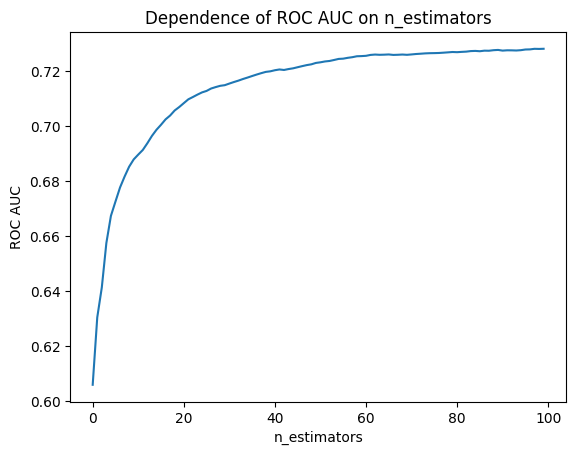

In [19]:
auc_scores = lgbm.evals_result_['valid_0']['auc']

plt.plot(range(len(auc_scores)), auc_scores)
plt.xlabel('n_estimators')
plt.ylabel('ROC AUC')
plt.title('Dependence of ROC AUC on n_estimators')
plt.show()

**Вопрос:** Что вы видите на полученных графиках? 

Нужно ли "обрезать" количество деревьев? Ответ обоснуйте.

**Ответ:** Да, можно обрезать количество деревьев ~ до 85. Это упростит модель и ускорит ее работу, незначительно уменьшив точность.  

Давайте проверим auc_test при 85 n_esimators

In [20]:
lgbm = LGBMClassifier(**best_params, n_estimators=85)

lgbm.fit(X=df.loc[df['sample_part'] == 'train', features_optuna],
    y=df.loc[df['sample_part'] == 'train', TARGET],
    eval_set= [(df.loc[df['sample_part'] == 'test', features_optuna], 
              df.loc[df['sample_part'] == 'test', TARGET])], 
    eval_metric='auc')

preds_test = lgbm.predict_proba(df.loc[df['sample_part'] == 'test', features_optuna])[:, 1]
auc_test2 = roc_auc_score(
    y_true=df.loc[df['sample_part'] == 'test', TARGET],
    y_score=preds_test
)
print('ROC AUC при n_estimators = 85: ', auc_test2)
print('Это на', auc_test - auc_test2, 'меньше, чем при n_estimators = 100')

[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13591
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
ROC AUC при n_estimators = 85:  0.727238033723156
Это на 0.0007743978189689305 меньше, чем при n_estimators = 100


Как видим, auc при уменьшении n_estimators несильно изменился.  
Также отмечу, что если наша цель auc >= 0.725, то n_estimators можно еще уменьшить ~ до 70

## Важность признаков (1 балл)

**Задание:** Постойте гистограмму важности признаков по `split` и `gain` для бустинга из предыдущего пункта.

In [21]:
import lightgbm

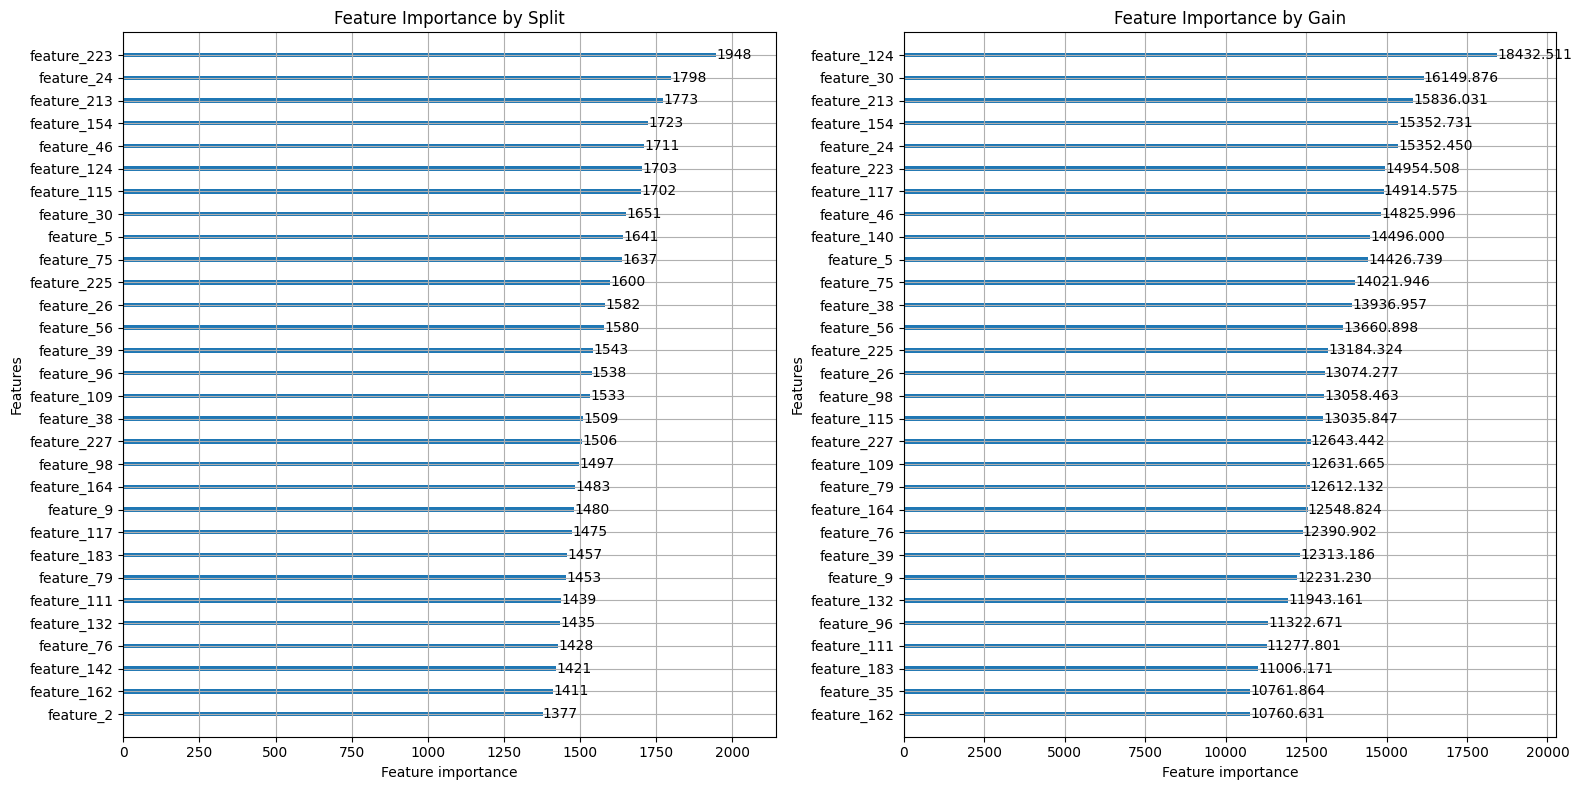

In [22]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
lightgbm.plot_importance(lgbm, importance_type='split', max_num_features=30, ax=plt.gca())
plt.title("Feature Importance by Split")

plt.subplot(1, 2, 2)
lightgbm.plot_importance(lgbm, importance_type='gain', max_num_features=30, ax=plt.gca())
plt.title("Feature Importance by Gain")
plt.tight_layout()
plt.show()

**Вопрос:** Какие выводы можно сделать из полученных графиков?

**Importance by gain:** важность признака, исходя из улучшения метрики от разделения узла по определенному признаку.  
**Importance by split:** важность признака, исходя из количества разделений узлов дерева по определенному признаку.

**Ответ:** Исходя из графиков и из опредений gain, split получаем:
1. Различный порядок важности признаков для split и gain
2. Если рассматривать топ 30 по важности признаков, то почти все они есть и в split и в gain
3. Небольшое отклонение кол-ва разделений в признаках по split, если не смотреть на 'feature_223'
4. По gain отклонение в среднем побольше между признаками

# Логрег

## plot_metric_time (1 балл)

**Задание:** Реализуйте функцию plot_metric_time, которая будет принимать на вход четыре аргумента, а именно: 
- массив значений фичи, 
- массив значений таргета,
- массив времени (аггрегированного по месяцам или кварталам, то есть `month` или `quarter` в вашей задаче, по дням рисовать не надо),
- метрику, которую необходимо отрисовать (нужно реализовать функцию для двух метрик: `IV` и `roc_auc`)
- число бакетов для вычисления `IV`, если выбрана эта метрика

Можете добваить какие-то ещё аргументы, если вам нужно

Если в фиче есть пропуски, функция должна убирать строки с пропусками из рассмотрения

**Hint**: можно, конечно, реализовать эту функцию через цикл, а можно попробовать разобраться и реализовать её через пандасовские `groupby` -> `apply`, это изящнее и быстрее

In [23]:
import plotly.graph_objects as go

In [24]:
def plot_metric_time(
        values: pd.Series,
        target: pd.Series,
        time: pd.Series,
        metric: str = 'IV',
        n_buckets_for_IV: int = 15
) -> go.Figure:
    mask = ~values.isna()
    values_without_nan = values[mask]
    target_without_nan = target[mask]
    time_without_nan = time[mask]
    data_time = pd.DataFrame({'values': values_without_nan, 'target': target_without_nan, 'time': time_without_nan}).groupby('time')
    if metric == 'IV':
        metric_values = data_time.apply(lambda x: IV_score(x['target'], calc_buckets(x['values'], n_buckets_for_IV)), include_groups=False)
    elif metric == 'roc_auc':
        metric_values = data_time.apply(lambda x: roc_auc_score(x['target'], x['values']), include_groups=False)
    else:
        raise NotImplementedError("only 'IV' and 'roc_auc' metrics are implemented")

    # your code here

    plot_title = f'{values.name}'
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=metric_values.index,
            y=metric_values.values,
            mode='markers+lines',
            name=values.name
            ))
    fig.update_layout(
            title_text=plot_title,
            yaxis=dict(title=metric, range=[0, 0.06]),
            width=1000,
            height=450,
            xaxis=dict(
                domain=[0, .95],
                showgrid=True,
                tickvals=metric_values.index
                ),
            margin=dict(l=30, r=30, b=30, t=50),
            )
    fig.show()

    # return fig

In [53]:
# примерно так это должно будет выглядеть
# plot_metric_time(df[...], df['target'], df['quarter']) # 

**Задание:** Возьмите **топ-15** фичей получившегося бустинга по важности по `gain`. Отрисуйте для них графики стабильности по `IV` во времени и удалите из рассмотрения те признаки, качество которых деградирует

**NB!** Обращайте внимание на масштаб оси *y!* Иногда признак стабильнее, чем кажется)

Если вам это мешает, можете поменять ось *y*, чтобы она начиналась от нуля в прошлом задании.

In [25]:
indices = reversed(lgbm.feature_importances_.argsort()[-15:])
top15features = [features_optuna[i] for i in indices]

In [26]:
for feature in top15features:
    plot_metric_time(df[feature], df['target'], df['month'])

На этом моменте предлагаю сделать новый маленький датафрейм, чтобы не "портить" исходный

И проводить все манипуляции с фичами на нём

In [14]:
top15features_stable = ['feature_26', 'feature_225', 'feature_56', 'feature_38', 'feature_75', 'feature_5', 'feature_140', 'feature_46', 'feature_223', 'feature_24', 'feature_213', 'feature_30', 'feature_124']

In [15]:
df_for_logreg = df[top15features_stable + ['date', 'month', 'quarter', 'target', 'sample_part']]

## Предобработка признаков (2 балла)

**Задание:** Используя функицю woe_line из предыдущего ДЗ, проверьте **числовые** фичи из полученного списка фичей на линейность по WoE на трейн-выборке (если в фиче есть пропуски - дропаем их при отрисовке)

Если фичи нелинейные, **линеаризуйте их**.

Преобразования, которые можно/стоит пробовать:
- клипы (`np.clip`) - зачастую их достаточно
- корень
- квадрат
- логарифм

Если нужно, можно прибавлять к фиче константу или менять её знак

При желании можно "распилить фичу на две половины" (если она немонотонна) и линеаризовать их по отдельности

Однако слишком упираться в линеаризацию фичей не нужно. Если фича ну совсем никак не линеаризуется, в крайнем случае можно её дропнуть или оставить как есть.

При отрисовке можно ограничиться 15-20 бакетами

In [16]:
from woe import woe_line

In [15]:
set(top15features_stable) & set(category_feature)

set()

In [16]:
woe_line((-df_for_logreg[top15features_stable[0]].to_numpy() +300)**2/1000 , df_for_logreg[TARGET].to_numpy(), 20)

In [17]:
df_for_logreg[top15features_stable[0]] = (-df_for_logreg[top15features_stable[0]].to_numpy() +300)**2/1000

/tmp/ipykernel_11948/4274007021.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_logreg[top15features_stable[0]] = (-df_for_logreg[top15features_stable[0]].to_numpy() +300)**2/1000


In [23]:
woe_line(-df_for_logreg[top15features_stable[1]].to_numpy(), df_for_logreg[TARGET].to_numpy(), 20)

In [18]:
df_for_logreg[top15features_stable[1]] = -df_for_logreg[top15features_stable[1]].to_numpy()

/tmp/ipykernel_11948/562712436.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_logreg[top15features_stable[1]] = -df_for_logreg[top15features_stable[1]].to_numpy()


In [19]:
woe_line(-((df_for_logreg[top15features_stable[2]].to_numpy()-350))**2, df_for_logreg[TARGET].to_numpy(), 20)

In [19]:
df_for_logreg[top15features_stable[2]] = -((df_for_logreg[top15features_stable[2]].to_numpy()-350))**2

/tmp/ipykernel_11948/1770315705.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_logreg[top15features_stable[2]] = -((df_for_logreg[top15features_stable[2]].to_numpy()-350))**2


In [70]:
woe_line(-df_for_logreg[top15features_stable[3]].to_numpy()**2, df_for_logreg[TARGET].to_numpy(), 20)

In [20]:
df_for_logreg[top15features_stable[3]] = -df_for_logreg[top15features_stable[3]].to_numpy()**2

/tmp/ipykernel_11948/1312982803.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_logreg[top15features_stable[3]] = -df_for_logreg[top15features_stable[3]].to_numpy()**2


In [73]:
woe_line(-df_for_logreg[top15features_stable[4]].to_numpy(), df_for_logreg[TARGET].to_numpy(), 20)

In [21]:
df_for_logreg[top15features_stable[4]] = -df_for_logreg[top15features_stable[4]].to_numpy()

/tmp/ipykernel_11948/3092451958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_logreg[top15features_stable[4]] = -df_for_logreg[top15features_stable[4]].to_numpy()


In [23]:
woe_line(-np.clip(np.log1p(np.clip((-df_for_logreg[top15features_stable[5]].to_numpy()), 0, 1000)), 4.4, 5.1), df_for_logreg[TARGET].to_numpy(), 20)

In [22]:
df_for_logreg[top15features_stable[5]] = -np.clip(np.log1p(np.clip((-df_for_logreg[top15features_stable[5]].to_numpy()), 0, 1000)), 4.4, 5.1)

/tmp/ipykernel_11948/1124901724.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_logreg[top15features_stable[5]] = -np.clip(np.log1p(np.clip((-df_for_logreg[top15features_stable[5]].to_numpy()), 0, 1000)), 4.4, 5.1)


In [26]:
woe_line(df_for_logreg[top15features_stable[6]].to_numpy()**2, df_for_logreg[TARGET].to_numpy(), 20)

In [23]:
df_for_logreg[top15features_stable[6]] = df_for_logreg[top15features_stable[6]].to_numpy()**2

/tmp/ipykernel_11948/1634906610.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_logreg[top15features_stable[6]] = df_for_logreg[top15features_stable[6]].to_numpy()**2


In [28]:
woe_line(-np.clip(df_for_logreg[top15features_stable[7]].to_numpy(), -20, 700), df_for_logreg[TARGET].to_numpy(), 20)

In [24]:
df_for_logreg[top15features_stable[7]] = -np.clip(df_for_logreg[top15features_stable[7]].to_numpy(), -20, 700)

/tmp/ipykernel_11948/124911854.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_logreg[top15features_stable[7]] = -np.clip(df_for_logreg[top15features_stable[7]].to_numpy(), -20, 700)


In [140]:
woe_line(df_for_logreg[top15features_stable[8]].to_numpy(), df_for_logreg[TARGET].to_numpy(), 20)

In [141]:
woe_line(df_for_logreg[top15features_stable[9]].to_numpy(), df_for_logreg[TARGET].to_numpy(), 20)

In [20]:
woe_line(-np.clip(df_for_logreg[top15features_stable[10]].to_numpy(), 1., 11.), df_for_logreg[TARGET].to_numpy(), 20)

In [25]:
df_for_logreg[top15features_stable[10]] = -np.clip(df_for_logreg[top15features_stable[10]].to_numpy(), 1., 11.)

/tmp/ipykernel_11948/2539174893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_logreg[top15features_stable[10]] = -np.clip(df_for_logreg[top15features_stable[10]].to_numpy(), 1., 11.)


In [190]:
woe_line(-df_for_logreg[top15features_stable[11]].to_numpy()**0.5, df_for_logreg[TARGET].to_numpy(), 20)

In [26]:
df_for_logreg[top15features_stable[11]] = -df_for_logreg[top15features_stable[11]].to_numpy()**0.5

/tmp/ipykernel_11948/4023554359.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_logreg[top15features_stable[11]] = -df_for_logreg[top15features_stable[11]].to_numpy()**0.5


In [196]:
woe_line(-df_for_logreg[top15features_stable[12]].to_numpy()**2/10, df_for_logreg[TARGET].to_numpy(), 20)

In [27]:
df_for_logreg[top15features_stable[12]] = -df_for_logreg[top15features_stable[12]].to_numpy()**2/10

/tmp/ipykernel_11948/4110465249.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_logreg[top15features_stable[12]] = -df_for_logreg[top15features_stable[12]].to_numpy()**2/10


Пришло время заполнить пропуски.

Самый простой вариант для числовых признаков - заполнить их средним значением фичи

**Вопрос**: какие проблемы могут возникнуть при таком заполнении пропусков?

**Задание**: Проверьте, что заполнение средним значением адекватно для тех признаков, где есть пропуски (hint: в нашем датасете - почти всегда адекватно). Если нет, придумайте, как ещё можно заполнить пропуски. Ну и заполните их)

Проблемы, которые могут возникнуть при заполнении пропусков средним:
1. Если пропуски не случайны, их заполнение средним может исказить истинное распределение данных.
2. Влияние на корреляцию.
3. В некоторых случаях пропуски могут нести важную информацию.
4. Если данные содержат выбросы, среднее значение может быть искажено, и его использование может быть неприемлемым.

Количество пропусков в признаке feature_140: 36943
Среднее значение: 1170.6308964123207, Медиана: 1024.0


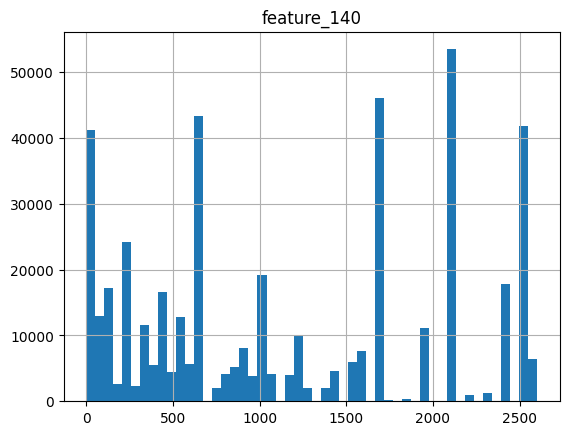

Количество пропусков в признаке feature_223: 73488
Среднее значение: 126.32742768119464, Медиана: 126.48481831008603


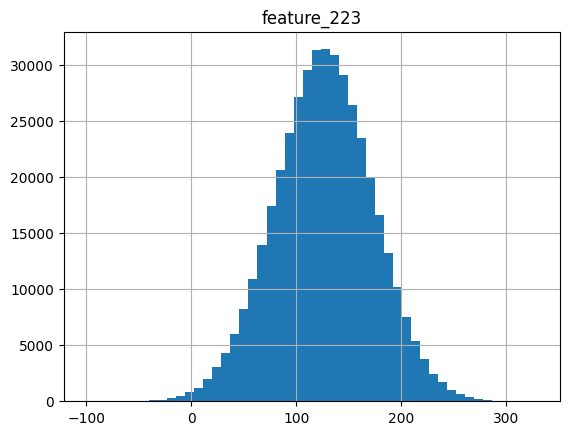

Количество пропусков в признаке feature_30: 34475
Среднее значение: -0.1547906778877057, Медиана: -0.13897917358256925


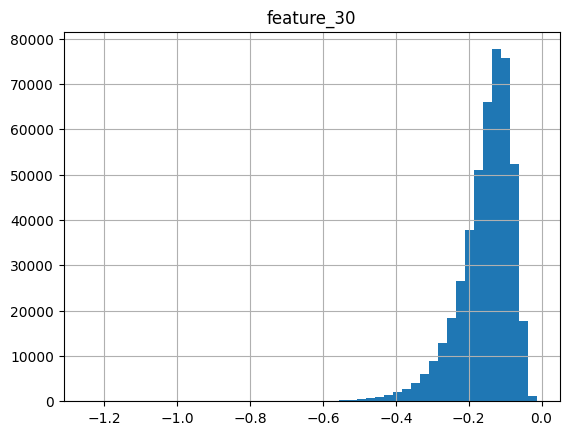

Количество пропусков в признаке feature_124: 58984
Среднее значение: -189.99443174525896, Медиана: -176.27659035997902


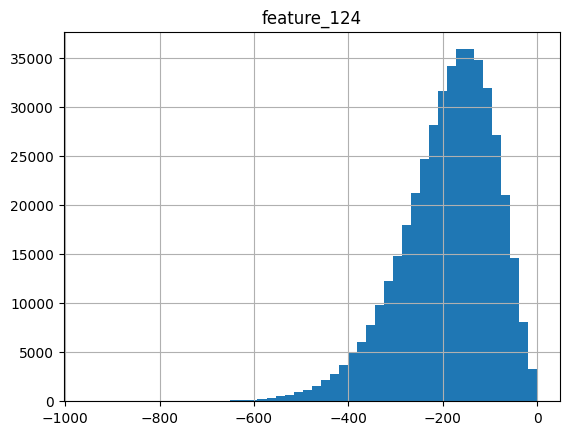

In [199]:
for feature in top15features_stable:
    nan_values = df_for_logreg[feature].isnull().sum()
    if nan_values != 0:
        mean_value = df_for_logreg[feature].mean()
        median_value = df_for_logreg[feature].median()
        print(f"Количество пропусков в признаке {feature}: {nan_values}")
        print(f"Среднее значение: {mean_value}, Медиана: {median_value}")
        df_for_logreg[feature].hist(bins=50)
        plt.title(feature)
        plt.show()

Признаки feature_223, feature_124, feature_30: нормальное и логнормальное распредения, поэтому можно заменять на среднее(хотя и пропусков у них много)  
Признак feature_140: тут наблюдается несколько мод, поэтому среднее значение может исказить результат, распределение неизвестное, поэтому удалю данный признак

In [47]:
df_for_logreg.loc[:, 'feature_223'] = df_for_logreg['feature_223'].fillna(df_for_logreg['feature_223'].mean())
df_for_logreg.loc[:, 'feature_124'] = df_for_logreg['feature_124'].fillna(df_for_logreg['feature_124'].mean())
df_for_logreg.loc[:, 'feature_30'] = df_for_logreg['feature_30'].fillna(df_for_logreg['feature_30'].mean())
top15features_stable.remove('feature_140')

ValueError: list.remove(x): x not in list

Количество пропусков в признаке feature_223: 0
Среднее значение: 126.32742768119468, Медиана: 126.32742768119464


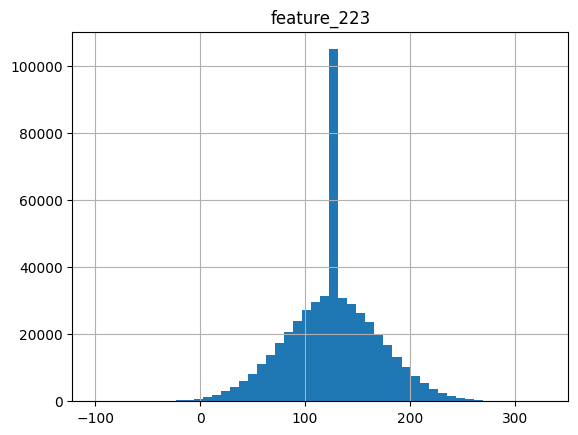

Количество пропусков в признаке feature_124: 0
Среднее значение: -189.9944317452589, Медиана: -189.99443174525896


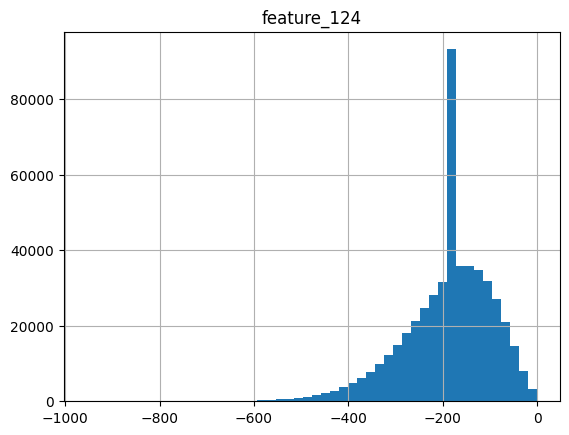

Количество пропусков в признаке feature_30: 0
Среднее значение: -0.15479067788770573, Медиана: -0.14507661112405362


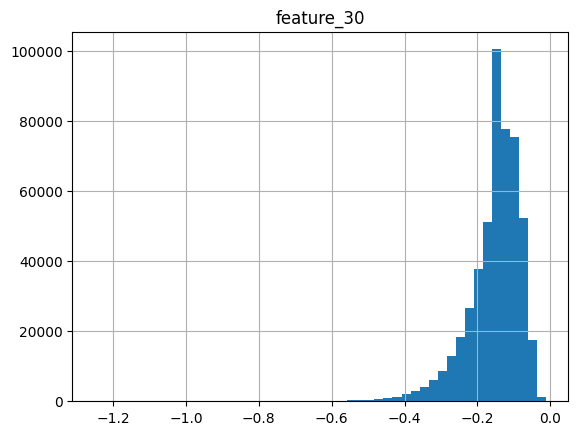

In [34]:
for feature in ['feature_223', 'feature_124', 'feature_30']:
    nan_values = df_for_logreg[feature].isnull().sum()
    mean_value = df_for_logreg[feature].mean()
    median_value = df_for_logreg[feature].median()
    print(f"Количество пропусков в признаке {feature}: {nan_values}")
    print(f"Среднее значение: {mean_value}, Медиана: {median_value}")
    df_for_logreg[feature].hist(bins=50)
    plt.title(feature)
    plt.show()

Вспомним про категориальные признаки, их нужно закодировать.

**Задание:** Используя `OneHotEncoder` закодируйте категориальные признаки.

In [35]:
# категориальных признаков нет

## Stepwise и обучение логрега (3 балла)

**Задание (boss)**: Реализуйте Stepwise-алгоритм.

Ваша функция `stepwise` должна принимать на вход:
- Датафрейм со всеми признаками и таргетом
- список с именами рассматриваемых признаков
- строку-имя таргета
- уровни значимости `alpha_in` и `alpha_out`

И возвращать список отобранных признаков.

Во время работы пусть она также выводит, какой признак был включён или исключён и с каким `p-value`

In [29]:
from scipy.stats.distributions import chi2
from sklearn.linear_model import LogisticRegression

In [30]:
def likelihood_ratio_test(ll_short, ll_long):
    
    """
    вспомогательная функция
    рассчитывает значение p-value для теста отношения правдоподобия
    ll_short — логарифм правдоподобия модели на k переменных
    ll_long — логарифм правдоподобия модели на k+1 переменной

    Returns
    -----
    p-value
    """
    lr = -2 * (ll_short - ll_long)
    return chi2.sf(lr, 1)

In [31]:
def log_likelihood(predictions, y):
    """
    Расчитывает логарифм правдоподобия для заданной модели и данных.
    """
    return np.sum(y*np.log1p(predictions) + (1-y)*np.log1p(1-predictions))

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [33]:
def stepwise(
        df: pd.DataFrame, 
        features: list[str], 
        target: str, 
        alpha_in: float = 0.01, 
        alpha_out:  float = 0.05
        ) -> list[str]:


    selected_features = list()
    mean_target = np.mean(df[target])
    baseline_predictions = np.full_like(df[target], mean_target, dtype=np.float64)
    cur_ll = log_likelihood(baseline_predictions, df[target])

    while True:

        # forward:
        best_feature = None
        p_value = alpha_in
        if (len(selected_features) < len(features)):
            for feature in features:
                if feature in selected_features:
                    continue
                current_features = selected_features + [feature]
                model = make_pipeline(
                    StandardScaler(),
                    LogisticRegression()
                ).fit(df[current_features], df[target])
                pred = model.predict_proba(df[current_features])[:,1]
                ll_long = log_likelihood(pred, df[target])
                feature_p_value = likelihood_ratio_test(cur_ll, ll_long)
                if (feature_p_value < p_value):
                    p_value = feature_p_value
                    best_feature = feature
            if best_feature:
                selected_features.append(best_feature)
                model = make_pipeline(
                    StandardScaler(),
                    LogisticRegression()
                ).fit(df[selected_features], df[target])
                pred = model.predict_proba(df[selected_features])[:,1]
                cur_ll = log_likelihood(pred, df[target])
                print(f"В модель была добавлена переменная {best_feature}, p-value: {round(p_value, 6)}")


        # backward
        worst_feature = None
        p_value = alpha_out
        if (len(selected_features) > 1):
            for feature in selected_features:
                current_features = list(selected_features)
                current_features.remove(feature)
                model = make_pipeline(
                    StandardScaler(),
                    LogisticRegression()
                ).fit(df[current_features], df[target])
                pred = model.predict_proba(df[current_features])[:,1]
                ll_short = log_likelihood(pred, df[target])
                feature_p_value = likelihood_ratio_test(ll_short, cur_ll)
                if (feature_p_value > p_value):
                    p_value = feature_p_value
                    worst_feature = feature

            if worst_feature:
                selected_features.remove(worst_feature)
                model = make_pipeline(
                    StandardScaler(),
                    LogisticRegression()
                ).fit(df[selected_features], df[target])
                pred = model.predict_proba(df[selected_features])[:,1]
                cur_ll = log_likelihood(pred, df[target])
                print(f"Из модели была удалена переменная {worst_feature}, p-value: {round(p_value, 6)}")

        if not (best_feature or worst_feature):
            break # но вы можете сформулировать критерий останова по-другому, если вам так будет удобнее писать

    return selected_features

Запустите ваш алгоритм на отобранных фичах со значениями `alpha_in = 0.01`, `alpha_out = 0.02`

Если в степвайз заходят *все переменные*, причём с очень маленькими `p-value` - это неудивительно, ведь вы уже провели серьёзный предварительный отбор фичей.

Чтобы убедиться в коректности работы своего алгоритма, можете попробовать запустить его на каких-нибудь других фичах, откинутых сильно ранее

In [34]:
selected_features = stepwise(df_for_logreg, top15features_stable, TARGET, alpha_in = 0.01, alpha_out = 0.02)

В модель была добавлена переменная feature_124, p-value: 0.0
В модель была добавлена переменная feature_30, p-value: 0.0
В модель была добавлена переменная feature_225, p-value: 0.0
В модель была добавлена переменная feature_24, p-value: 0.0
В модель была добавлена переменная feature_46, p-value: 0.0
В модель была добавлена переменная feature_213, p-value: 0.0
В модель была добавлена переменная feature_38, p-value: 0.0
В модель была добавлена переменная feature_223, p-value: 0.0
В модель была добавлена переменная feature_5, p-value: 0.0
В модель была добавлена переменная feature_75, p-value: 0.0
В модель была добавлена переменная feature_56, p-value: 0.0
В модель была добавлена переменная feature_26, p-value: 0.0


In [35]:
selected_features

['feature_124',
 'feature_30',
 'feature_225',
 'feature_24',
 'feature_46',
 'feature_213',
 'feature_38',
 'feature_223',
 'feature_5',
 'feature_75',
 'feature_56',
 'feature_26']

**Задание**: На получившемся наборе признаков обучим, наконец, логрег!

Для обучения можно использовать трейн + валидацию вместе, либо просто трейн

*Не забудьте отскалировать фичи*

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
df

In [48]:
X_train, y_train, X_test, y_test = df_for_logreg[df_for_logreg['sample_part'] != 'test'][selected_features],\
                                    df_for_logreg[df_for_logreg['sample_part'] != 'test'][TARGET],\
                                    df_for_logreg[df_for_logreg['sample_part'] == 'test'][selected_features],\
                                    df_for_logreg[df_for_logreg['sample_part'] == 'test'][TARGET]
X = df_for_logreg[selected_features]
pipe = Pipeline([
    ('standardscaler', StandardScaler()),
    ('logisticregression', LogisticRegression(verbose=0, random_state=42))
])
param_grid = {
    'logisticregression__penalty': ['l2', None],
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'logisticregression__tol': [1e-4, 1e-3, 1e-2],
    'logisticregression__fit_intercept': [True, False],
    'logisticregression__intercept_scaling': [1, 2, 3],
    'logisticregression__class_weight': [None, 'balanced'],
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'logisticregression__max_iter': list(range(10, 1000, 10)),
    'logisticregression__warm_start': [True, False],
}


In [51]:
bayes_search = RandomizedSearchCV(pipe, param_grid, n_iter=40, random_state=42, n_jobs=1)
bayes_search.fit(X_train, y_train)

/home/denis/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/denis/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/denis/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/denis/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/denis/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/denis/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWar

RandomizedSearchCV(estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('logisticregression',
                                              LogisticRegression(random_state=42))]),
                   n_iter=40, n_jobs=1,
                   param_distributions={'logisticregression__C': [0.01, 0.1, 1,
                                                                  10, 100],
                                        'logisticregression__class_weight': [None,
                                                                             'balanced'],
                                        'logisticregression__fit_intercept': [True,
                                                                              False],
                                        'logisticregression__i...
                                        'logisticregression__max_iter': [10, 20,
                                                                         30, 40,
                                                                         50, 60,
                                                                         70, 80,
                                                                         90,
                                                                         100,
                                                                         110,
                                                                         120,
                                                                         130,
                                                                         140,
                                                                         150,
                                                                         160,
                                                                         170,
                                                                         180,
                                                                         190,
                                                                         200,
                                                                         210,
                                                                         220,
                                                                         230,
                                                                         240,
                                                                         250,
                                                                         260,
                                                                         270,
                                                                         280,
                                                                         290,
                                                                         300, ...],
                                        'logisticregression__penalty': ['l2',
                                                                        None],
                                        'logisticregression__solver': ['newton-cg',
                                                                       'lbfgs',
                                                                       'sag',
                                                                       'saga'],
                                        'logisticregression__tol': [0.0001,
                                                                    0.001,
                                                                    0.01],
                                        'logisticregression__warm_start': [True,
                                                                           False]},
                   random_state=42)

In [52]:
best_params = {key[len('logisticregression__'):]: val for key, val in bayes_search.best_params_.items()}

In [53]:
best_params

{'warm_start': False,
 'tol': 0.001,
 'solver': 'newton-cg',
 'penalty': 'l2',
 'max_iter': 870,
 'intercept_scaling': 1,
 'fit_intercept': True,
 'class_weight': None,
 'C': 10}

In [54]:
logreg = Pipeline([
    ('standardscaler', StandardScaler()),
    ('logisticregression', LogisticRegression(**best_params))
])
logreg.fit(X_train, y_train)
df_for_logreg['logreg'] = logreg.predict_proba(X)[:, 1]
df_for_logreg['logit_logreg'] = logit(df_for_logreg['logreg'])

/tmp/ipykernel_11948/3000569535.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_logreg['logreg'] = logreg.predict_proba(X)[:, 1]
/tmp/ipykernel_11948/3000569535.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_logreg['logit_logreg'] = logit(df_for_logreg['logreg'])


**Задание:** Оцените качество получившегося логрега **на тестовой выборке** по метрике `roc_auc`. 

**Ваша задача - побить** `threshold_auc = 0.622`. Если этого сделать ну совсем не получается, попробуйте добавить в модель ещё переменных (но должно получаться :)

**Также:**

- Постройте графики линейности по WoE получившегося логрега на трейне и тестовой выборке (оценивайте линейность для `logit_logreg`, а не для вероятности!)
- Постройте график стабильности `roc_auc` во времени для получившегося логрега

In [56]:
woe_line(df_for_logreg[df_for_logreg['sample_part'] == 'train']["logit_logreg"].to_numpy(), df_for_logreg[df_for_logreg['sample_part'] == 'train'][TARGET].to_numpy(), 20)

In [57]:
woe_line(df_for_logreg[df_for_logreg['sample_part'] == 'test']["logit_logreg"].to_numpy(), df_for_logreg[df_for_logreg['sample_part'] == 'test'][TARGET].to_numpy(), 20)

:`(  
Очевидно, что модель врятли побьет 0.622 roc auc при данных фичях, возможно, стоило бы их взять побольше.  
Однако, в данной модели есть и хорошая сторона: стабильность - сестра таланта!

**Задание:** Визуализируйте важность фичей полученной линейной модели.

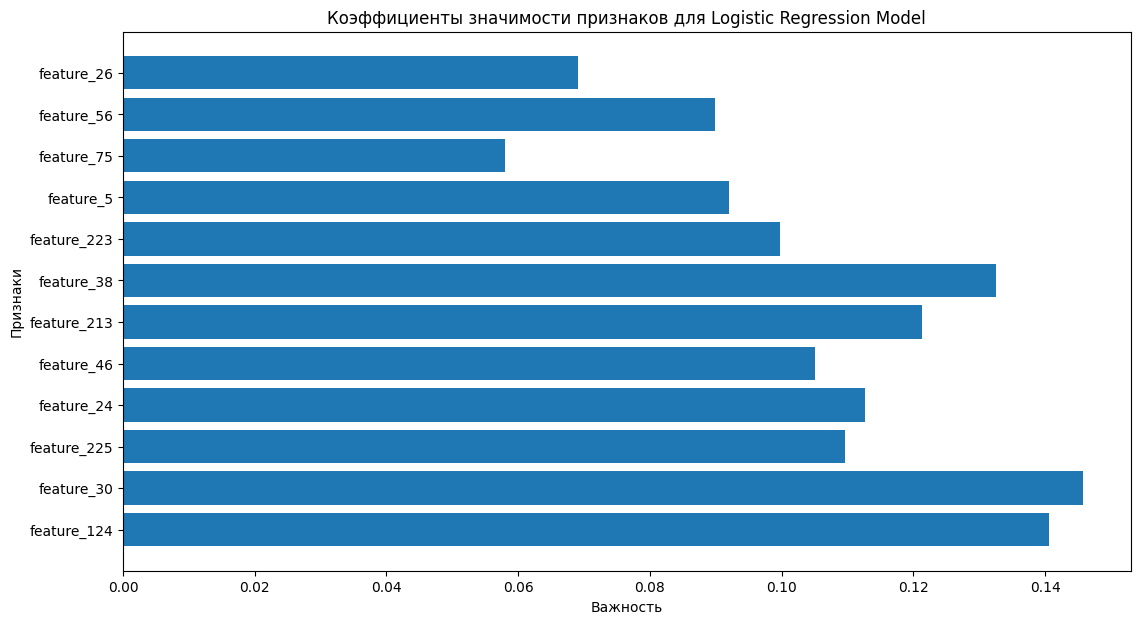

In [58]:
plt.figure(figsize=(13, 7))
plt.barh(selected_features, logreg['logisticregression'].coef_[0])
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.title('Коэффициенты значимости признаков для Logistic Regression Model')
plt.show()

# Бонусная часть (3 балла)

В разделе про бустинг мы обучали `LGBMClassifier` на довольно большом наборе фичей. Их количество можно сократить, при этом не теряя в качестве модели.

За начальный набор признаков можно взять все признаки (все 230) или признаки после отбора по IV.

**Ваша задача:** Отобрать признаки, подобрать оптимальные гиперпараметры и обучить `LGBMClassifier`.

Задание творческое) Можно использовать любые методы отбора признаков / оптимизации гиперпараметров.

**Чем меньше признаков, без ухудшения качества модели – тем лучше.**

Идеи для отбора признаков:

- Воспользоваться методами из модуля `sklearn.feature_selection` (точно можно попробовать RFE). Документация https://scikit-learn.org/stable/modules/feature_selection.html
- С помощью `BorutaPy` из библиотеки `boruta` (https://towardsdatascience.com/simple-example-using-boruta-feature-selection-in-python-8b96925d5d7a – статья может помочь разобраться с запуском алгоритма (мб не откроется без vpn))

In [ ]:
# your answere here